<a href="https://www.kaggle.com/code/ravitejagonnabathula/predicting-loan-payback?scriptVersionId=283727950" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries 

In [1]:
# Core Libraries
import os
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style="whitegrid")

# Statistics and Diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Optimization
import optuna

# Explainability
import shap

# List dataset files
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s5e11'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


# Load Train and Test Data 

In [2]:
train  = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

# Exploratory data analysis 

## Basic Data Overview

In [3]:
train.shape

(593994, 13)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [5]:
train.head()

id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other             C3             1.0  
1  Debt consolidation             D3             0.0  
2  Debt consolidation             C5             1.0  
3  Debt consolidation             F1             1.0  
4               Other             D1             1.0

In [6]:
train.describe()

id  annual_income  debt_to_income_ratio   credit_score  \
count  593994.000000  593994.000000         593994.000000  593994.000000   
mean   296996.500000   48212.202976              0.120696     680.916009   
std    171471.442235   26711.942078              0.068573      55.424956   
min         0.000000    6002.430000              0.011000     395.000000   
25%    148498.250000   27934.400000              0.072000     646.000000   
50%    296996.500000   46557.680000              0.096000     682.000000   
75%    445494.750000   60981.320000              0.156000     719.000000   
max    593993.000000  393381.740000              0.627000     849.000000   

         loan_amount  interest_rate  loan_paid_back  
count  593994.000000  593994.000000   593994.000000  
mean    15020.297629      12.356345        0.798820  
std      6926.530568       2.008959        0.400883  
min       500.090000       3.200000        0.000000  
25%     10279.620000      10.990000        1.000000  
50%     15000.220000      12.370000        1.000000  
75%     18858.580000      13.680000        1.000000  
max     48959.950000      20.990000        1.000000

In [7]:
train.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [8]:
train.duplicated().sum()

0

## Identify Column Types 

In [9]:
num_cols   = train.select_dtypes(include='number').columns.tolist()
cat_cols   = train.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols  = train.select_dtypes(include='bool').columns.tolist()
date_cols  = train.select_dtypes(include='datetime').columns.tolist()

# Optional: identify text-heavy columns
text_cols  = [col for col in cat_cols 
              if train[col].dtype == 'object' and train[col].str.len().mean() > 50]


In [10]:
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)
print("Boolean Columns:", bool_cols)
print("Datetime Columns:", date_cols)
print("Text Columns:", text_cols)


Numerical Columns: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']
Categorical Columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Boolean Columns: []
Datetime Columns: []
Text Columns: []


In [11]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
#Threshold = the cutoff number of unique values after which a categorical column is considered high-cardinality.
threshold = 20

high_cardinality_cols = [col for col in cat_cols if train[col].nunique() > threshold]
low_cardinality_cols  = [col for col in cat_cols if train[col].nunique() <= threshold]

print("High Cardinality Categorical:", high_cardinality_cols)
print("Low Cardinality Categorical:", low_cardinality_cols)


High Cardinality Categorical: ['grade_subgrade']
Low Cardinality Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']


In [12]:
# Target column : loan_paid_back

## Target Variable Analysis 

In [13]:
target = "loan_paid_back"   # change this to your target column

# Class distribution
print("Class Distribution:")
print(train[target].value_counts())

print("\nClass Percentages:")
print(train[target].value_counts(normalize=True) * 100)

# Balanced vs imbalanced check
major_class_pct = train[target].value_counts(normalize=True).max() * 100

if major_class_pct > 70:
    print("\n Dataset is IMBALANCED.")
    print(f"Majority class = {major_class_pct:.2f}%")
else:
    print("\n Dataset is BALANCED.")
    print(f"Majority class = {major_class_pct:.2f}%")


Class Distribution:
loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

Class Percentages:
loan_paid_back
1.0    79.881952
0.0    20.118048
Name: proportion, dtype: float64

 Dataset is IMBALANCED.
Majority class = 79.88%


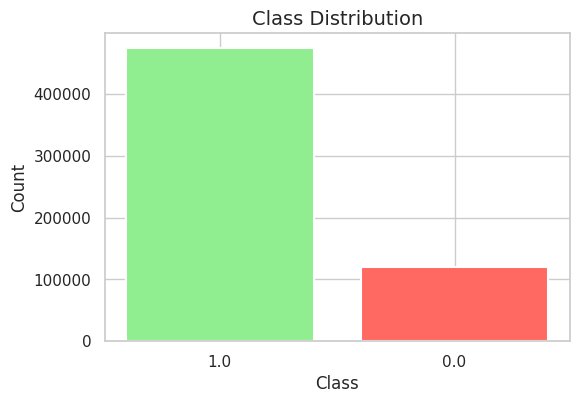

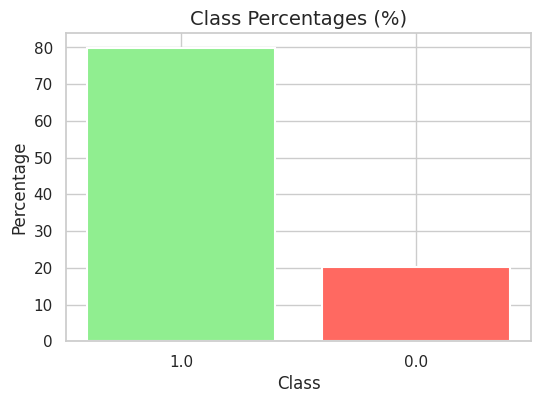

In [14]:
# Class counts and percentages
class_counts = train[target].value_counts()
class_percent = train[target].value_counts(normalize=True) * 100

# Define color mapping
color_map = {
    '1.0': '#90EE90',
    '0.0': '#FF6961'
}

# --- Class Distribution ---
plt.figure(figsize=(6,4))
plt.bar(
    class_counts.index.astype(str),
    class_counts.values,
    linewidth=1.5,
    color=[color_map[i] for i in class_counts.index.astype(str)]
)
plt.title("Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# --- Class Percentages ---
plt.figure(figsize=(6,4))
plt.bar(
    class_percent.index.astype(str),
    class_percent.values,
    linewidth=1.5,
    color=[color_map[i] for i in class_percent.index.astype(str)]
)
plt.title("Class Percentages (%)", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.show()


## Univariate Analysis 

### Numerical Columns

Feature: annual_income
count    593994.000000
mean      48212.202976
std       26711.942078
min        6002.430000
25%       27934.400000
50%       46557.680000
75%       60981.320000
max      393381.740000
Name: annual_income, dtype: float64 

Skewness: 1.720
Zero %: 0.00%
Outliers: 15917
Outlier %: 2.68%
Min: 6002.43 | Max: 393381.74 | Mean: 48212.20297629101 | Medain: 46557.68


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


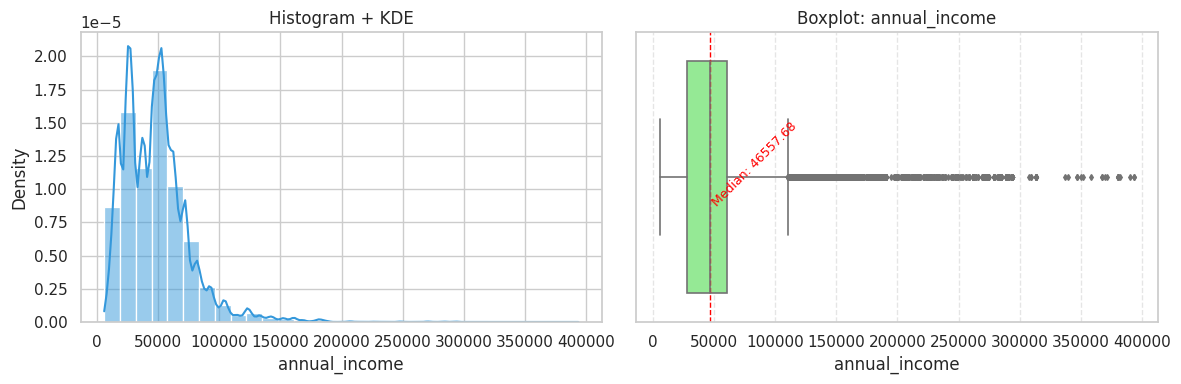

Feature: debt_to_income_ratio
count    593994.000000
mean          0.120696
std           0.068573
min           0.011000
25%           0.072000
50%           0.096000
75%           0.156000
max           0.627000
Name: debt_to_income_ratio, dtype: float64 

Skewness: 1.407
Zero %: 0.00%
Outliers: 17556
Outlier %: 2.96%
Min: 0.011 | Max: 0.627 | Mean: 0.12069589053088078 | Medain: 0.096


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


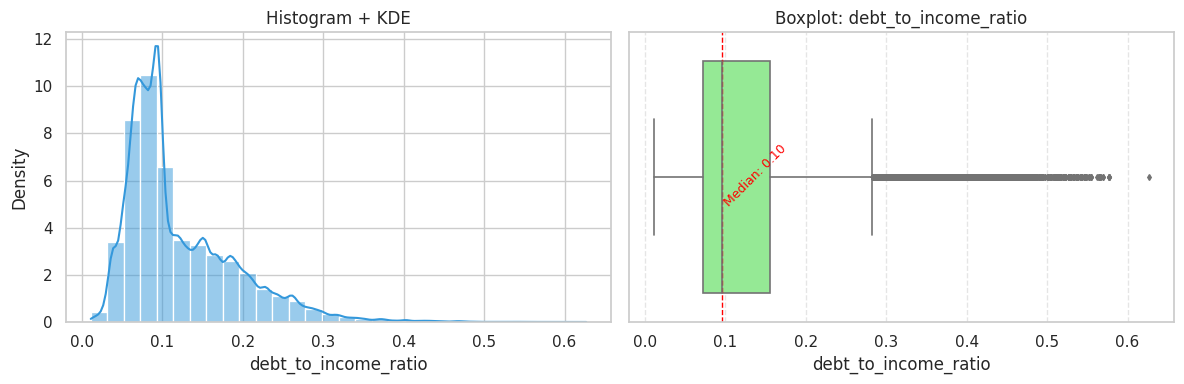

Feature: credit_score
count    593994.000000
mean        680.916009
std          55.424956
min         395.000000
25%         646.000000
50%         682.000000
75%         719.000000
max         849.000000
Name: credit_score, dtype: float64 

Skewness: -0.167
Zero %: 0.00%
Outliers: 5901
Outlier %: 0.99%
Min: 395 | Max: 849 | Mean: 680.9160092526187 | Medain: 682.0


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


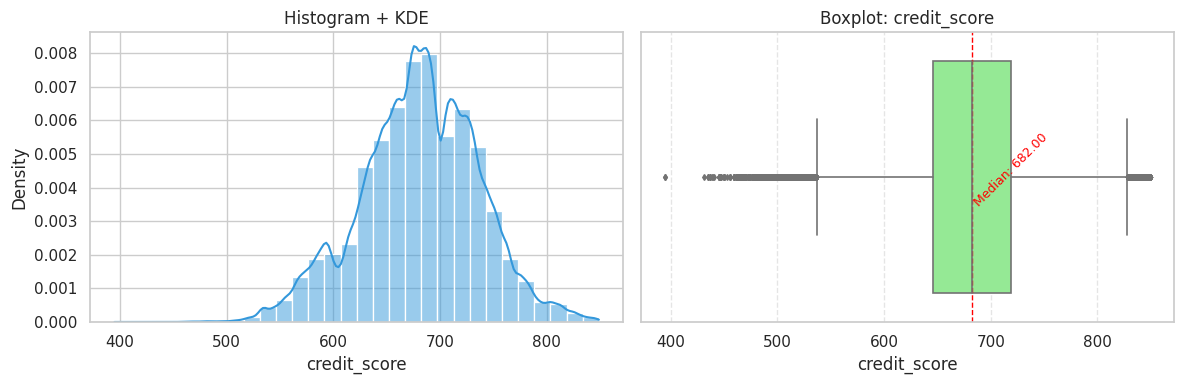

Feature: loan_amount
count    593994.000000
mean      15020.297629
std        6926.530568
min         500.090000
25%       10279.620000
50%       15000.220000
75%       18858.580000
max       48959.950000
Name: loan_amount, dtype: float64 

Skewness: 0.207
Zero %: 0.00%
Outliers: 2902
Outlier %: 0.49%
Min: 500.09 | Max: 48959.95 | Mean: 15020.297628526214 | Medain: 15000.22


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


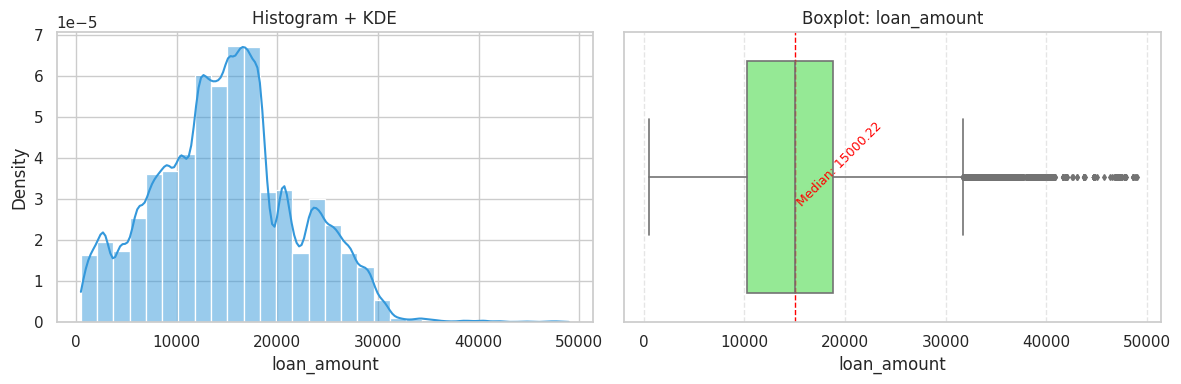

Feature: interest_rate
count    593994.000000
mean         12.356345
std           2.008959
min           3.200000
25%          10.990000
50%          12.370000
75%          13.680000
max          20.990000
Name: interest_rate, dtype: float64 

Skewness: 0.050
Zero %: 0.00%
Outliers: 5136
Outlier %: 0.86%
Min: 3.2 | Max: 20.99 | Mean: 12.356345200456571 | Medain: 12.37


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


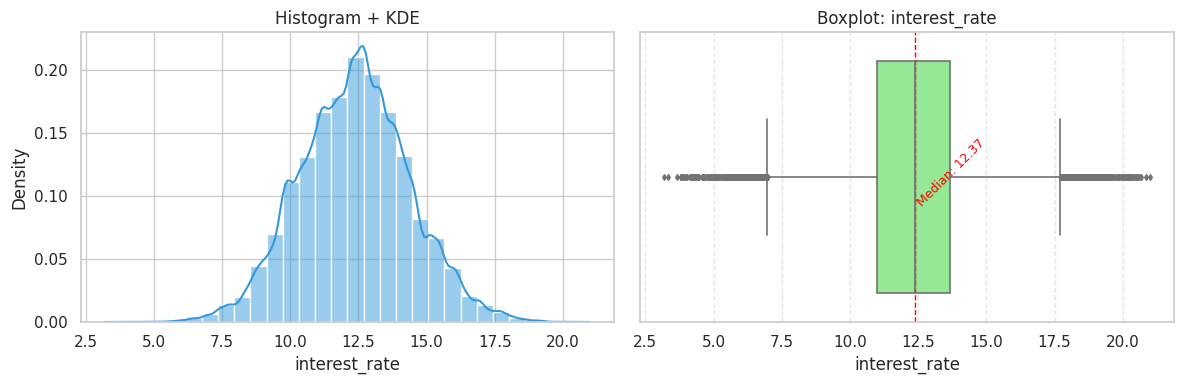

In [15]:
target = "loan_paid_back"

for col in num_cols:
    if col in ("id",target) :
        continue
        
    print("="*60)
    print(f"Feature: {col}")
    print("="*60)
    
    # Basic Stats
    print(train[col].describe(), "\n")
    
    # Skewness
    print(f"Skewness: {train[col].skew():.3f}")
    
    # Zero-inflation
    print(f"Zero %: {(train[col] == 0).mean()*100:.2f}%")
    
    # Outlier Count using IQR
    Q1, Q3 = train[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((train[col] < lower) | (train[col] > upper)).sum()
    print(f"Outliers: {outliers}")
    
    # Percentage of outliers
    outlier_pct = (outliers / len(train[col])) * 100
    print(f"Outlier %: {outlier_pct:.2f}%")
    
    # Range
    print(f"Min: {train[col].min()} | Max: {train[col].max()} | Mean: {train[col].mean()} | Medain: {train[col].median()}")
    
    # Plots
    plt.figure(figsize=(12,4))
    
    # Histogram + KDE (same plot)
    plt.subplot(1, 2, 1)
    sns.histplot(train[col], bins=30, kde=True, stat='density', color="#3498db")
    plt.title("Histogram + KDE")
    
    # Boxplot
    plt.subplot(1, 2, 2)

    sns.boxplot(
        x=train[col],
        color="#90EE90",
        linewidth=1.2,
        fliersize=3,
        saturation=0.9
    )

    plt.title(f"Boxplot: {col}", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Add median line
    median = train[col].median()
    plt.axvline(median, color='red', linestyle='--', linewidth=1)

    plt.text(median, 0.1, f"Median: {median:.2f}", color='red', fontsize=9, ha='left',rotation=45)


    
    plt.tight_layout()
    plt.show()


### Categorical Columns

Categorical Feature: gender
 Value Counts:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64 

 Category Frequency (%):
gender
Female    51.55
Male      47.83
Other      0.63
Name: proportion, dtype: float64 

 Rare Categories (< 1.0%): ['Other']
 High Cardinality: NO (3 unique values)




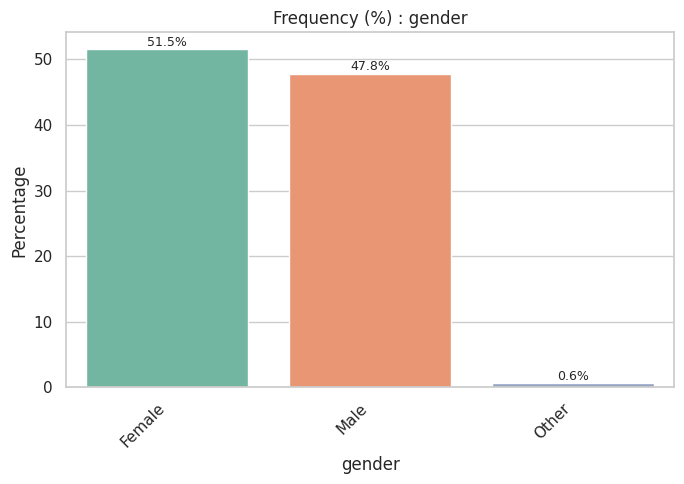

Categorical Feature: marital_status
 Value Counts:
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64 

 Category Frequency (%):
marital_status
Single      48.63
Married     46.67
Divorced     3.59
Widowed      1.11
Name: proportion, dtype: float64 

 Rare Categories (< 1.0%): None
 High Cardinality: NO (4 unique values)




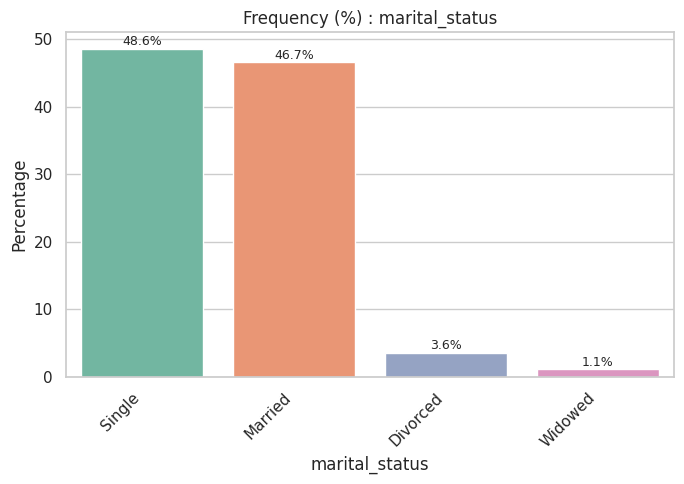

Categorical Feature: education_level
 Value Counts:
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64 

 Category Frequency (%):
education_level
Bachelor's     47.07
High School    30.91
Master's       15.67
Other           4.49
PhD             1.86
Name: proportion, dtype: float64 

 Rare Categories (< 1.0%): None
 High Cardinality: NO (5 unique values)




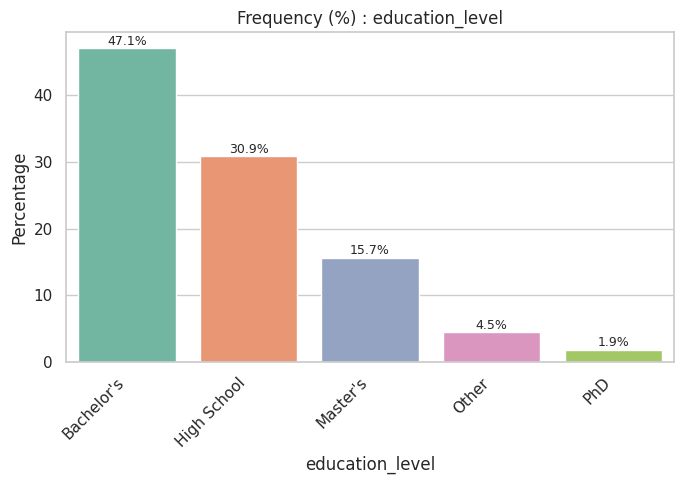

Categorical Feature: employment_status
 Value Counts:
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64 

 Category Frequency (%):
employment_status
Employed         75.87
Unemployed       10.52
Self-employed     8.84
Retired           2.77
Student           2.01
Name: proportion, dtype: float64 

 Rare Categories (< 1.0%): None
 High Cardinality: NO (5 unique values)




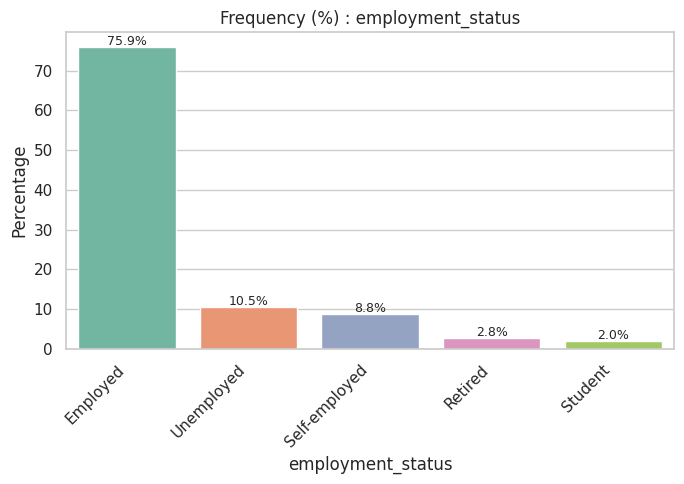

Categorical Feature: loan_purpose
 Value Counts:
loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64 

 Category Frequency (%):
loan_purpose
Debt consolidation    54.66
Other                 10.75
Car                    9.78
Home                   7.43
Education              6.17
Business               5.94
Medical                3.84
Vacation               1.42
Name: proportion, dtype: float64 

 Rare Categories (< 1.0%): None
 High Cardinality: NO (8 unique values)




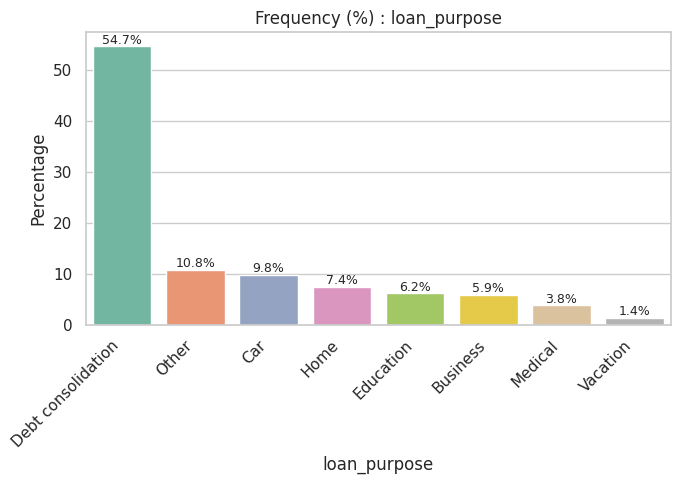

Categorical Feature: grade_subgrade
 Value Counts:
grade_subgrade
C3    58695
C4    55957
C2    54443
C1    53363
C5    53317
D1    37029
D3    36694
D4    35097
D2    34432
D5    32101
B2    15167
B1    14344
B5    13937
B3    13926
B4    13877
E4     8036
E3     7075
E1     6891
E2     6372
E5     6084
F5     5947
F4     5535
F1     5534
F2     5203
F3     5082
A5     2471
A3     2066
A2     2018
A4     1701
A1     1600
Name: count, dtype: int64 

 Category Frequency (%):
grade_subgrade
C3    9.88
C4    9.42
C2    9.17
C1    8.98
C5    8.98
D1    6.23
D3    6.18
D4    5.91
D2    5.80
D5    5.40
B2    2.55
B1    2.41
B5    2.35
B3    2.34
B4    2.34
E4    1.35
E3    1.19
E1    1.16
E2    1.07
E5    1.02
F5    1.00
F4    0.93
F1    0.93
F2    0.88
F3    0.86
A5    0.42
A3    0.35
A2    0.34
A4    0.29
A1    0.27
Name: proportion, dtype: float64 

 Rare Categories (< 1.0%): ['F4', 'F1', 'F2', 'F3', 'A5', 'A3', 'A2', 'A4', 'A1']
 High Cardinality: YES (30 unique values)




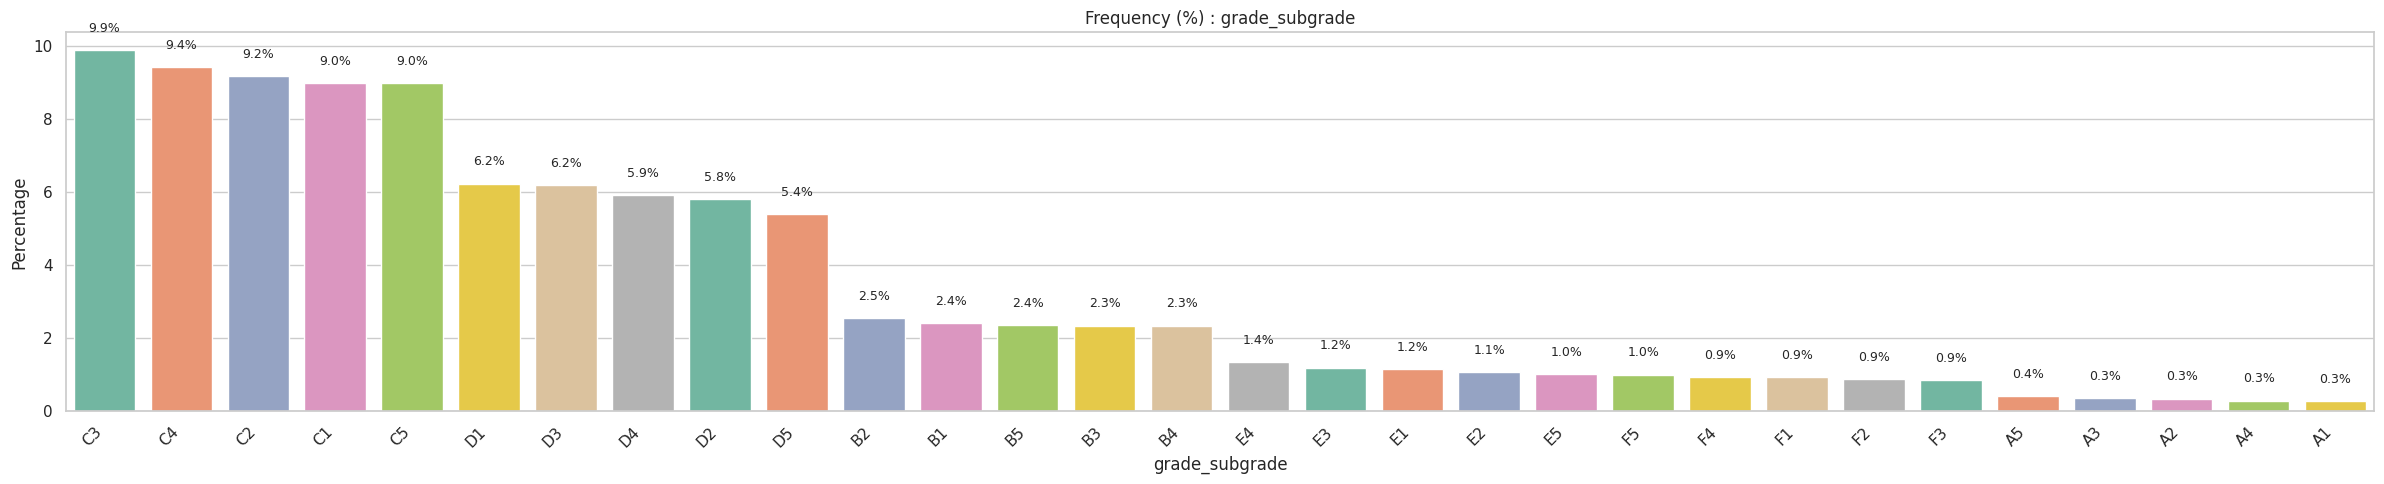

In [16]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Thresholds (you can change)
rare_threshold = 0.01      # 1%
cardinality_threshold = 20 # more than 20 unique categories = high-cardinality

for col in cat_cols:

    print("="*70)
    print(f"Categorical Feature: {col}")
    print("="*70)

    # --- Value Counts ---
    vc = train[col].value_counts()
    print(" Value Counts:")
    print(vc, "\n")

    # --- Frequency (%) ---
    freq_pct = (train[col].value_counts(normalize=True) * 100).round(2)
    print(" Category Frequency (%):")
    print(freq_pct, "\n")

    # --- Rare Categories ---
    rare_cats = freq_pct[freq_pct < (rare_threshold * 100)].index.tolist()
    print(f" Rare Categories (< {rare_threshold*100}%): {rare_cats if rare_cats else 'None'}")

    # --- High Cardinality Check ---
    unique_count = train[col].nunique()
    if unique_count > cardinality_threshold:
        print(f" High Cardinality: YES ({unique_count} unique values)")
    else:
        print(f" High Cardinality: NO ({unique_count} unique values)")

    print("\n")

    # --- PLOTS ---
    num_categories = len(freq_pct)

    # Auto-adjust width based on number of categories
    plt.figure(figsize=( max(7, num_categories * 0.8), 5 ))

    # FREQUENCY PLOT (BAR)
    sns.barplot(x=freq_pct.index, y=freq_pct.values, palette="Set2")
    plt.title(f"Frequency (%) : {col}")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(freq_pct.values):
        plt.text(
            i, v + 0.5,                # position (x=index, y=value+offset)
            f"{v:.1f}%",               # format label
            ha='center', fontsize=9
        )

    plt.tight_layout()
    plt.show()


## Bivariate Analysis

### Numerical vs Target

Numerical Feature vs Target: annual_income
 Mean by Target:
loan_paid_back
0.0    47875.503881
1.0    48296.999711
Name: annual_income, dtype: float64 

 Median by Target:
loan_paid_back
0.0    45935.39
1.0    46664.37
Name: annual_income, dtype: float64 



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


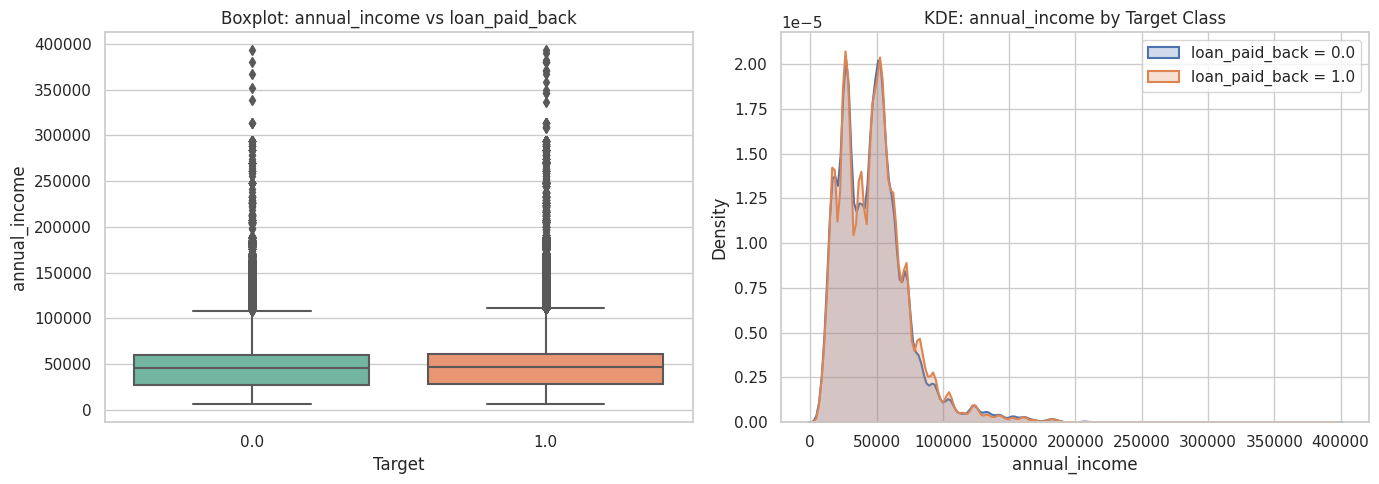

Numerical Feature vs Target: debt_to_income_ratio
 Mean by Target:
loan_paid_back
0.0    0.166564
1.0    0.109144
Name: debt_to_income_ratio, dtype: float64 

 Median by Target:
loan_paid_back
0.0    0.165
1.0    0.092
Name: debt_to_income_ratio, dtype: float64 



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


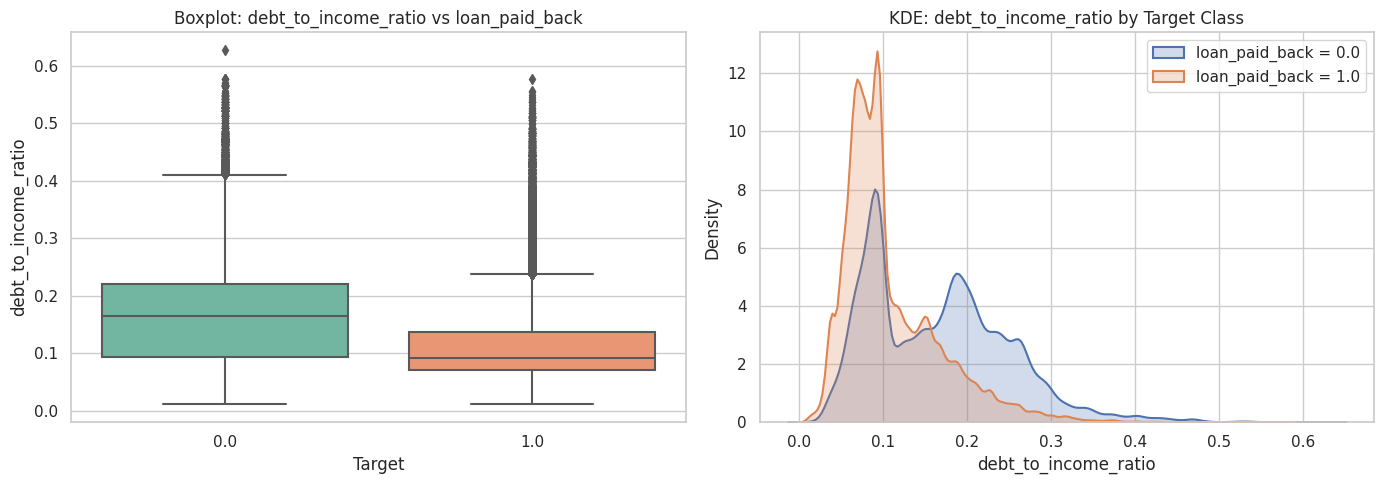

Numerical Feature vs Target: credit_score
 Mean by Target:
loan_paid_back
0.0    655.010628
1.0    687.440208
Name: credit_score, dtype: float64 

 Median by Target:
loan_paid_back
0.0    657.0
1.0    688.0
Name: credit_score, dtype: float64 



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


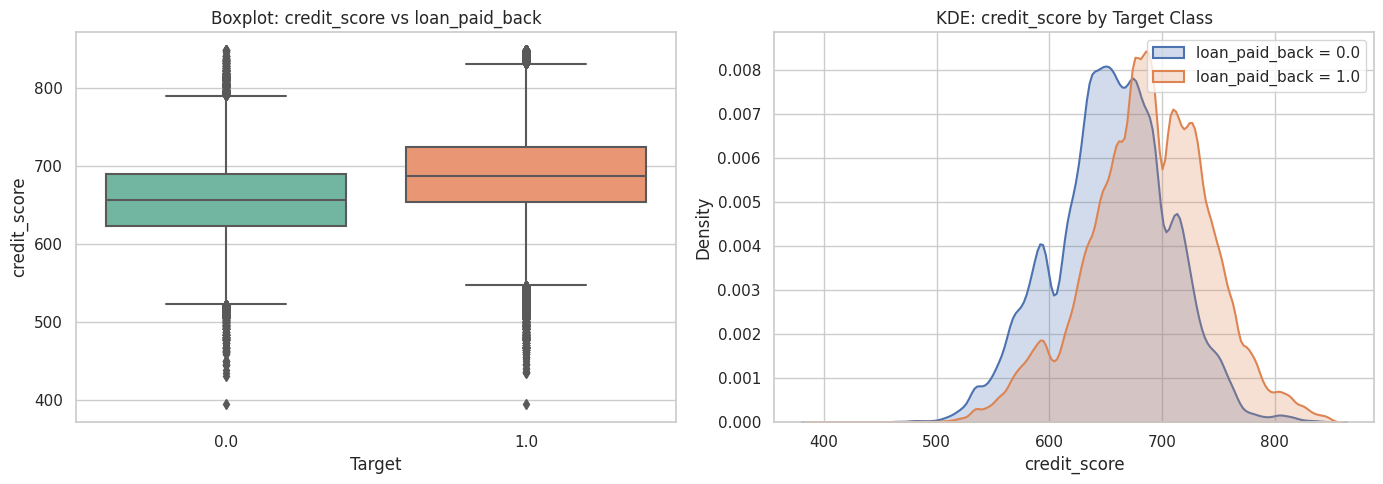

Numerical Feature vs Target: loan_amount
 Mean by Target:
loan_paid_back
0.0    15072.223883
1.0    15007.220145
Name: loan_amount, dtype: float64 

 Median by Target:
loan_paid_back
0.0    15078.79
1.0    14957.85
Name: loan_amount, dtype: float64 



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


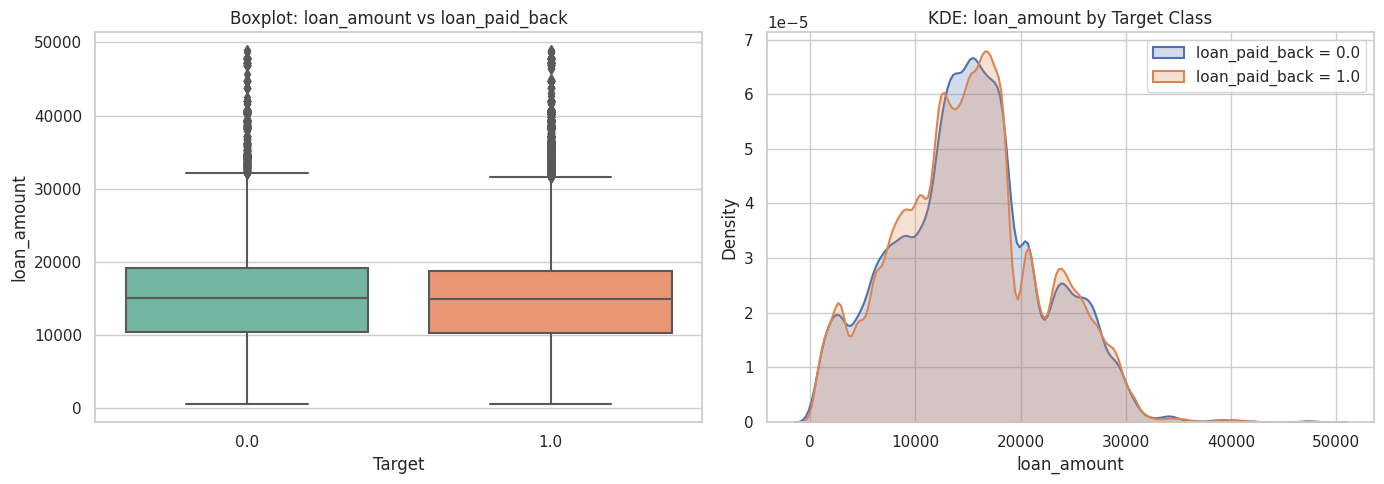

Numerical Feature vs Target: interest_rate
 Mean by Target:
loan_paid_back
0.0    12.881495
1.0    12.224088
Name: interest_rate, dtype: float64 

 Median by Target:
loan_paid_back
0.0    12.875
1.0    12.250
Name: interest_rate, dtype: float64 



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


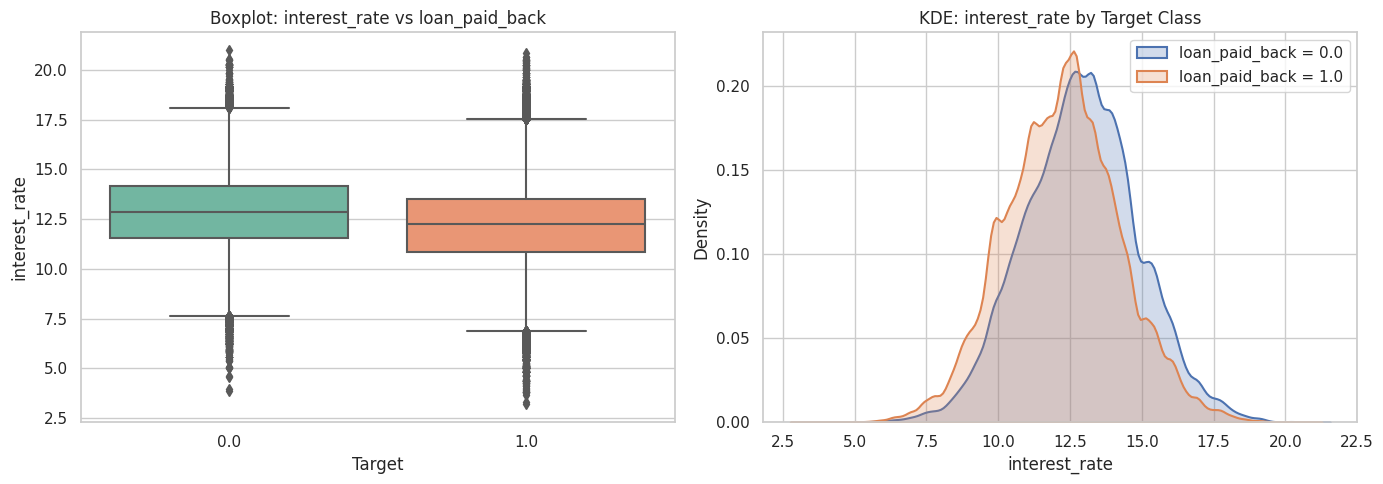

In [17]:

num_cols = train.select_dtypes(include='number').columns.tolist()

target = "loan_paid_back"

for col in num_cols:
    if col in ("id",target) :
        continue

    print("="*70)
    print(f"Numerical Feature vs Target: {col}")
    print("="*70)

    # --- Mean / Median Comparison ---
    means = train.groupby(target)[col].mean()
    medians = train.groupby(target)[col].median()

    print(" Mean by Target:")
    print(means, "\n")

    print(" Median by Target:")
    print(medians, "\n")

    # ---------------- PLOTS ----------------
    plt.figure(figsize=(14,5))

    # --- 1. BOX PLOT ---
    plt.subplot(1, 2, 1)
    sns.boxplot(x=train[target], y=train[col], palette="Set2")
    plt.title(f"Boxplot: {col} vs {target}")
    plt.xlabel("Target")
    plt.ylabel(col)

    # --- 2. KDE PLOT ---
    plt.subplot(1, 2, 2)
    for cls in sorted(train[target].unique()):
        sns.kdeplot(
            train[train[target] == cls][col],
            fill=True,
            label=f"{target} = {cls}",
            linewidth=1.5
        )

    plt.title(f"KDE: {col} by Target Class")
    plt.xlabel(col)
    plt.legend()

    plt.tight_layout()
    plt.show()

### Categorical vs Target

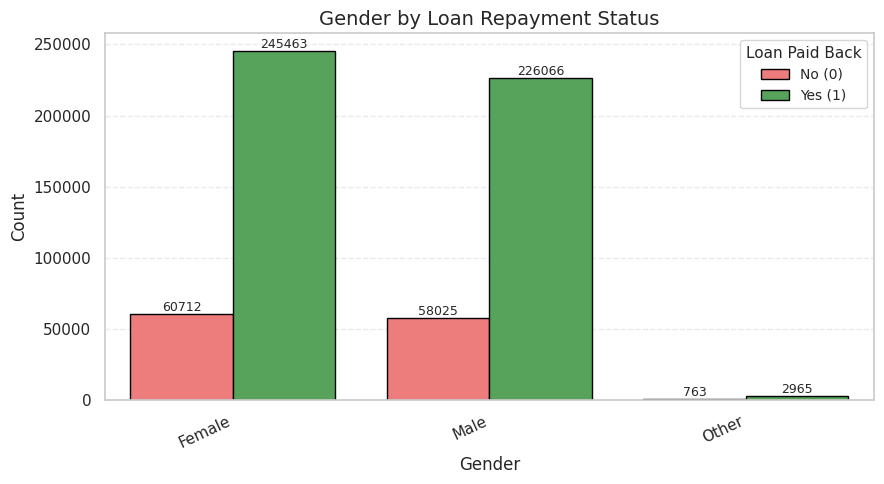

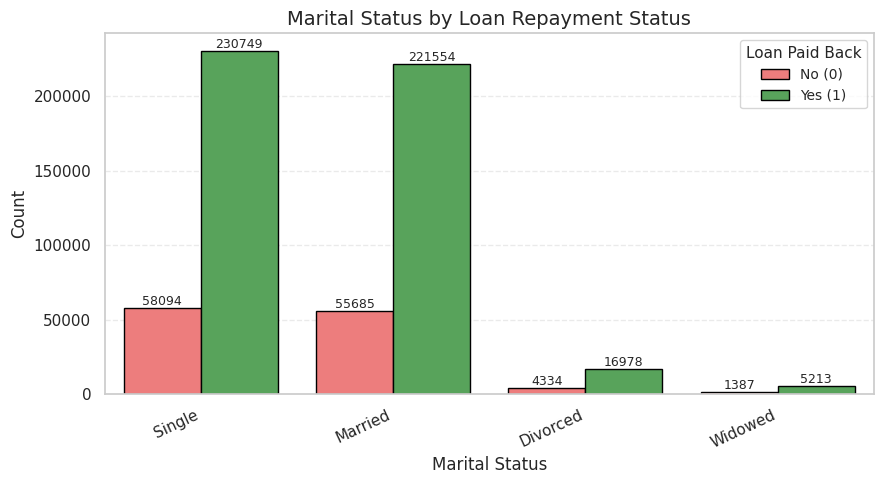

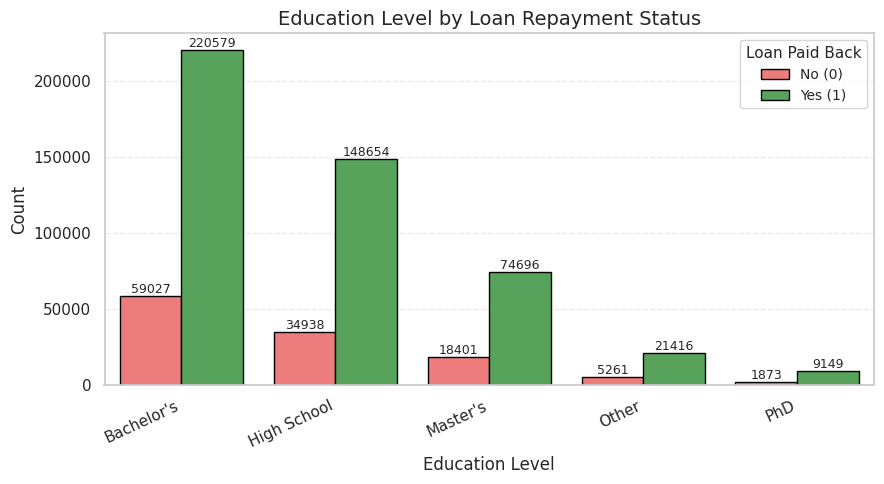

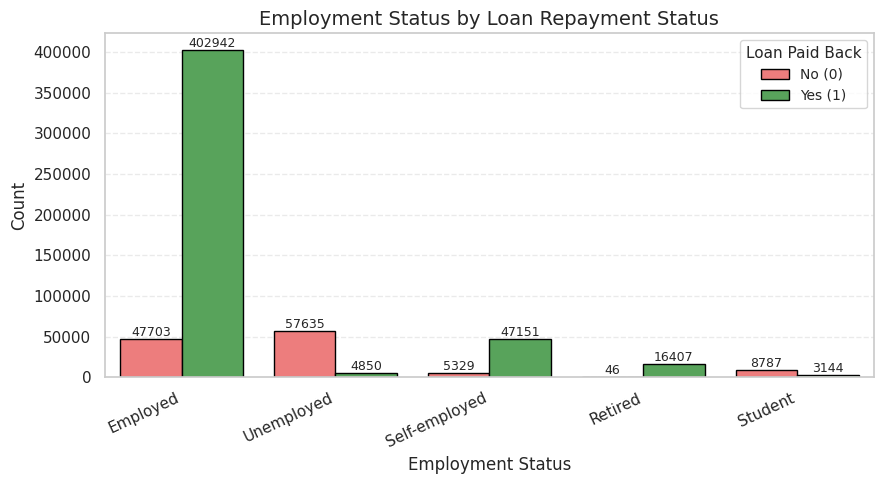

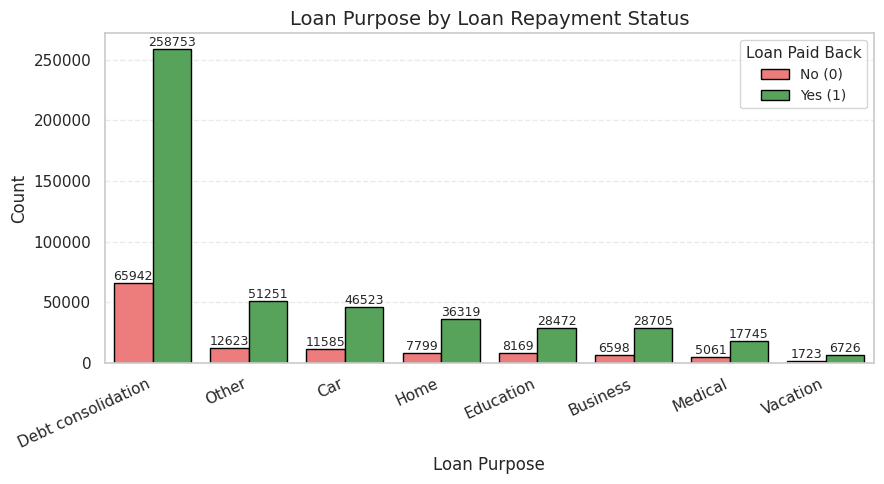

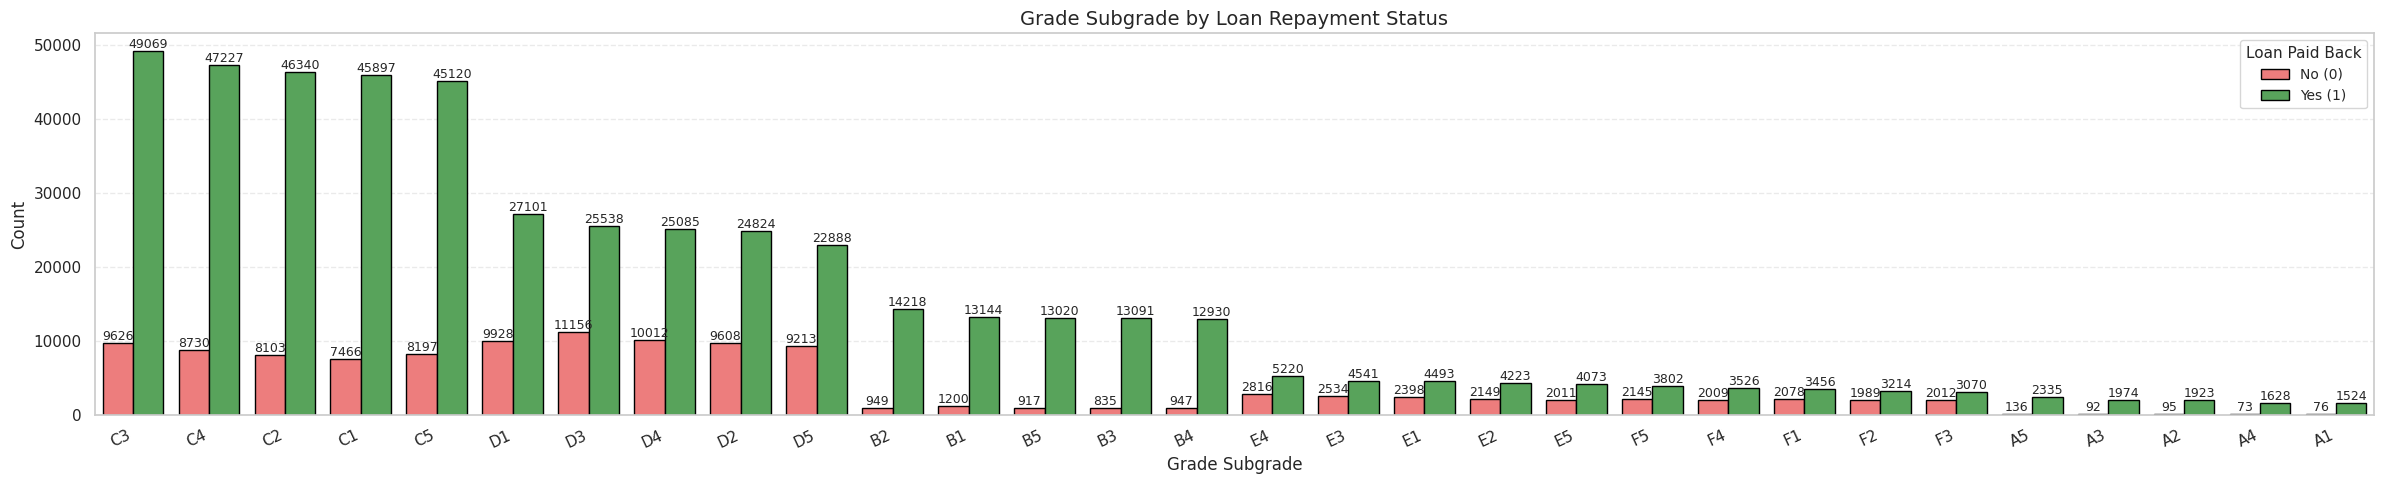

In [18]:
custom_palette = {0: "#FF6B6B", 1: "#4CAF50"}   # Red = default, Green = paid

for col in cat_cols:

    # Number of unique categories in this column
    num_categories = train[col].nunique()

    # Dynamic width: base width = 9, add 0.7 per category
    width = max(9, num_categories * 0.8)

    plt.figure(figsize=(width, 5))

    ax = sns.countplot(
        data=train,
        x=col,
        hue=target,
        palette=custom_palette,
        edgecolor='black',
        order=train[col].value_counts().index
    )
    
    plt.title(f'{col.replace("_", " ").title()} by Loan Repayment Status', fontsize=14)
    plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=25, ha='right')

    # -------- Add count labels above bars --------
    for bar in ax.patches:
        count = int(bar.get_height())
        ax.annotate(
            f'{count}',
            (bar.get_x() + bar.get_width() / 2, count),
            ha='center', va='bottom',
            fontsize=9
        )

    plt.legend(
        title='Loan Paid Back',
        labels=['No (0)', 'Yes (1)'],
        fontsize=10,
        title_fontsize=11
    )

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


### Numerical vs Numerical 



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a 

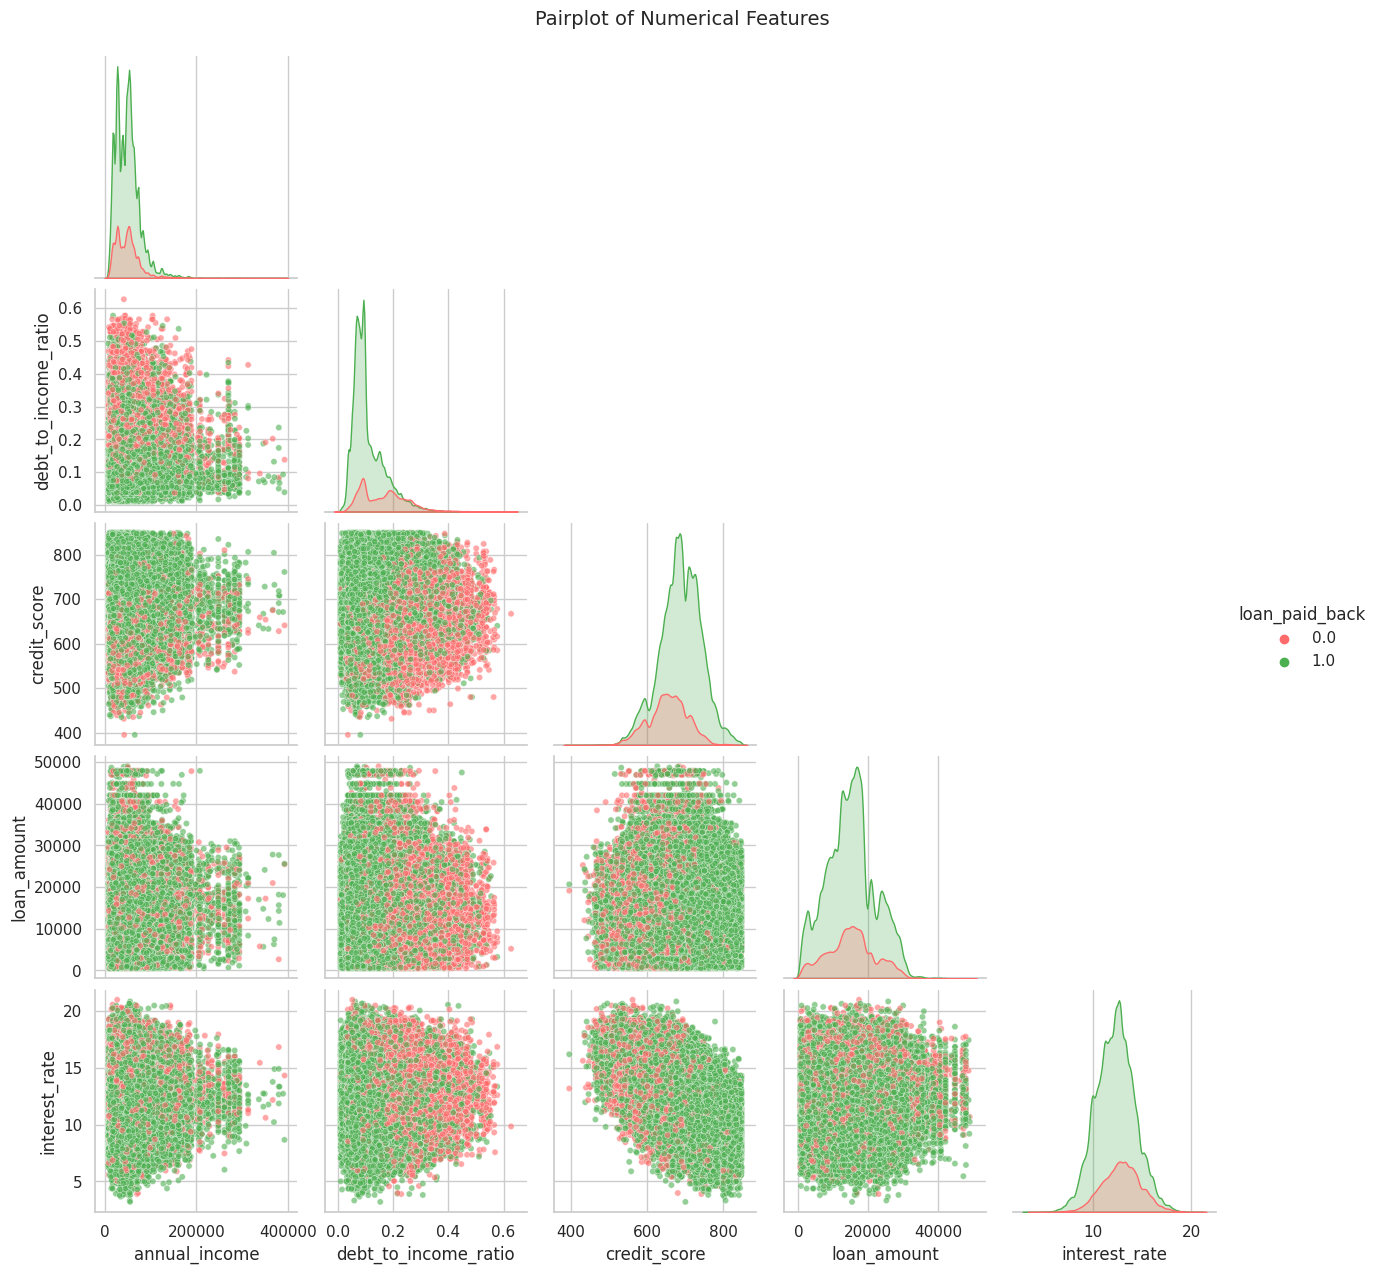

In [19]:

# Remove ID + target from numerical pairplot
for drop in ["id", target]:
    if drop in num_cols:
        num_cols.remove(drop)

# Build pairplot dataset
pairplot_df = train[num_cols + [target]]

# Pairplot
sns.pairplot(
    pairplot_df,
    hue=target,
    palette={0: "#FF6B6B", 1: "#4CAF50"},   # red/green
    diag_kind="kde",                        # KDE on diagonals
    corner=True,                            # show only lower triangle
    plot_kws={"alpha": 0.6, "s": 20},       # scatter styling
    diag_kws={"shade": True}                # KDE shading
)

plt.suptitle("Pairplot of Numerical Features", y=1.02, fontsize=14)
plt.show()

### Categorical vs Categorical

Categorical vs Categorical: gender  ×  marital_status

 Crosstab (Counts):

marital_status  Divorced  Married  Single  Widowed
gender                                            
Female             10811   143010  148908     3446
Male               10377   132481  138110     3123
Other                124     1748    1825       31

 Crosstab (% by row):

marital_status  Divorced  Married  Single  Widowed
gender                                            
Female              3.53    46.71   48.63     1.13
Male                3.65    46.63   48.61     1.10
Other               3.33    46.89   48.95     0.83


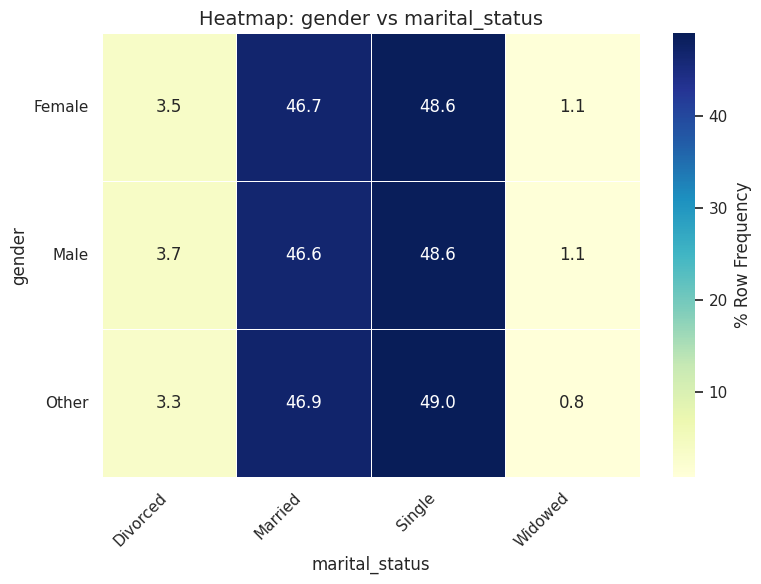

Categorical vs Categorical: gender  ×  education_level

 Crosstab (Counts):

education_level  Bachelor's  High School  Master's  Other   PhD
gender                                                         
Female               144057        94877     47978  13551  5712
Male                 133889        87546     44504  12918  5234
Other                  1660         1169       615    208    76

 Crosstab (% by row):

education_level  Bachelor's  High School  Master's  Other   PhD
gender                                                         
Female                47.05        30.99     15.67   4.43  1.87
Male                  47.13        30.82     15.67   4.55  1.84
Other                 44.53        31.36     16.50   5.58  2.04


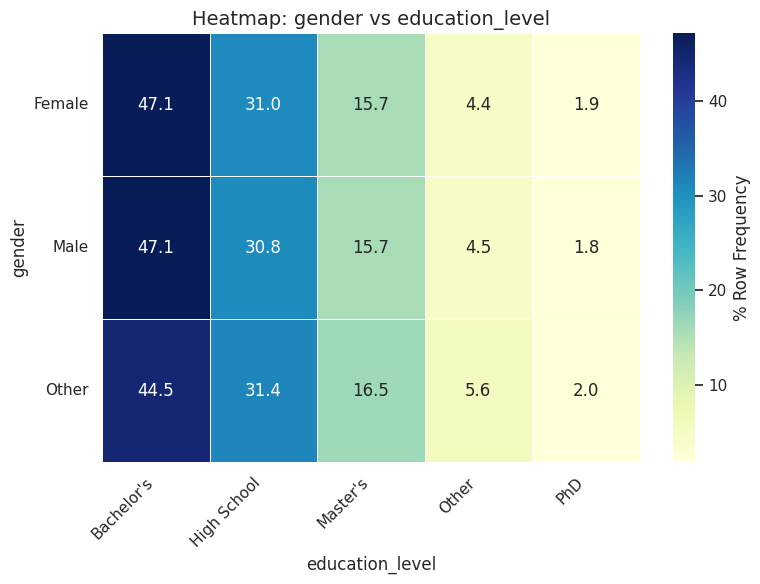

Categorical vs Categorical: gender  ×  employment_status

 Crosstab (Counts):

employment_status  Employed  Retired  Self-employed  Student  Unemployed
gender                                                                  
Female               232414     8510          27149     5914       32188
Male                 215404     7833          24989     5949       29916
Other                  2827      110            342       68         381

 Crosstab (% by row):

employment_status  Employed  Retired  Self-employed  Student  Unemployed
gender                                                                  
Female                75.91     2.78           8.87     1.93       10.51
Male                  75.82     2.76           8.80     2.09       10.53
Other                 75.83     2.95           9.17     1.82       10.22


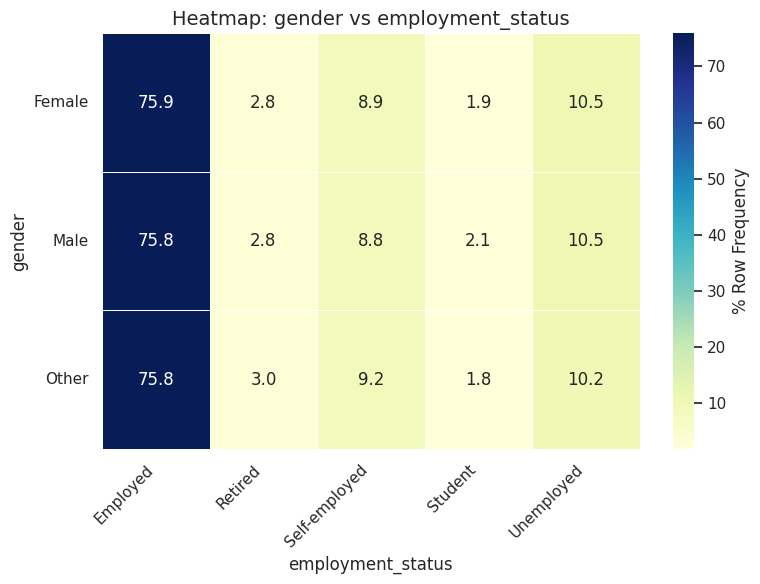

Categorical vs Categorical: gender  ×  loan_purpose

 Crosstab (Counts):

loan_purpose  Business    Car  Debt consolidation  Education   Home  Medical  \
gender                                                                         
Female           18185  29733              167871      18878  22884    11606   
Male             16908  28029              154821      17536  20923    11082   
Other              210    346                2003        227    311      118   

loan_purpose  Other  Vacation  
gender                         
Female        32922      4096  
Male          30487      4305  
Other           465        48  

 Crosstab (% by row):

loan_purpose  Business   Car  Debt consolidation  Education  Home  Medical  \
gender                                                                       
Female            5.94  9.71               54.83       6.17  7.47     3.79   
Male              5.95  9.87               54.50       6.17  7.36     3.90   
Other             5.63  9.28 

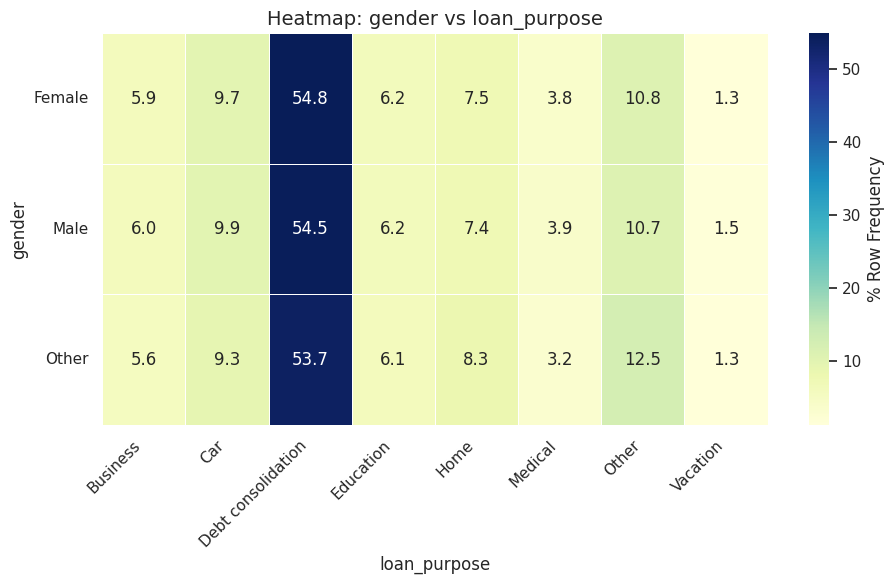

Categorical vs Categorical: gender  ×  grade_subgrade

 Crosstab (Counts):

grade_subgrade   A1    A2    A3   A4    A5    B1    B2    B3    B4    B5  ...  \
gender                                                                    ...   
Female          880  1060  1145  905  1334  7476  7890  7194  7405  7386  ...   
Male            711   949   907  791  1125  6786  7182  6658  6391  6476  ...   
Other             9     9    14    5    12    82    95    74    81    75  ...   

grade_subgrade    E1    E2    E3    E4    E5    F1    F2    F3    F4    F5  
gender                                                                      
Female          3686  3304  3731  4229  3194  2917  2640  2552  2838  2976  
Male            3164  3015  3298  3737  2859  2580  2544  2501  2662  2931  
Other             41    53    46    70    31    37    19    29    35    40  

[3 rows x 30 columns]

 Crosstab (% by row):

grade_subgrade    A1    A2    A3    A4    A5    B1    B2    B3    B4    B5  \
gender  

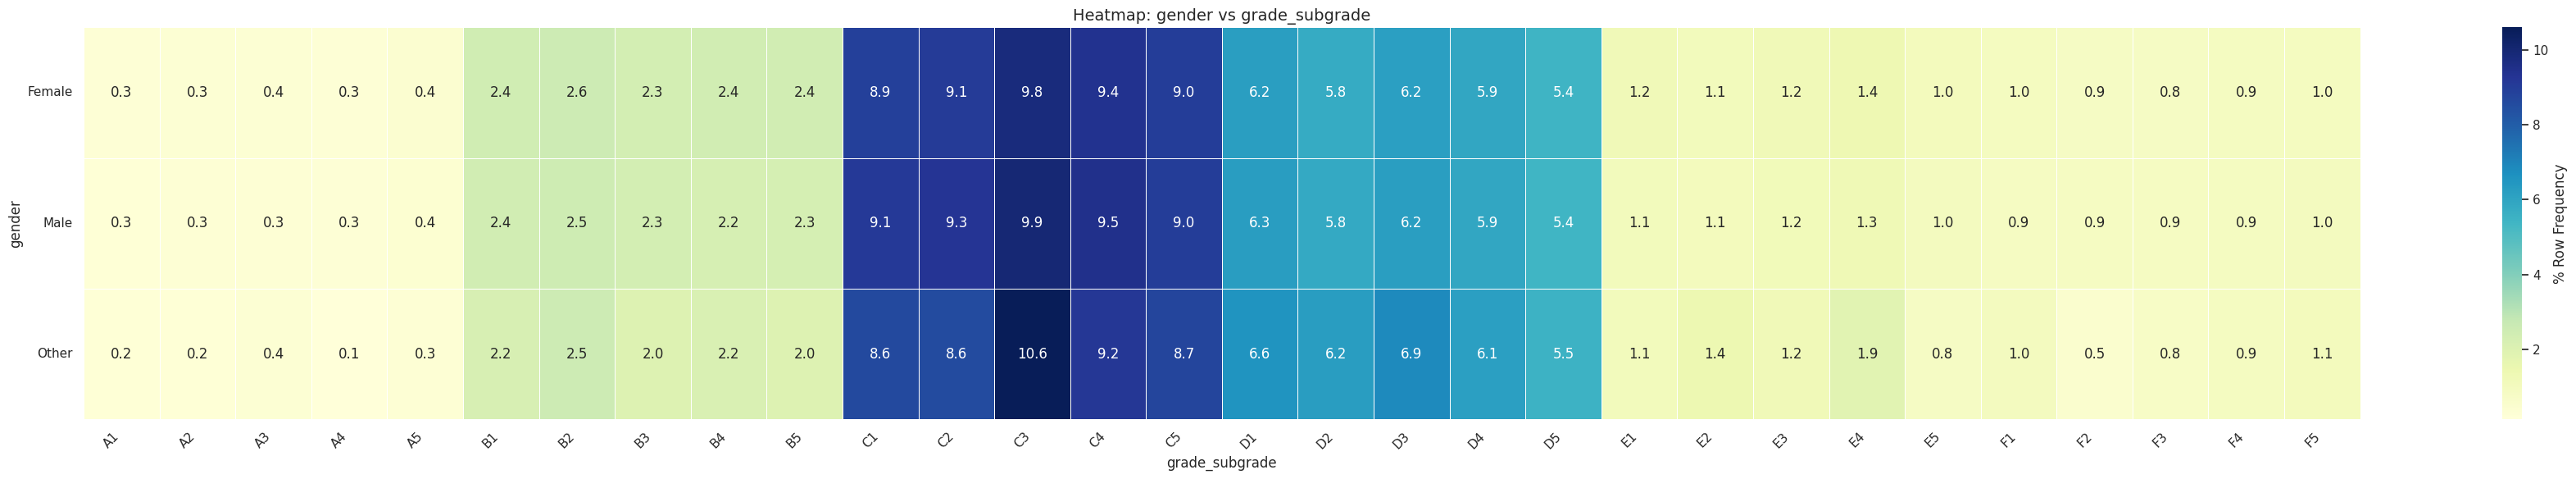

Categorical vs Categorical: marital_status  ×  education_level

 Crosstab (Counts):

education_level  Bachelor's  High School  Master's  Other   PhD
marital_status                                                 
Divorced              10129         6459      3287   1030   407
Married              131992        85245     43107  12002  4893
Single               134306        89996     45647  13293  5601
Widowed                3179         1892      1056    352   121

 Crosstab (% by row):

education_level  Bachelor's  High School  Master's  Other   PhD
marital_status                                                 
Divorced              47.53        30.31     15.42   4.83  1.91
Married               47.61        30.75     15.55   4.33  1.76
Single                46.50        31.16     15.80   4.60  1.94
Widowed               48.17        28.67     16.00   5.33  1.83


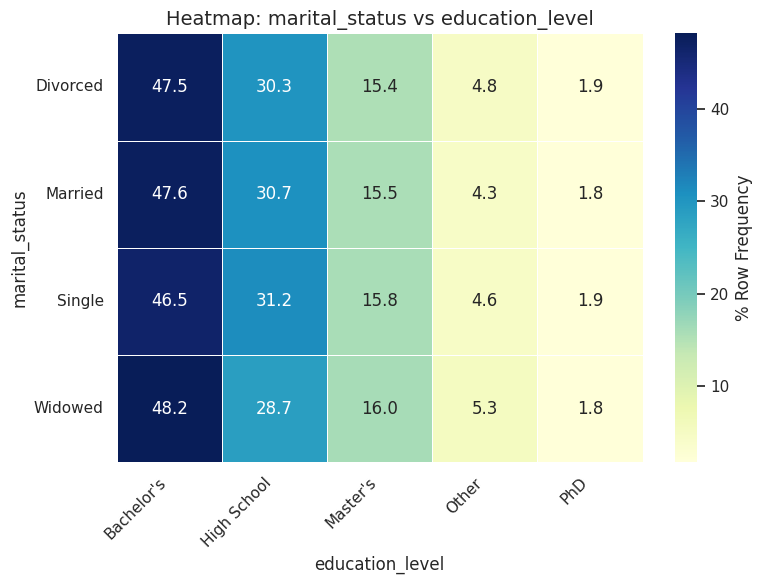

Categorical vs Categorical: marital_status  ×  employment_status

 Crosstab (Counts):

employment_status  Employed  Retired  Self-employed  Student  Unemployed
marital_status                                                          
Divorced              16261      563           1872      429        2187
Married              210079     7989          25016     5488       28667
Single               219241     7762          25066     5861       30913
Widowed                5064      139            526      153         718

 Crosstab (% by row):

employment_status  Employed  Retired  Self-employed  Student  Unemployed
marital_status                                                          
Divorced              76.30     2.64           8.78     2.01       10.26
Married               75.78     2.88           9.02     1.98       10.34
Single                75.90     2.69           8.68     2.03       10.70
Widowed               76.73     2.11           7.97     2.32       10.88


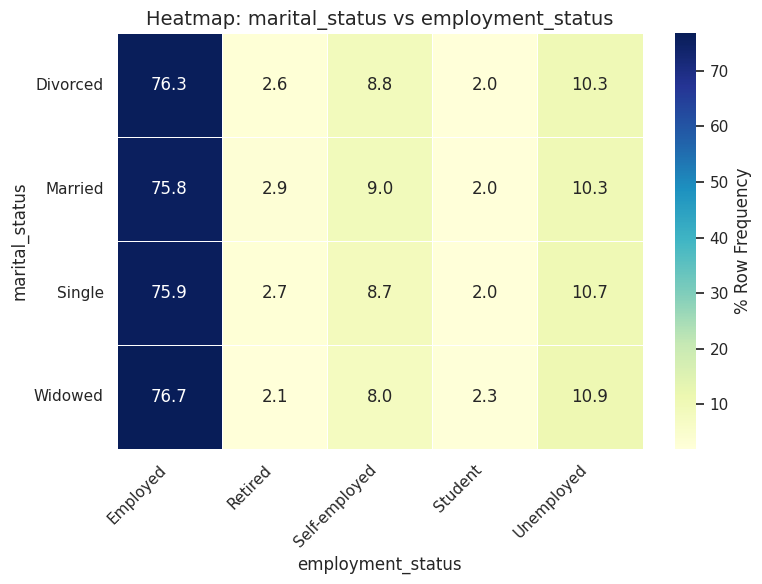

Categorical vs Categorical: marital_status  ×  loan_purpose

 Crosstab (Counts):

loan_purpose    Business    Car  Debt consolidation  Education   Home  \
marital_status                                                          
Divorced            1271   2110               12187       1277   1161   
Married            16622  26974              151834      17197  20603   
Single             17002  28344              156985      17757  21943   
Widowed              408    680                3689        410    411   

loan_purpose    Medical  Other  Vacation  
marital_status                            
Divorced            844   2205       257  
Married           10585  29447      3977  
Single            11150  31514      4148  
Widowed             227    708        67  

 Crosstab (% by row):

loan_purpose    Business    Car  Debt consolidation  Education  Home  Medical  \
marital_status                                                                  
Divorced            5.96   9.90    

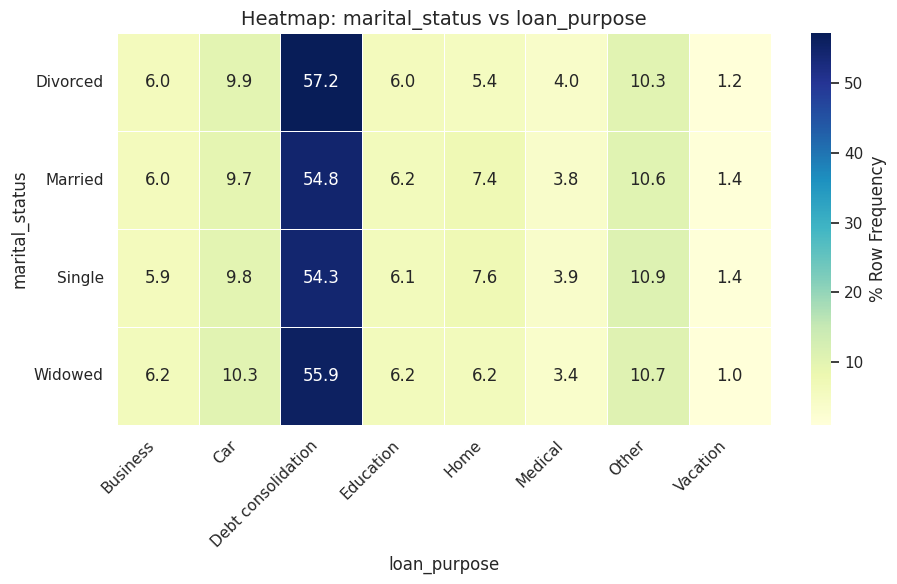

Categorical vs Categorical: marital_status  ×  grade_subgrade

 Crosstab (Counts):

grade_subgrade   A1    A2    A3   A4    A5    B1    B2    B3    B4    B5  ...  \
marital_status                                                            ...   
Divorced         43    66    57   42    84   470   524   469   437   459  ...   
Married         734   880   887  773  1036  6791  7178  6633  6624  6564  ...   
Single          808  1055  1100  870  1322  6927  7314  6695  6661  6745  ...   
Widowed          15    17    22   16    29   156   151   129   155   169  ...   

grade_subgrade    E1    E2    E3    E4    E5    F1    F2    F3    F4    F5  
marital_status                                                              
Divorced         216   214   256   297   238   157   174   176   189   213  
Married         3273  2978  3238  3812  2800  2580  2423  2374  2521  2736  
Single          3328  3110  3497  3833  2974  2759  2552  2483  2781  2930  
Widowed           74    70    84    94    72

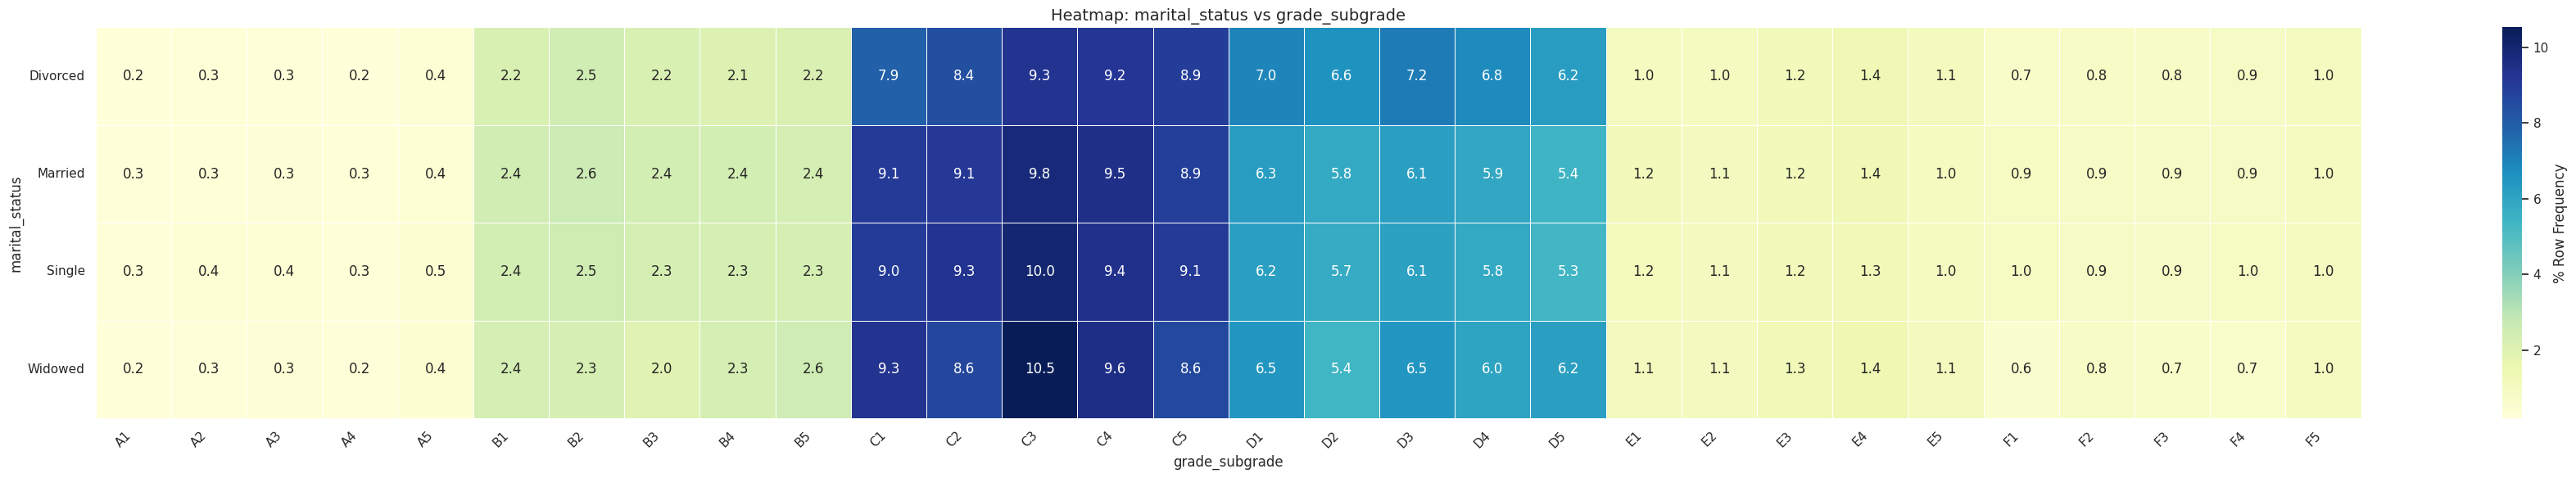

Categorical vs Categorical: education_level  ×  employment_status

 Crosstab (Counts):

employment_status  Employed  Retired  Self-employed  Student  Unemployed
education_level                                                         
Bachelor's           210779     7461          24441     5747       31178
High School          140074     5494          16238     3638       18148
Master's              70970     2319           8410     1885        9513
Other                 20361      757           2400      481        2678
PhD                    8461      422            991      180         968

 Crosstab (% by row):

employment_status  Employed  Retired  Self-employed  Student  Unemployed
education_level                                                         
Bachelor's            75.38     2.67           8.74     2.06       11.15
High School           76.30     2.99           8.84     1.98        9.88
Master's              76.23     2.49           9.03     2.02       10.22
Other       

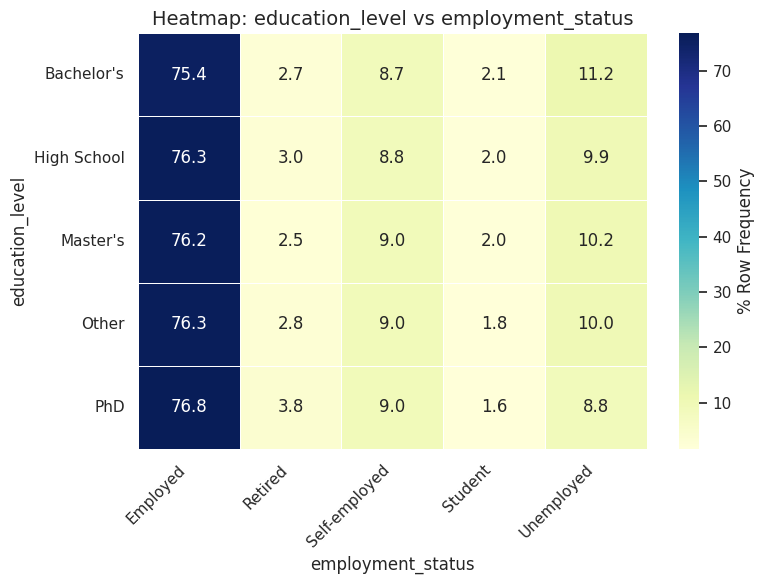

Categorical vs Categorical: education_level  ×  loan_purpose

 Crosstab (Counts):

loan_purpose     Business    Car  Debt consolidation  Education   Home  \
education_level                                                          
Bachelor's          16726  27223              151777      18005  20920   
High School         10852  17738              100896      10867  13453   
Master's             5333   9474               51057       5624   7109   
Other                1618   2860               14612       1498   1929   
PhD                   774    813                6353        647    707   

loan_purpose     Medical  Other  Vacation  
education_level                            
Bachelor's         10915  30002      4038  
High School         7015  20003      2768  
Master's            3477   9837      1186  
Other               1001   2818       341  
PhD                  398   1214       116  

 Crosstab (% by row):

loan_purpose     Business    Car  Debt consolidation  Education  H

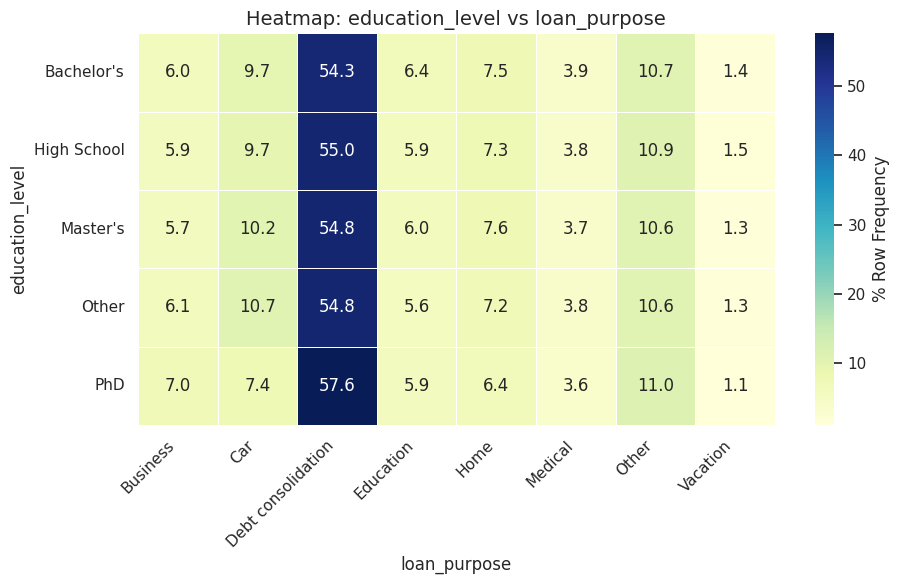

Categorical vs Categorical: education_level  ×  grade_subgrade

 Crosstab (Counts):

grade_subgrade    A1   A2   A3   A4    A5    B1    B2    B3    B4    B5  ...  \
education_level                                                          ...   
Bachelor's       779  941  975  804  1183  6742  6952  6569  6336  6646  ...   
High School      453  587  620  484   709  4430  4725  4378  4396  4270  ...   
Master's         255  340  336  281   406  2239  2413  2055  2251  2116  ...   
Other             74   90   84   82   117   695   767   662   645   635  ...   
PhD               39   60   51   50    56   238   310   262   249   270  ...   

grade_subgrade     E1    E2    E3    E4    E5    F1    F2    F3    F4    F5  
education_level                                                              
Bachelor's       3273  2953  3353  3808  2946  2704  2408  2333  2597  2786  
High School      2073  1964  2138  2455  1776  1705  1626  1580  1706  1776  
Master's         1125  1074  1125  1308   

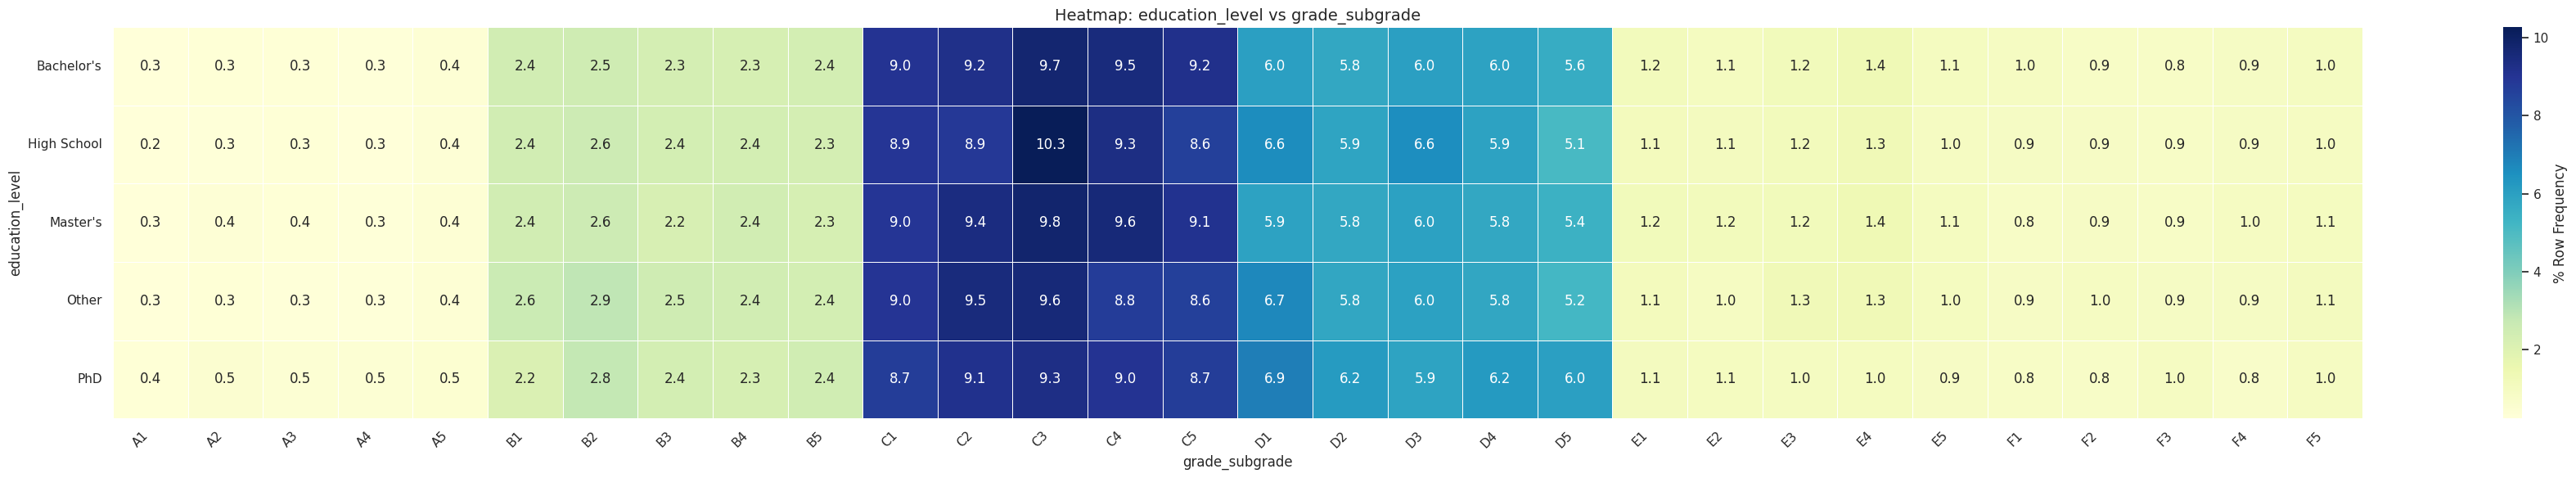

Categorical vs Categorical: employment_status  ×  loan_purpose

 Crosstab (Counts):

loan_purpose       Business    Car  Debt consolidation  Education   Home  \
employment_status                                                          
Employed              27226  43548              246853      27222  34279   
Retired                1069   1744                8628       1017   1328   
Self-employed          2986   5529               28180       3332   3728   
Student                 703   1214                6418        817    941   
Unemployed             3319   6073               34616       4253   3842   

loan_purpose       Medical  Other  Vacation  
employment_status                            
Employed             16673  48351      6493  
Retired                643   1844       180  
Self-employed         2315   5740       670  
Student                507   1187       144  
Unemployed            2668   6752       962  

 Crosstab (% by row):

loan_purpose       Business    Car  

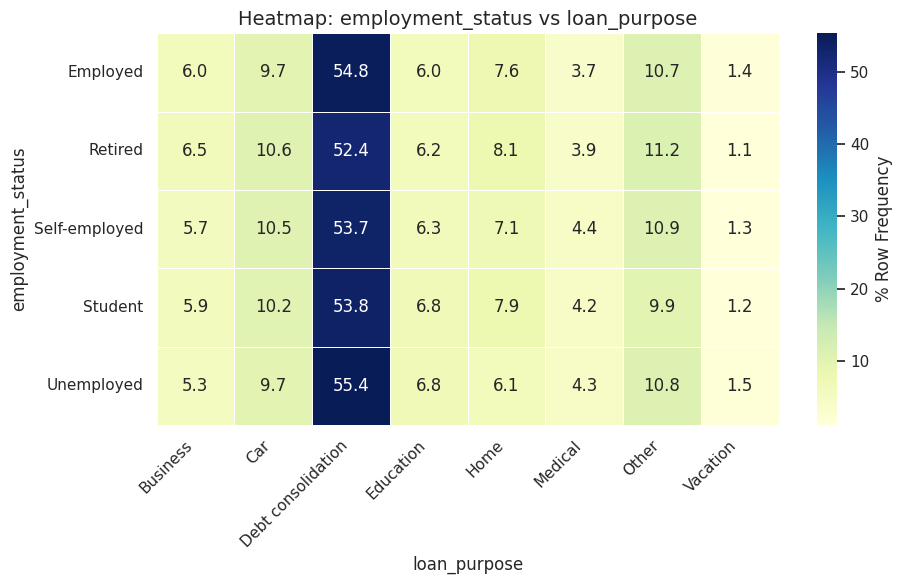

Categorical vs Categorical: employment_status  ×  grade_subgrade

 Crosstab (Counts):

grade_subgrade       A1    A2    A3    A4    A5     B1     B2     B3     B4  \
employment_status                                                             
Employed           1292  1647  1685  1402  1993  11133  12003  11023  10824   
Retired              38    67    66    43    66    479    530    438    451   
Self-employed       143   159   157   145   220   1462   1523   1409   1428   
Student              16    22    28    15    30    216    194    189    236   
Unemployed          111   123   130    96   162   1054    917    867    938   

grade_subgrade        B5  ...    E1    E2    E3    E4    E5    F1    F2    F3  \
employment_status         ...                                                   
Employed           10880  ...  4943  4658  5072  5896  4355  4013  3877  3691   
Retired              521  ...   125   133   138   168   161   108   114   115   
Self-employed       1456  ...   581

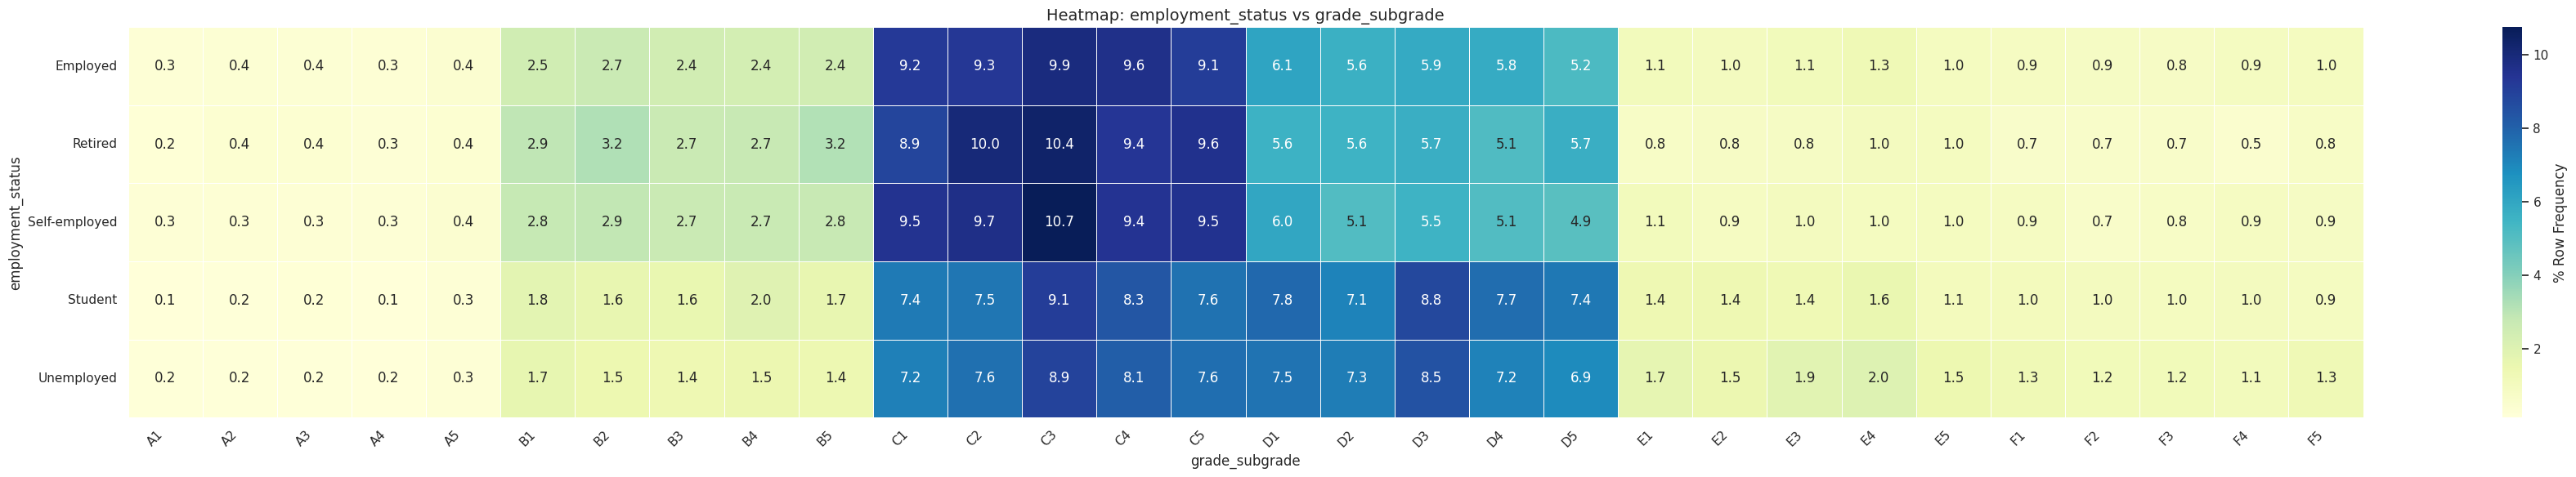

Categorical vs Categorical: loan_purpose  ×  grade_subgrade

 Crosstab (Counts):

grade_subgrade       A1    A2    A3   A4    A5    B1    B2    B3    B4    B5  \
loan_purpose                                                                   
Business             94   135   138   92   134   867   981   904   899   856   
Car                 137   191   198  180   232  1477  1506  1373  1353  1370   
Debt consolidation  872  1102  1109  960  1358  7805  8310  7621  7685  7452   
Education            80   105   117   85   109   822   864   809   814   859   
Home                142   171   177  128   191  1133  1209  1073  1007  1100   
Medical              59    54    76   47    87   515   525   495   522   559   
Other               187   230   221  182   319  1510  1587  1465  1421  1563   
Vacation             29    30    30   27    41   215   185   186   176   178   

grade_subgrade      ...    E1    E2    E3    E4    E5    F1    F2    F3    F4  \
loan_purpose        ...             

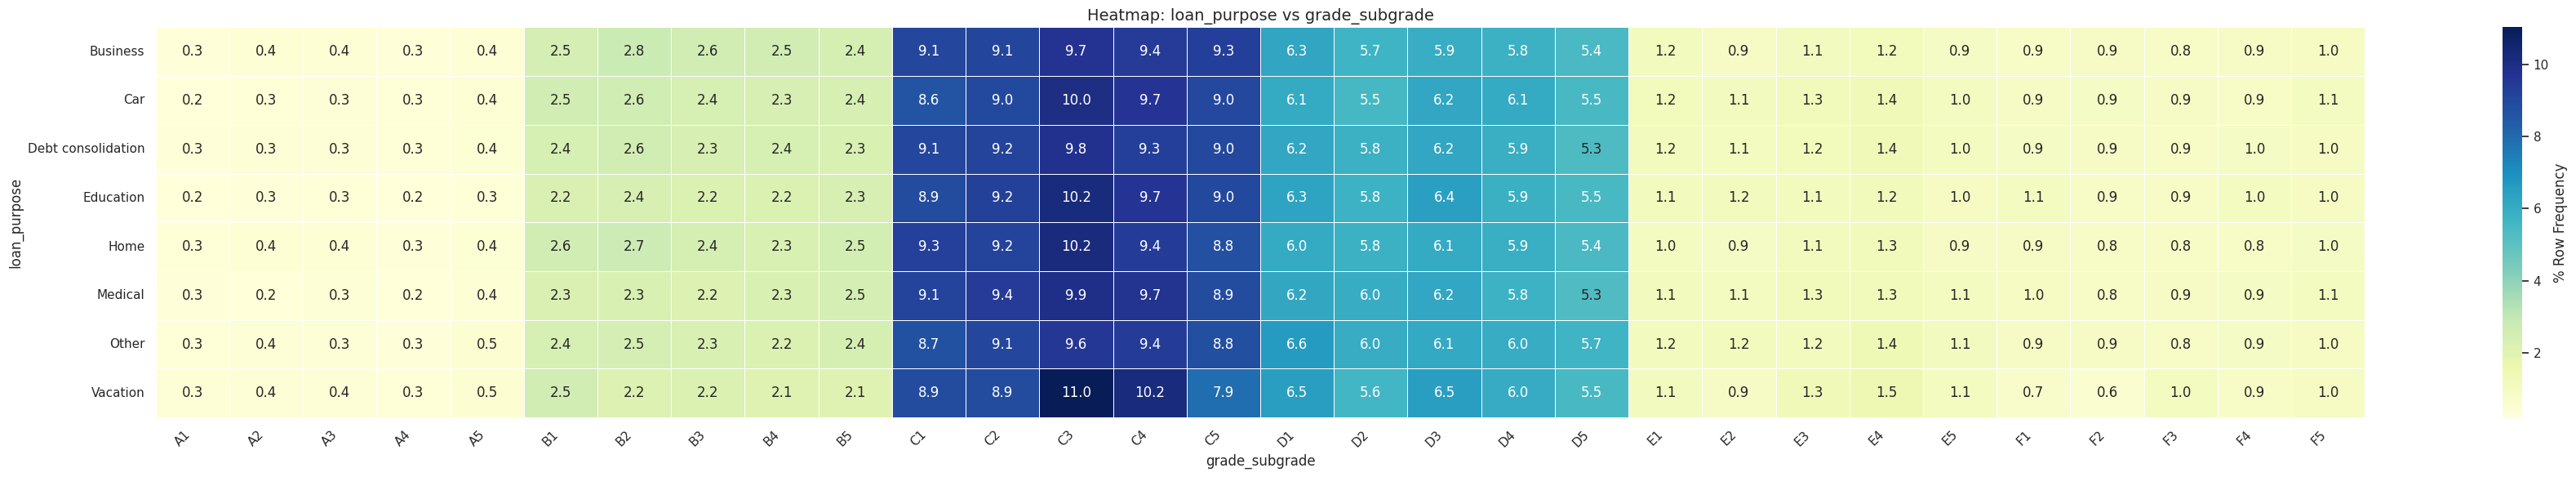

In [20]:

for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):

        col1 = cat_cols[i]
        col2 = cat_cols[j]

        print("="*80)
        print(f"Categorical vs Categorical: {col1}  ×  {col2}")
        print("="*80)

        # -------------------------------
        # CROSSTAB (counts)
        # -------------------------------
        ct = pd.crosstab(train[col1], train[col2])
        print("\n Crosstab (Counts):\n")
        print(ct)

        # -------------------------------
        # CROSSTAB (percentage row-wise)
        # -------------------------------
        ct_pct = pd.crosstab(train[col1], train[col2], normalize="index") * 100
        print("\n Crosstab (% by row):\n")
        print(ct_pct.round(2))

        # -------------------------------
        # HEATMAP (counts or %)
        # -------------------------------
        plt.figure(figsize=(max(8, ct.shape[1] * 1.2), max(6, ct.shape[0] * 0.7)))

        sns.heatmap(
            ct_pct,
            cmap="YlGnBu",
            annot=True,
            fmt=".1f",
            linewidths=0.5,
            cbar_kws={"label": "% Row Frequency"}
        )

        plt.title(f"Heatmap: {col1} vs {col2}", fontsize=14)
        plt.xlabel(col2, fontsize=12)
        plt.ylabel(col1, fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        plt.tight_layout()
        plt.show()

## Correlation Analysis


===== FAST CORRELATION ANALYSIS =====

Using sample of 5000 rows for correlation.



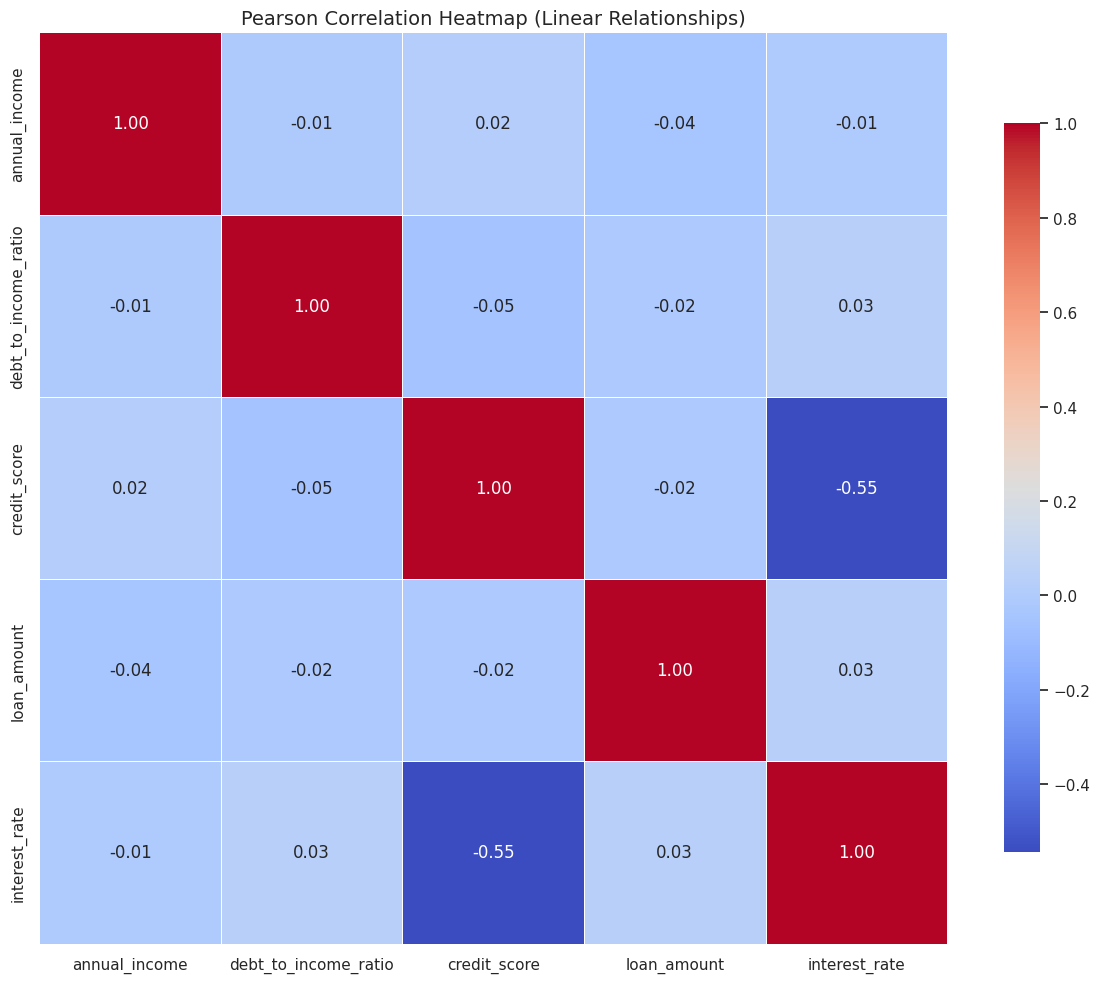

 Highly Correlated Feature Pairs (|corr| > 0.80):

None found.

 Suggested Redundant Features to Drop (if any):
None


Using top correlated features for Spearman: ['debt_to_income_ratio', 'credit_score', 'interest_rate', 'annual_income', 'loan_amount']



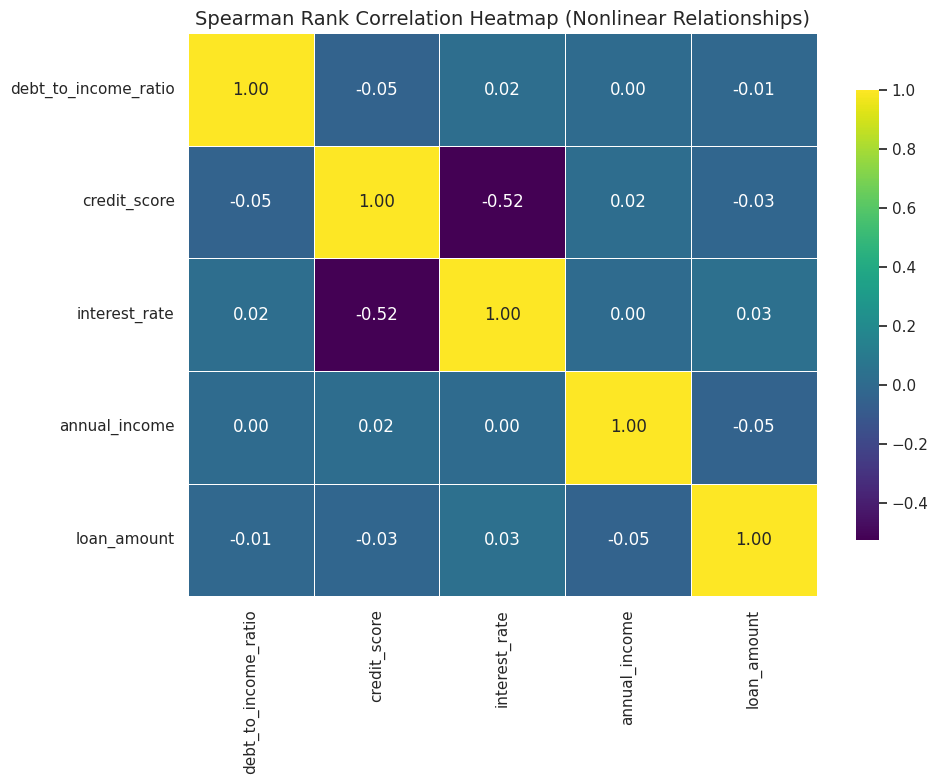

In [21]:
print("\n===== FAST CORRELATION ANALYSIS =====\n")

# -------------------------------------------------------
# SAMPLE THE DATA (5k rows is enough for correlation)
# -------------------------------------------------------
sample_size = min(5000, len(train))
df_corr = train.sample(sample_size, random_state=42)

# -------------------------------------------------------
# SELECT NUMERICAL COLUMNS
# -------------------------------------------------------
num_cols = df_corr.select_dtypes(include='number').columns.tolist()

# Remove ID + target
for drop in ["id", "loan_paid_back"]:
    if drop in num_cols:
        num_cols.remove(drop)

print(f"Using sample of {sample_size} rows for correlation.\n")

# -------------------------------------------------------
# PEARSON CORRELATION HEATMAP (with labels)
# -------------------------------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = df_corr[num_cols].corr(method='pearson')

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,              # <<< LABELS ADDED HERE
    fmt=".2f",               # round to 2 decimals
    linewidths=0.4,
    square=False,
    cbar_kws={'shrink': 0.8}
)

plt.title("Pearson Correlation Heatmap (Linear Relationships)", fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# IDENTIFY HIGHLY CORRELATED PAIRS
# -------------------------------------------------------
threshold = 0.80
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
               .stack()
               .reset_index()
               .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print(" Highly Correlated Feature Pairs (|corr| > 0.80):\n")
print(high_corr if not high_corr.empty else "None found.\n")

# -------------------------------------------------------
# REDUNDANT FEATURE SUGGESTION (FAST)
# -------------------------------------------------------
redundant_features = set(high_corr["Feature2"].tolist())

print(" Suggested Redundant Features to Drop (if any):")
print(list(redundant_features) if redundant_features else "None")
print("\n")

# -------------------------------------------------------
# SPEARMAN CORRELATION (ONLY ON TOP 10 FEATURES) — FAST
# -------------------------------------------------------
target = 'loan_paid_back'

top_corr_feats = (
    train[num_cols + [target]]
    .corr()[target]
    .abs()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

if target in top_corr_feats:
    top_corr_feats.remove(target)

print(f"Using top correlated features for Spearman: {top_corr_feats}\n")

plt.figure(figsize=(10, 8))
spearman_matrix = df_corr[top_corr_feats].corr(method='spearman')

sns.heatmap(
    spearman_matrix,
    cmap='viridis',
    annot=True,              # <<< LABELS ADDED HERE
    fmt=".2f",               # rounded labels
    linewidths=0.4,
    square=False,
    cbar_kws={'shrink': 0.8}
)

plt.title("Spearman Rank Correlation Heatmap (Nonlinear Relationships)", fontsize=14)
plt.tight_layout()
plt.show()


## Feature Interaction Analysis

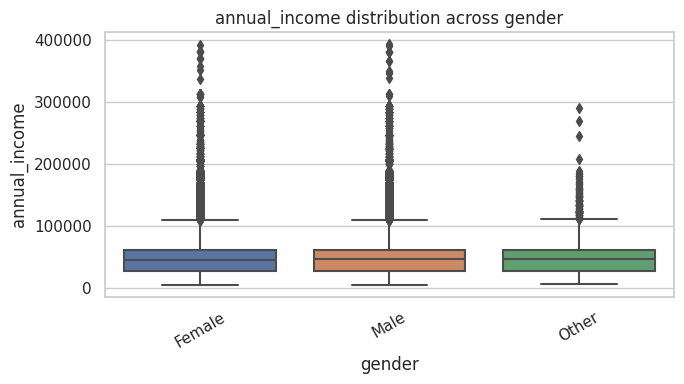


Target mean of loan_paid_back by gender for numerical variable annual_income:
gender
Female    48157.553022
Male      48254.334284
Other     49489.918737
Name: annual_income, dtype: float64




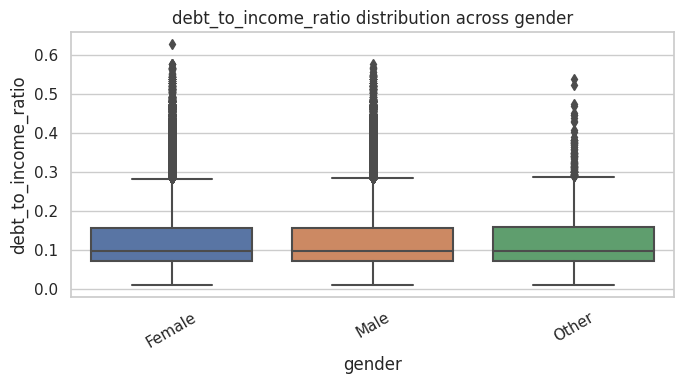


Target mean of loan_paid_back by gender for numerical variable debt_to_income_ratio:
gender
Female    0.120469
Male      0.120945
Other     0.120351
Name: debt_to_income_ratio, dtype: float64




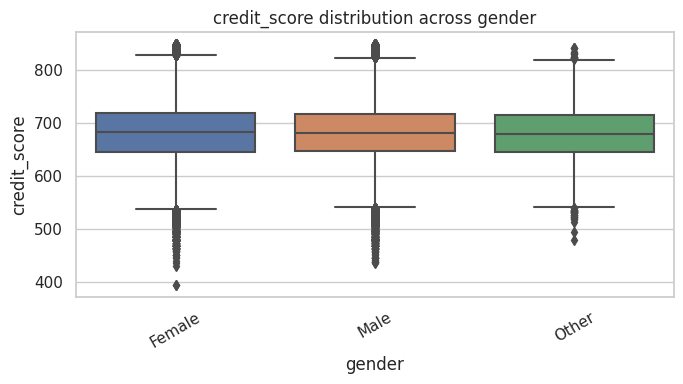


Target mean of loan_paid_back by gender for numerical variable credit_score:
gender
Female    681.156992
Male      680.691064
Other     678.266363
Name: credit_score, dtype: float64




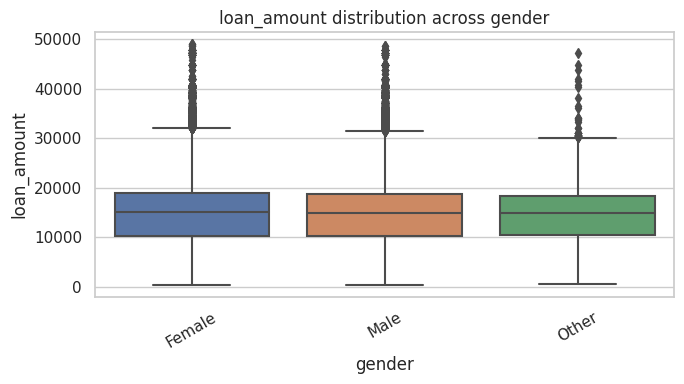


Target mean of loan_paid_back by gender for numerical variable loan_amount:
gender
Female    15043.360083
Male      14996.142716
Other     14966.930161
Name: loan_amount, dtype: float64




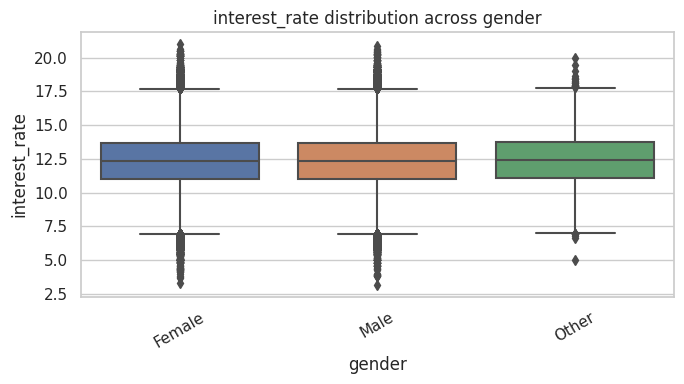


Target mean of loan_paid_back by gender for numerical variable interest_rate:
gender
Female    12.351112
Male      12.361240
Other     12.413077
Name: interest_rate, dtype: float64




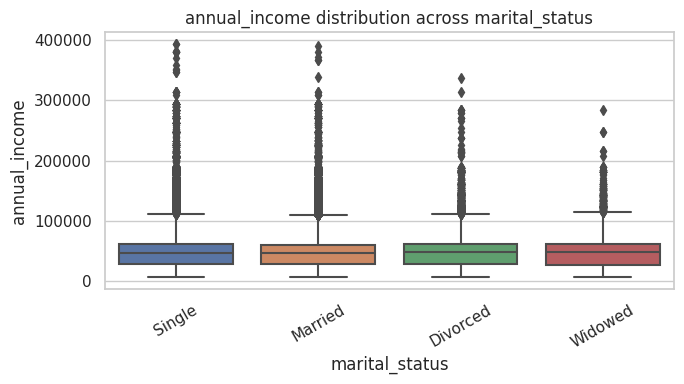


Target mean of loan_paid_back by marital_status for numerical variable annual_income:
marital_status
Divorced    49384.520245
Married     48060.529798
Single      48257.529539
Widowed     48814.177870
Name: annual_income, dtype: float64




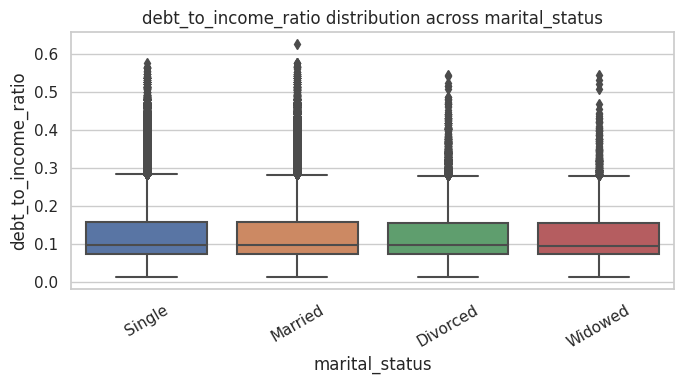


Target mean of loan_paid_back by marital_status for numerical variable debt_to_income_ratio:
marital_status
Divorced    0.120186
Married     0.120398
Single      0.121027
Widowed     0.120355
Name: debt_to_income_ratio, dtype: float64




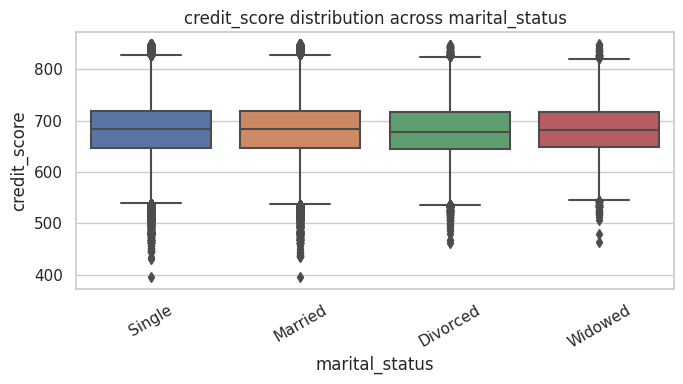


Target mean of loan_paid_back by marital_status for numerical variable credit_score:
marital_status
Divorced    677.906719
Married     680.941621
Single      681.122201
Widowed     680.533636
Name: credit_score, dtype: float64




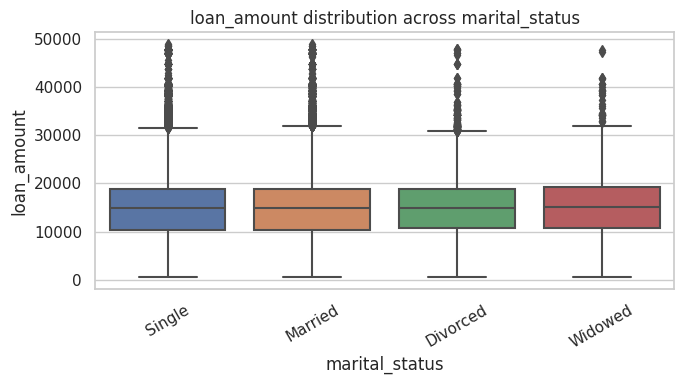


Target mean of loan_paid_back by marital_status for numerical variable loan_amount:
marital_status
Divorced    15026.177682
Married     15025.705801
Single      15009.646265
Widowed     15240.282427
Name: loan_amount, dtype: float64




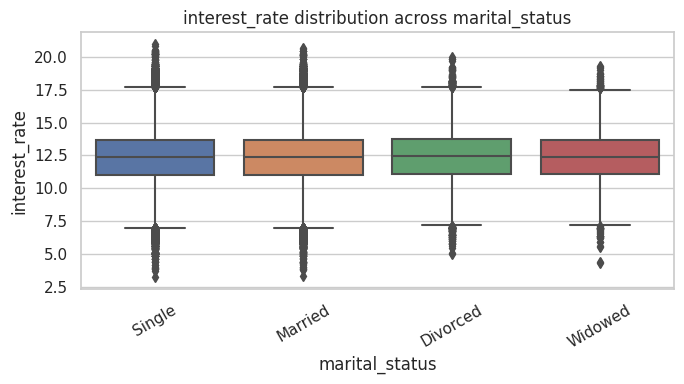


Target mean of loan_paid_back by marital_status for numerical variable interest_rate:
marital_status
Divorced    12.422980
Married     12.352245
Single      12.355219
Widowed     12.362703
Name: interest_rate, dtype: float64




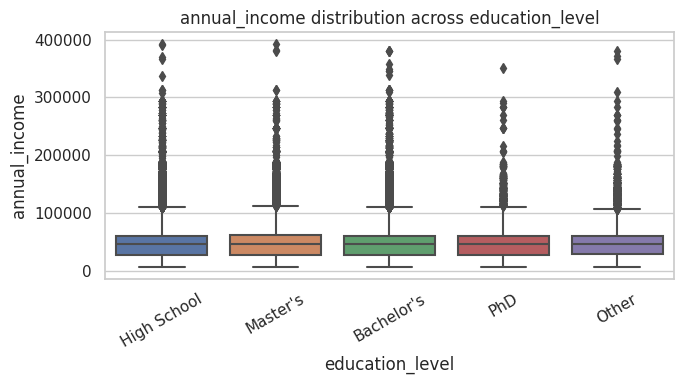


Target mean of loan_paid_back by education_level for numerical variable annual_income:
education_level
Bachelor's     48008.557607
High School    48363.002379
Master's       48551.229708
Other          48021.384428
PhD            48464.697812
Name: annual_income, dtype: float64




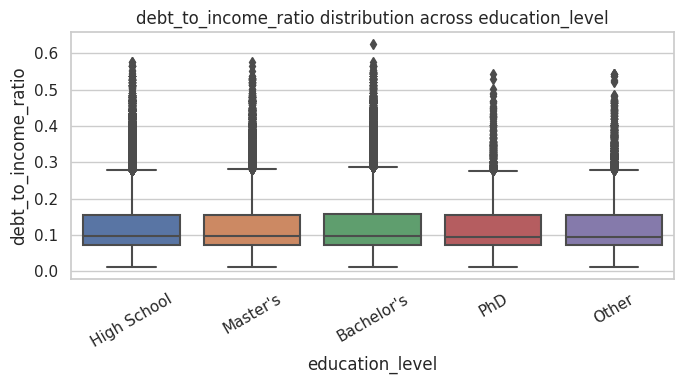


Target mean of loan_paid_back by education_level for numerical variable debt_to_income_ratio:
education_level
Bachelor's     0.121249
High School    0.120142
Master's       0.120486
Other          0.120000
PhD            0.119342
Name: debt_to_income_ratio, dtype: float64




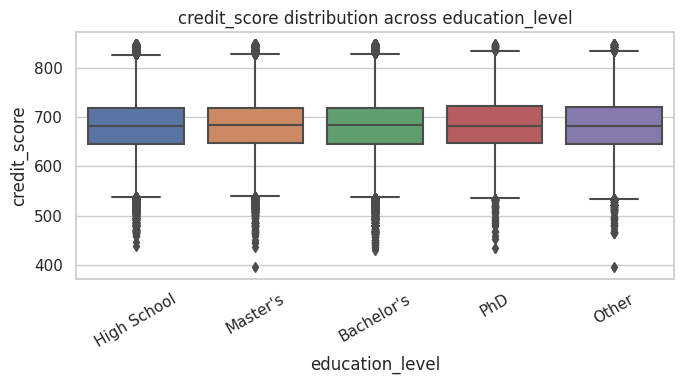


Target mean of loan_paid_back by education_level for numerical variable credit_score:
education_level
Bachelor's     680.922226
High School    680.628154
Master's       681.225303
Other          681.244293
PhD            682.146071
Name: credit_score, dtype: float64




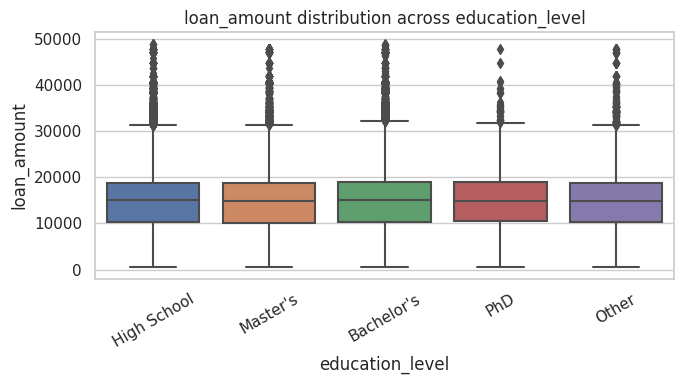


Target mean of loan_paid_back by education_level for numerical variable loan_amount:
education_level
Bachelor's     15062.142914
High School    15005.136349
Master's       14925.747290
Other          15012.426448
PhD            15028.973838
Name: loan_amount, dtype: float64




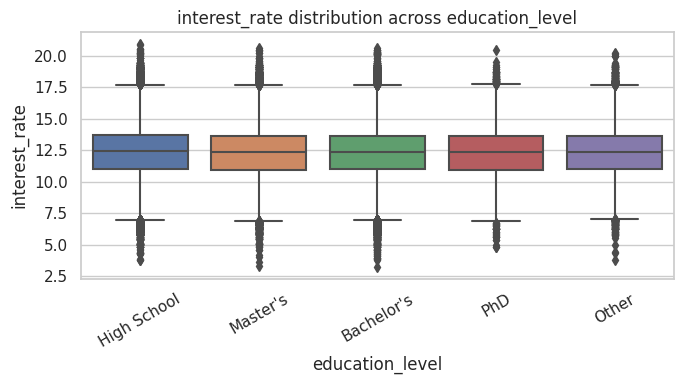


Target mean of loan_paid_back by education_level for numerical variable interest_rate:
education_level
Bachelor's     12.346641
High School    12.382408
Master's       12.333267
Other          12.362853
PhD            12.347592
Name: interest_rate, dtype: float64




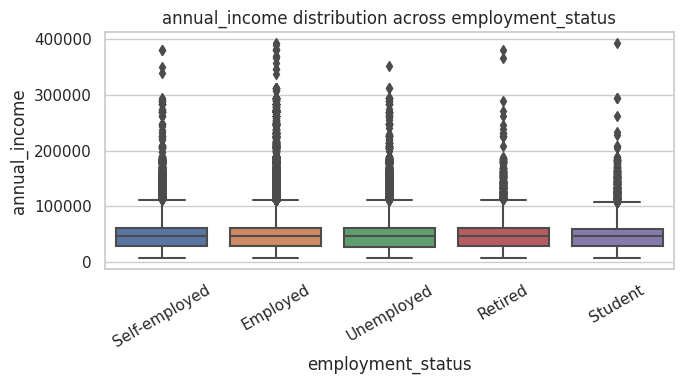


Target mean of loan_paid_back by employment_status for numerical variable annual_income:
employment_status
Employed         48219.161886
Retired          48725.043414
Self-employed    48176.665223
Student          48131.084873
Unemployed       48072.314680
Name: annual_income, dtype: float64




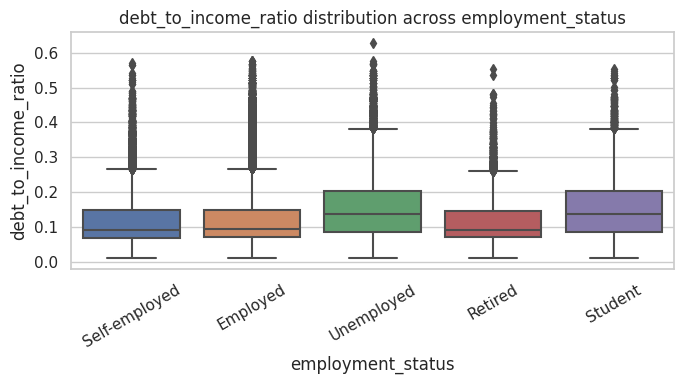


Target mean of loan_paid_back by employment_status for numerical variable debt_to_income_ratio:
employment_status
Employed         0.116399
Retired          0.112670
Self-employed    0.115100
Student          0.153157
Unemployed       0.152297
Name: debt_to_income_ratio, dtype: float64




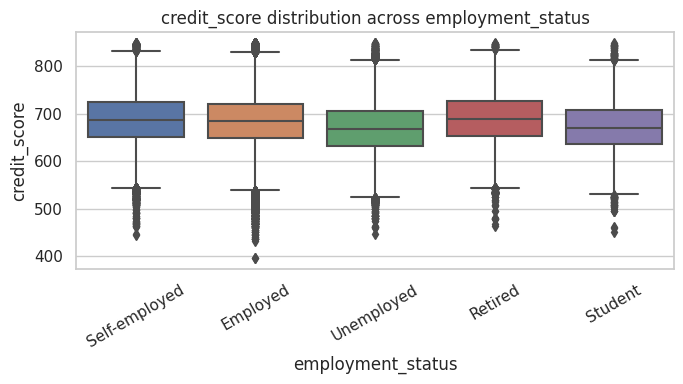


Target mean of loan_paid_back by employment_status for numerical variable credit_score:
employment_status
Employed         682.475827
Retired          687.580380
Self-employed    685.356250
Student          670.015254
Unemployed       666.263855
Name: credit_score, dtype: float64




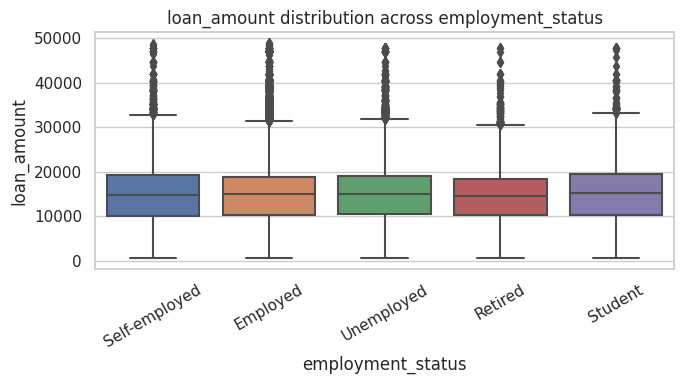


Target mean of loan_paid_back by employment_status for numerical variable loan_amount:
employment_status
Employed         15004.978559
Retired          14817.759138
Self-employed    15047.596659
Student          15290.327370
Unemployed       15109.622264
Name: loan_amount, dtype: float64




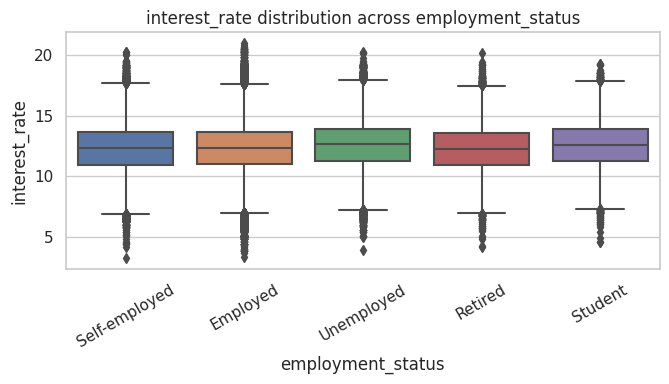


Target mean of loan_paid_back by employment_status for numerical variable interest_rate:
employment_status
Employed         12.325753
Retired          12.226009
Self-employed    12.297501
Student          12.590163
Unemployed       12.616073
Name: interest_rate, dtype: float64




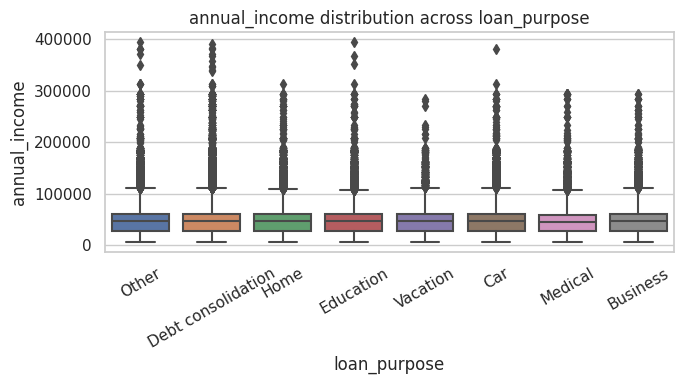


Target mean of loan_paid_back by loan_purpose for numerical variable annual_income:
loan_purpose
Business              48629.506464
Car                   48807.840777
Debt consolidation    48092.819008
Education             48071.635770
Home                  48516.663171
Medical               47476.108822
Other                 48150.313295
Vacation              48434.577700
Name: annual_income, dtype: float64




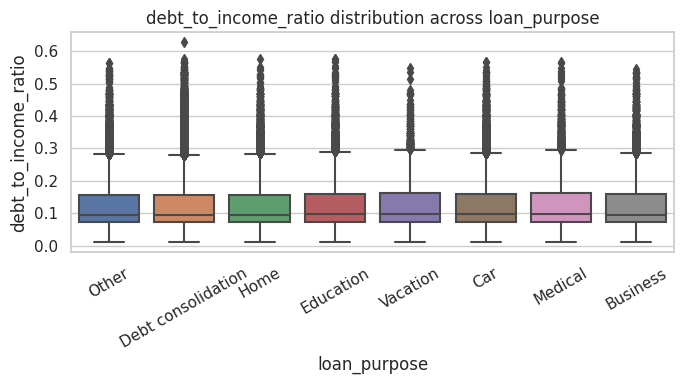


Target mean of loan_paid_back by loan_purpose for numerical variable debt_to_income_ratio:
loan_purpose
Business              0.121570
Car                   0.122231
Debt consolidation    0.119810
Education             0.122618
Home                  0.121126
Medical               0.122719
Other                 0.120841
Vacation              0.123377
Name: debt_to_income_ratio, dtype: float64




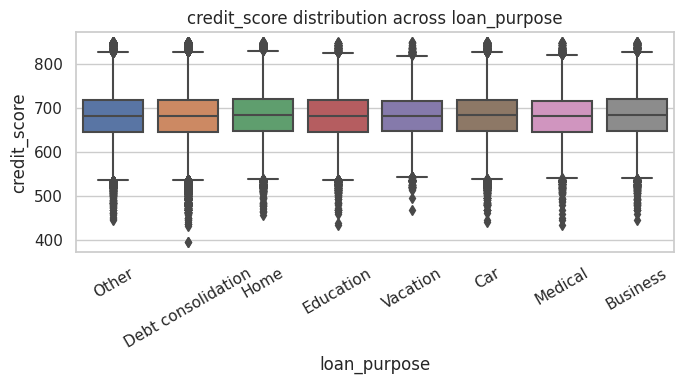


Target mean of loan_paid_back by loan_purpose for numerical variable credit_score:
loan_purpose
Business              682.194488
Car                   680.870982
Debt consolidation    680.937119
Education             679.675746
Home                  682.462034
Medical               679.866219
Other                 680.252247
Vacation              680.229968
Name: credit_score, dtype: float64




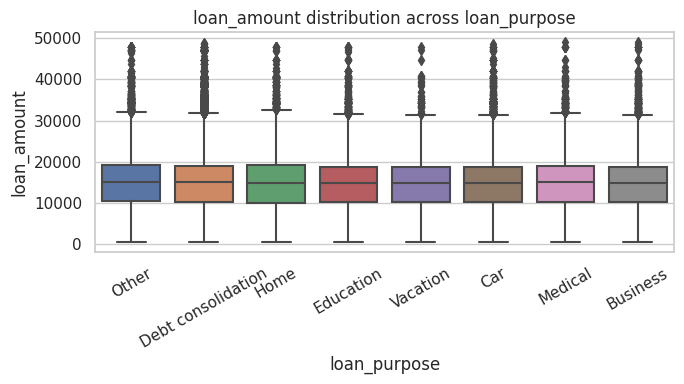


Target mean of loan_paid_back by loan_purpose for numerical variable loan_amount:
loan_purpose
Business              14928.274828
Car                   14886.041786
Debt consolidation    15058.305519
Education             14916.961356
Home                  14933.436416
Medical               15010.542406
Other                 15129.139350
Vacation              14972.701033
Name: loan_amount, dtype: float64




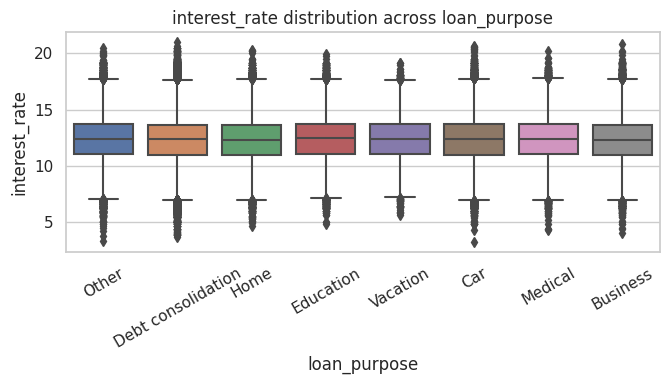


Target mean of loan_paid_back by loan_purpose for numerical variable interest_rate:
loan_purpose
Business              12.326180
Car                   12.359872
Debt consolidation    12.351140
Education             12.404153
Home                  12.317412
Medical               12.384738
Other                 12.380989
Vacation              12.391179
Name: interest_rate, dtype: float64




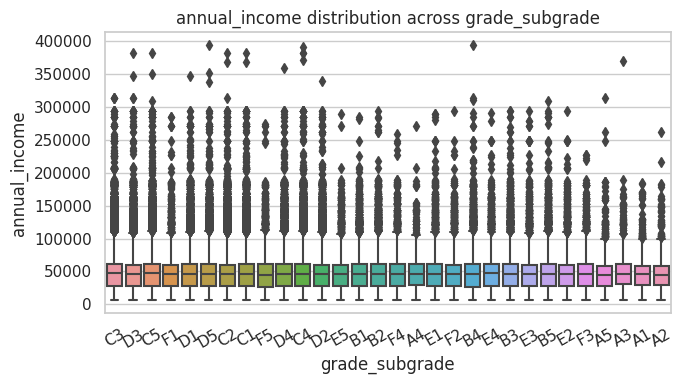


Target mean of loan_paid_back by grade_subgrade for numerical variable annual_income:
grade_subgrade
A1    47428.341181
A2    46735.376339
A3    48710.703374
A4    48594.540747
A5    47028.505265
B1    47868.788913
B2    48443.201132
B3    48624.579354
B4    47944.926450
B5    47785.952998
C1    48366.832271
C2    47852.630208
C3    48505.670922
C4    48323.860081
C5    48596.453362
D1    48438.710023
D2    47846.431922
D3    48085.513723
D4    48450.186016
D5    48045.868894
E1    48184.200792
E2    47518.820483
E3    48062.736823
E4    48403.887285
E5    47917.049809
F1    47920.230101
F2    47633.742006
F3    48429.311983
F4    48137.376636
F5    47182.418769
Name: annual_income, dtype: float64




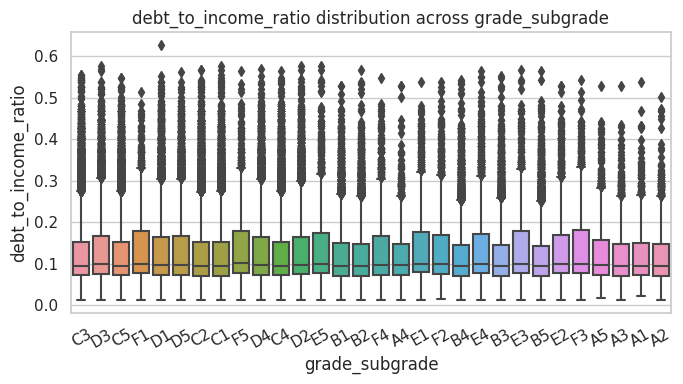


Target mean of loan_paid_back by grade_subgrade for numerical variable debt_to_income_ratio:
grade_subgrade
A1    0.118228
A2    0.117615
A3    0.117566
A4    0.118827
A5    0.122210
B1    0.116265
B2    0.115355
B3    0.113508
B4    0.113969
B5    0.113408
C1    0.117466
C2    0.118114
C3    0.118743
C4    0.118040
C5    0.118496
D1    0.123422
D2    0.123249
D3    0.125578
D4    0.124643
D5    0.124829
E1    0.130326
E2    0.127635
E3    0.129800
E4    0.128657
E5    0.129329
F1    0.129118
F2    0.127682
F3    0.131565
F4    0.124752
F5    0.130397
Name: debt_to_income_ratio, dtype: float64




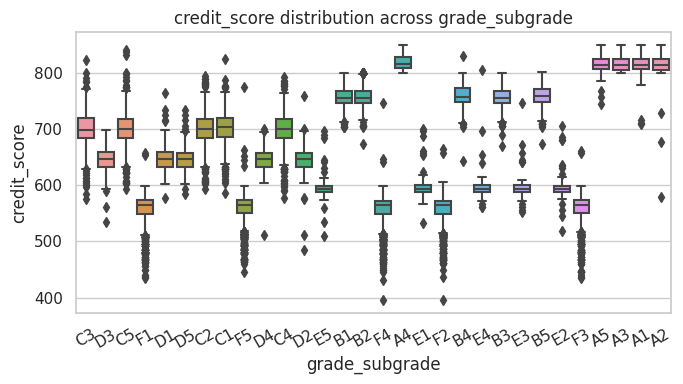


Target mean of loan_paid_back by grade_subgrade for numerical variable credit_score:
grade_subgrade
A1    816.643125
A2    816.397919
A3    816.264763
A4    818.126396
A5    816.197491
B1    759.075781
B2    758.985759
B3    758.907152
B4    760.068242
B5    760.343618
C1    702.838802
C2    701.498521
C3    701.070841
C4    701.600604
C5    701.468518
D1    644.665100
D2    644.426841
D3    645.201395
D4    644.839644
D5    644.892496
E1    594.090988
E2    593.711551
E3    594.301201
E4    594.634520
E5    593.584320
F1    557.985905
F2    558.252354
F3    559.597599
F4    557.910569
F5    559.496889
Name: credit_score, dtype: float64




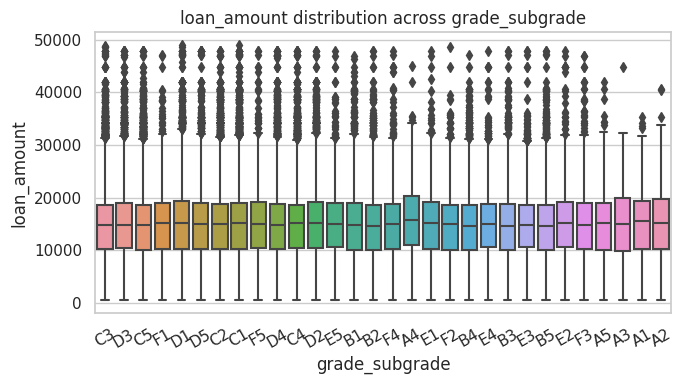


Target mean of loan_paid_back by grade_subgrade for numerical variable loan_amount:
grade_subgrade
A1    15137.965694
A2    15160.763459
A3    14963.409792
A4    15607.260964
A5    14934.749454
B1    14949.841631
B2    14893.152746
B3    14867.737021
B4    14841.707615
B5    14877.597926
C1    15115.366085
C2    15031.636765
C3    14915.501802
C4    15093.459236
C5    14853.235322
D1    15122.259556
D2    15217.027415
D3    15024.619968
D4    15014.587534
D5    15022.837008
E1    15099.747028
E2    15229.125252
E3    15020.061316
E4    15113.699425
E5    15130.192135
F1    15022.073048
F2    14868.259683
F3    14952.474469
F4    15000.159585
F5    15191.139163
Name: loan_amount, dtype: float64




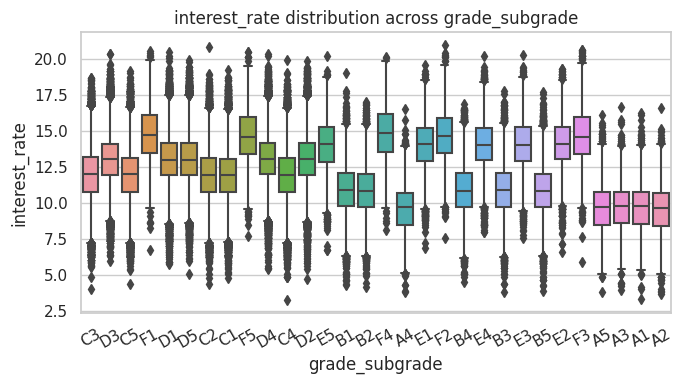


Target mean of loan_paid_back by grade_subgrade for numerical variable interest_rate:
grade_subgrade
A1     9.701287
A2     9.554172
A3     9.704458
A4     9.603269
A5     9.644605
B1    10.871043
B2    10.840729
B3    10.869445
B4    10.853632
B5    10.827640
C1    11.938518
C2    11.930821
C3    11.984689
C4    11.942240
C5    11.949878
D1    13.014395
D2    13.065354
D3    13.048852
D4    13.071492
D5    13.056403
E1    14.048704
E2    14.104912
E3    14.070311
E4    14.041630
E5    14.031681
F1    14.800963
F2    14.722360
F3    14.700897
F4    14.905868
F5    14.668539
Name: interest_rate, dtype: float64




In [22]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
target = "loan_paid_back"

for col in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(7,4))
        sns.boxplot(data=train, x=col, y=num)
        plt.title(f"{num} distribution across {col}")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

        # Target mean vs numerical value grouped by category
        print(f"\nTarget mean of {target} by {col} for numerical variable {num}:")
        print(train.groupby(col)[num].mean())
        print("\n")


## Outlier Analysis

OUTLIER ANALYSIS FOR: annual_income
Outlier Count: 15917
Outlier Percentage: 2.68%
IQR Lower Bound: -21635.98
IQR Upper Bound: 110551.70



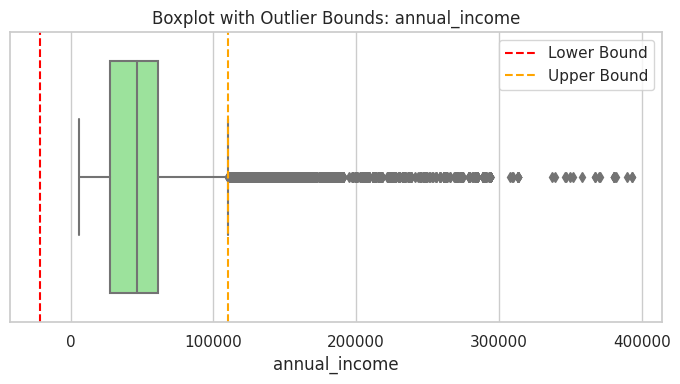

OUTLIER ANALYSIS FOR: debt_to_income_ratio
Outlier Count: 17556
Outlier Percentage: 2.96%
IQR Lower Bound: -0.05
IQR Upper Bound: 0.28



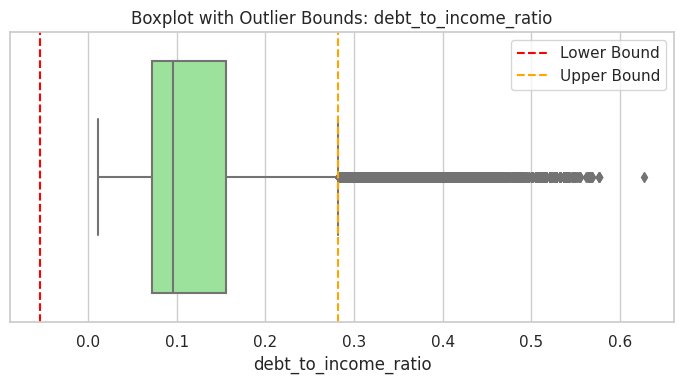

OUTLIER ANALYSIS FOR: credit_score
Outlier Count: 5901
Outlier Percentage: 0.99%
IQR Lower Bound: 536.50
IQR Upper Bound: 828.50



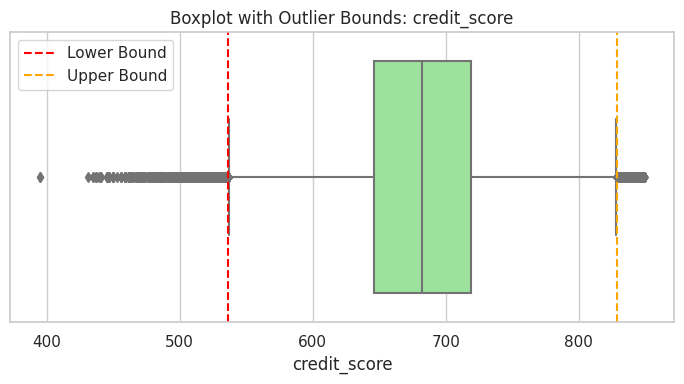

OUTLIER ANALYSIS FOR: loan_amount
Outlier Count: 2902
Outlier Percentage: 0.49%
IQR Lower Bound: -2588.82
IQR Upper Bound: 31727.02



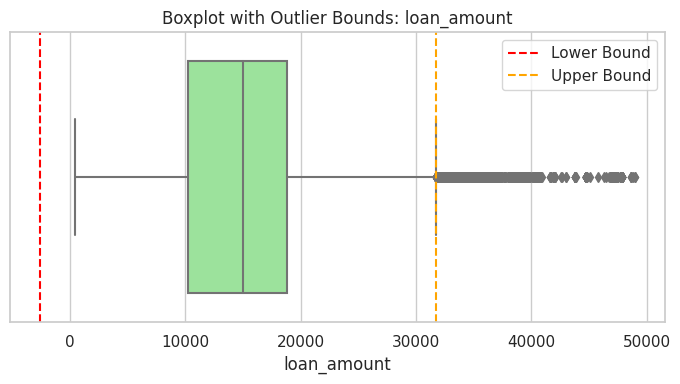

OUTLIER ANALYSIS FOR: interest_rate
Outlier Count: 5136
Outlier Percentage: 0.86%
IQR Lower Bound: 6.96
IQR Upper Bound: 17.71



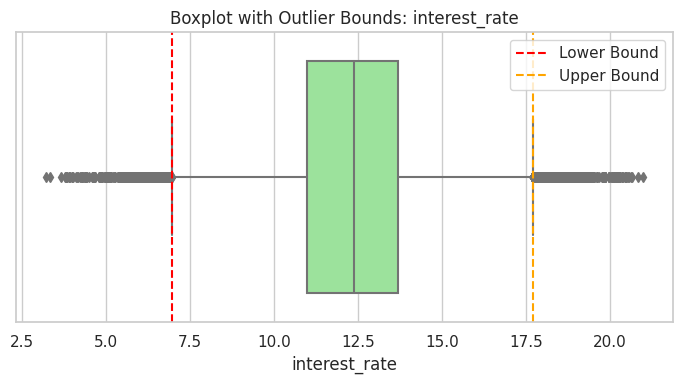


====== OUTLIER SUMMARY TABLE ======
                Feature  Outliers (%)  Lower Bound  Upper Bound
0         annual_income          2.68    -21635.98    110551.70
1  debt_to_income_ratio          2.96        -0.05         0.28
2          credit_score          0.99       536.50       828.50
3           loan_amount          0.49     -2588.82     31727.02
4         interest_rate          0.86         6.96        17.72


In [23]:
num_cols = train.select_dtypes(include="number").columns.tolist()

# Remove id + target
for drop in ["id", "loan_paid_back"]:
    if drop in num_cols:
        num_cols.remove(drop)

outlier_summary = []

for col in num_cols:
    print("="*70)
    print(f"OUTLIER ANALYSIS FOR: {col}")
    print("="*70)

    # ------------------------------
    # Detect outliers using IQR
    # ------------------------------
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = train[(train[col] < lower) | (train[col] > upper)][col]
    outlier_count = outliers.count()
    outlier_pct = (outlier_count / len(train)) * 100

    print(f"Outlier Count: {outlier_count}")
    print(f"Outlier Percentage: {outlier_pct:.2f}%")
    print(f"IQR Lower Bound: {lower:.2f}")
    print(f"IQR Upper Bound: {upper:.2f}\n")

    # ------------------------------
    # Save summary for final table
    # ------------------------------
    outlier_summary.append({
        "Feature": col,
        "Outliers (%)": round(outlier_pct, 2),
        "Lower Bound": round(lower, 2),
        "Upper Bound": round(upper, 2),
    })

    # ------------------------------
    # Plot boxplot with boundaries
    # ------------------------------
    plt.figure(figsize=(7,4))
    sns.boxplot(x=train[col], color="#90EE90")
    plt.axvline(lower, color='red', linestyle='--', label="Lower Bound")
    plt.axvline(upper, color='orange', linestyle='--', label="Upper Bound")
    plt.title(f"Boxplot with Outlier Bounds: {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------
# Outlier Summary Table
# ------------------------------
import pandas as pd
outlier_df = pd.DataFrame(outlier_summary)
print("\n====== OUTLIER SUMMARY TABLE ======")
print(outlier_df)

## Multicollinearity Check

In [24]:
print("\n===== MULTICOLLINEARITY CHECK =====\n")

# -------------------------------------------------------
# SAMPLE FOR SPEED
# -------------------------------------------------------
sample_size = min(5000, len(train))
df_corr = train.sample(sample_size, random_state=42)

# -------------------------------------------------------
# SELECT NUMERICAL COLUMNS
# -------------------------------------------------------
num_cols = df_corr.select_dtypes(include="number").columns.tolist()

# Remove ID + target
for drop in ["id", "loan_paid_back"]:
    if drop in num_cols:
        num_cols.remove(drop)

# -------------------------------------------------------
# CORRELATION > 0.85 (REDUNDANT FEATURES)
# -------------------------------------------------------
corr_matrix = df_corr[num_cols].corr()

# Find highly correlated pairs
threshold = 0.85
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 1).astype(bool))
               .stack()
               .reset_index()
               .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print(" Highly Correlated Pairs (|corr| > 0.85):\n")
print(high_corr if not high_corr.empty else "None found.")
print("\n")

# Proposed redundant features (drop second feature in each pair)
redundant_from_corr = list(high_corr["Feature2"].unique())

print(" Suggested Redundant Features (Correlation > 0.85):")
print(redundant_from_corr if redundant_from_corr else "None")
print("\n")

# -------------------------------------------------------
# VIF — VARIANCE INFLATION FACTOR
# -------------------------------------------------------
print(" VIF Analysis (Variance Inflation Factor):\n")

# Prepare dataframe for VIF
X = df_corr[num_cols].copy()
X = X.dropna()

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df, "\n")

# -------------------------------------------------------
# REMOVE FEATURES WITH VIF > 10
# -------------------------------------------------------
high_vif = vif_df[vif_df["VIF"] > 10]["Feature"].tolist()

print(" Features With High VIF (> 10):")
print(high_vif if high_vif else "None")
print("\n")


===== MULTICOLLINEARITY CHECK =====

 Highly Correlated Pairs (|corr| > 0.85):

None found.


 Suggested Redundant Features (Correlation > 0.85):
None


 VIF Analysis (Variance Inflation Factor):

                Feature        VIF
0         annual_income   4.374829
1  debt_to_income_ratio   4.125245
2          credit_score  26.263611
3           loan_amount   5.787047
4         interest_rate  22.556126 

 Features With High VIF (> 10):
['credit_score', 'interest_rate']




# Data Preprocessing 

In [25]:
train["is_train"] = 1
test["is_train"] = 0
test["loan_paid_back"] = np.nan
combined = pd.concat([train, test], ignore_index=True)
print("train_shape ",train.shape)
print("test_shape ",test.shape)
print("combined_shape ",combined.shape)
combined.head()

train_shape  (593994, 14)
test_shape  (254569, 14)
combined_shape  (848563, 14)


id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  is_train  
0               Other             C3             1.0         1  
1  Debt consolidation             D3             0.0         1  
2  Debt consolidation             C5             1.0         1  
3  Debt consolidation             F1             1.0         1  
4               Other             D1             1.0         1

In [26]:
# Identify columns
num_cols = combined.select_dtypes(include='number').columns.tolist()
cat_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove ID column (never impute)
if 'id' in num_cols:
    num_cols.remove('id')

# Remove target from numerical imputations
if 'loan_paid_back' in num_cols:
    num_cols.remove('loan_paid_back')

# -------------------------------------------------------
# Handle Rare Categories (1% threshold)
# -------------------------------------------------------
rare_threshold = 0.01  # 1%

for col in cat_cols:
    freq = combined[col].value_counts(normalize=True)
    rare_cats = freq[freq < rare_threshold].index.tolist()

    if rare_cats:
        combined[col] = combined[col].replace(rare_cats, "Other")
        print(f"Replaced rare categories in {col}: {rare_cats}")

# -------------------------------------------------------
# Numerical → median (combined median)
# -------------------------------------------------------
for col in num_cols:
    median_val = combined[col].median()
    combined[col].fillna(median_val, inplace=True)

# -------------------------------------------------------
# Categorical → mode (combined mode)
# -------------------------------------------------------
for col in cat_cols:
    mode_val = combined[col].mode()[0]
    combined[col].fillna(mode_val, inplace=True)

# -------------------------------------------------------
# Check remaining missing values
# -------------------------------------------------------
print("Missing values after unified imputation:\n")
print(combined.isnull().sum())


Replaced rare categories in gender: ['Other']
Replaced rare categories in grade_subgrade: ['F4', 'F1', 'F2', 'F3', 'A5', 'A3', 'A2', 'A4', 'A1']


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Missing values after unified imputation:

id                           0
annual_income                0
debt_to_income_ratio         0
credit_score                 0
loan_amount                  0
interest_rate                0
gender                       0
marital_status               0
education_level              0
employment_status            0
loan_purpose                 0
grade_subgrade               0
loan_paid_back          254569
is_train                     0
dtype: int64


In [27]:
combined.tail()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


id  annual_income  debt_to_income_ratio  credit_score  \
848558  848558       92835.97                 0.068           744   
848559  848559       48846.47                 0.091           634   
848560  848560       20668.52                 0.096           718   
848561  848561       34105.09                 0.094           739   
848562  848562       45627.53                 0.118           624   

        loan_amount  interest_rate  gender marital_status education_level  \
848558     29704.00          13.48  Female         Single      Bachelor's   
848559     20284.33           9.58  Female        Married     High School   
848560     26387.55           9.00    Male         Single        Master's   
848561     11107.36           9.81    Male         Single      Bachelor's   
848562     19246.14          11.64  Female        Married     High School   

       employment_status        loan_purpose grade_subgrade  loan_paid_back  \
848558          Employed  Debt consolidation             B2             NaN   
848559          Employed  Debt consolidation             D4             NaN   
848560          Employed  Debt consolidation             C4             NaN   
848561          Employed            Business             C2             NaN   
848562          Employed                 Car             D3             NaN   

        is_train  
848558         0  
848559         0  
848560         0  
848561         0  
848562         0

## Outlier Handling Rules (Feature-Specific)

In [28]:
# 1. annual_income
# - Negative values are invalid and should be replaced with the median.
# - Valid range is > 0.
# - Extremely high values may exist but should be capped using IQR.
# - Optionally create an outlier flag for values exceeding the IQR upper bound.

# 2. loan_amount
# - Negative loan amounts are invalid and should be replaced with the median.
# - Valid range is > 0.
# - Extremely high values are possible but should be capped using IQR.
# - Optionally create an outlier flag for values exceeding the IQR upper bound.

# 3. debt_to_income_ratio
# - Negative values are invalid and should be set to 0.
# - The typical range is 0 to 1, but values up to 2 may occur.
# - Values above 2 are generally unrealistic and should be clipped.
# - Values greater than 1 can be flagged as high-risk.

# 4. credit_score
# - The valid range is 300 to 900.
# - Values below 300 or above 900 are invalid and should be clipped.
# - Create an outlier flag for values originally outside the valid range.

# 5. interest_rate
# - Negative values are invalid and should be set to 0.
# - Realistic domain range is 0 to 50.
# - Values above 50 should be clipped.
# - A flag can be created for values originally outside the valid range.
# - The feature is often skewed, so log-transforming may be beneficial.




# Identify numerical columns for combined
num_cols = combined.select_dtypes(include='number').columns.tolist()

# Remove ID and target
for drop in ["id", "loan_paid_back"]:
    if drop in num_cols:
        num_cols.remove(drop)

# ============================================================
# annual_income Processing (Rule-based)
# ============================================================

median_income = combined["annual_income"].median()

# Flag negative values
combined["annual_income_invalid_flag"] = np.where(combined["annual_income"] < 0, 1, 0)
combined.loc[combined["annual_income"] < 0, "annual_income"] = median_income

# IQR capping
Q1 = combined["annual_income"].quantile(0.25)
Q3 = combined["annual_income"].quantile(0.75)
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR

combined["annual_income_outlier_flag"] = np.where(combined["annual_income"] > upper_cap, 1, 0)
combined["annual_income"] = np.clip(combined["annual_income"], 0, upper_cap)


# ============================================================
# loan_amount Processing (Rule-based)
# ============================================================

median_loan = combined["loan_amount"].median()

# Flag negative amounts
combined["loan_amount_invalid_flag"] = np.where(combined["loan_amount"] < 0, 1, 0)
combined.loc[combined["loan_amount"] < 0, "loan_amount"] = median_loan

# IQR capping
Q1 = combined["loan_amount"].quantile(0.25)
Q3 = combined["loan_amount"].quantile(0.75)
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR

combined["loan_amount_outlier_flag"] = np.where(combined["loan_amount"] > upper_cap, 1, 0)
combined["loan_amount"] = np.clip(combined["loan_amount"], 0, upper_cap)


# ============================================================
# debt_to_income_ratio Processing (Rule-based)
# ============================================================

# Flag negatives
combined["dti_invalid_flag"] = np.where(combined["debt_to_income_ratio"] < 0, 1, 0)

# Clip values to [0, 2]
combined["debt_to_income_ratio"] = combined["debt_to_income_ratio"].clip(0, 2)

# Flag high-risk DTI (>1)
combined["dti_high_flag"] = np.where(combined["debt_to_income_ratio"] > 1, 1, 0)


# ============================================================
# credit_score Processing (Rule-based)
# ============================================================

# Flag outside valid domain
combined["credit_score_invalid_flag"] = np.where(
    (combined["credit_score"] < 300) | (combined["credit_score"] > 900), 1, 0
)

# Clip to valid range
combined["credit_score"] = combined["credit_score"].clip(300, 900)


# ============================================================
# interest_rate Processing (Rule-based)
# ============================================================

# Flag invalid interest rates
combined["interest_rate_invalid_flag"] = np.where(
    (combined["interest_rate"] < 0) | (combined["interest_rate"] > 50), 1, 0
)

# Clip to valid range
combined["interest_rate"] = combined["interest_rate"].clip(0, 50)


In [29]:
combined.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back', 'is_train',
       'annual_income_invalid_flag', 'annual_income_outlier_flag',
       'loan_amount_invalid_flag', 'loan_amount_outlier_flag',
       'dti_invalid_flag', 'dti_high_flag', 'credit_score_invalid_flag',
       'interest_rate_invalid_flag'],
      dtype='object')

## Feature Engineering for Credit Risk

In [30]:
# =============================================================
# References:
# [R1] Löeffler & Posch – Credit Risk Modeling, Cambridge Univ Press
# [R2] Anderson – Credit Scoring & Its Applications
# [R3] Basel II/III Guidelines – Loan-to-Income, PD Models
# [R4] Federal Reserve – Consumer Credit Affordability Research
# [R5] Moody’s Analytics – Borrower Stress Indicator Research
# [R6] FICO – Score Reason Codes & Normalization Guidelines
# [R7] IMF – Loan Pricing & Default Modeling Framework
# [R8] Experian & TransUnion – Utilization × Score Risk Research
# =============================================================


# -----------------------------
# Affordability & Capacity
# -----------------------------
combined["income_loan_ratio"] = combined["annual_income"] / (combined["loan_amount"] + 1)      # R3
combined["loan_to_income_ratio"] = combined["loan_amount"] / (combined["annual_income"] + 1)    # R3
combined["affordability_index"] = (
    combined["annual_income"] /
    (combined["loan_amount"] * (1 + combined["interest_rate"]/100))
)                                                                                               # R7

# -----------------------------
# Pricing & Spread Indicators
# -----------------------------
combined["risk_margin"] = combined["interest_rate"] - (combined["credit_score"] / 100)          # R2
combined["interest_income_ratio"] = combined["interest_rate"] / (combined["annual_income"] + 1) # R4

# -----------------------------
# Stress & Leverage Indicators
# -----------------------------
combined["loan_interest_product"] = combined["loan_amount"] * combined["interest_rate"]          # R7
combined["dti_income_product"] = combined["debt_to_income_ratio"] * combined["annual_income"]    # R1
combined["stress_score"] = (
    combined["loan_amount"] *
    combined["interest_rate"] *
    combined["debt_to_income_ratio"]
)                                                                                               # R5

# -----------------------------
# Normalized & Transformed Features
# -----------------------------
combined["credit_score_norm"] = (combined["credit_score"] - 300) / 600                           # R6
combined["interest_rate_log"] = np.log1p(combined["interest_rate"])                              # R2

# -----------------------------
# Interaction Features
# -----------------------------
combined["score_interest_interaction"] = (
    combined["credit_score"] * combined["interest_rate"]
)                                                                                               # R7

combined["income_dti_interaction"] = (
    combined["annual_income"] * combined["debt_to_income_ratio"]
)                                                                                               # R8

combined["loan_dti_interaction"] = (
    combined["loan_amount"] * combined["debt_to_income_ratio"]
)                                                                                               # R1

# -----------------------------
# Utilization / Score Interaction
# -----------------------------
combined["credit_utilization_factor"] = (
    combined["debt_to_income_ratio"] * (900 - combined["credit_score"])
)                                                                                               # R8


In [31]:
combined.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back', 'is_train',
       'annual_income_invalid_flag', 'annual_income_outlier_flag',
       'loan_amount_invalid_flag', 'loan_amount_outlier_flag',
       'dti_invalid_flag', 'dti_high_flag', 'credit_score_invalid_flag',
       'interest_rate_invalid_flag', 'income_loan_ratio',
       'loan_to_income_ratio', 'affordability_index', 'risk_margin',
       'interest_income_ratio', 'loan_interest_product', 'dti_income_product',
       'stress_score', 'credit_score_norm', 'interest_rate_log',
       'score_interest_interaction', 'income_dti_interaction',
       'loan_dti_interaction', 'credit_utilization_factor'],
      dtype='object')

## Label Encoding

In [32]:
# Identify categorical columns in combined
cat_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical Columns:", cat_cols)


# Label encoding for tree-based models
for col in cat_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))

combined[cat_cols].head()


Categorical Columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


gender  marital_status  education_level  employment_status  loan_purpose  \
0       0               2                1                  2             6   
1       1               1                2                  0             2   
2       1               2                1                  0             2   
3       0               2                1                  0             2   
4       1               1                1                  0             6   

   grade_subgrade  
0               7  
1              12  
2               9  
3              21  
4              10

## Train/validation split

In [33]:
# Split combined back into train and test
final_train = combined[combined["is_train"] == 1].copy()
final_test  = combined[combined["is_train"] == 0].copy()

print("Train Shape:", final_train.shape)
print("Test Shape:", final_test.shape)


Train Shape: (593994, 36)
Test Shape: (254569, 36)


In [34]:
final_train.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back', 'is_train',
       'annual_income_invalid_flag', 'annual_income_outlier_flag',
       'loan_amount_invalid_flag', 'loan_amount_outlier_flag',
       'dti_invalid_flag', 'dti_high_flag', 'credit_score_invalid_flag',
       'interest_rate_invalid_flag', 'income_loan_ratio',
       'loan_to_income_ratio', 'affordability_index', 'risk_margin',
       'interest_income_ratio', 'loan_interest_product', 'dti_income_product',
       'stress_score', 'credit_score_norm', 'interest_rate_log',
       'score_interest_interaction', 'income_dti_interaction',
       'loan_dti_interaction', 'credit_utilization_factor'],
      dtype='object')

## Prepare final train and test sets

In [35]:
# Columns to drop from model input
drop_cols = ["id", "is_train", "loan_paid_back"]

# Create feature matrix (X) by dropping unwanted columns
X = final_train.drop(columns=drop_cols)

# Target vector (y)
y = final_train["loan_paid_back"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (593994, 33)
y shape: (593994,)


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)


Train: (475195, 33) (475195,)
Validation: (118799, 33) (118799,)


In [37]:
X_test = final_test.drop(columns=["id", "is_train", "loan_paid_back"])

print("Test shape:", X_test.shape)


Test shape: (254569, 33)


# Modelling

## Unified Evaluation Function for All Models (With SHAP)

In [38]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    print(f"\n===== Evaluation for {model_name} =====")

    # -----------------------------
    # Predictions
    # -----------------------------
    val_pred_prob = model.predict_proba(X_val)[:, 1]
    val_pred = (val_pred_prob >= 0.5).astype(int)

    # -----------------------------
    # Metrics
    # -----------------------------
    accuracy = accuracy_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred)
    recall = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    auc = roc_auc_score(y_val, val_pred_prob)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_val, val_pred_prob)
    ks = max(tpr - fpr)

    # Gini coefficient
    gini = 2 * auc - 1

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"KS Statistic: {ks:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")

    # -----------------------------
    # Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(y_val, val_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # -----------------------------
    # ROC Curve
    # -----------------------------
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -----------------------------
    # Precision-Recall Curve
    # -----------------------------
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, val_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall_curve, precision_curve)
    plt.title(f"{model_name} - Precision Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

    # -----------------------------
    # SHAP Explainability
    # -----------------------------
    print(f"\nGenerating SHAP values for {model_name}...")

    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_val)

        # Summary plot
        shap.summary_plot(shap_values, X_val, plot_type="dot", show=True)
    except Exception as e:
        print("\nSHAP could not be generated for this model:")
        print(e)

    # Return metrics for comparison table
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc,
        "KS": ks,
        "Gini": gini
    }


## Baseline Models

In [39]:




baseline_models = {
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        tree_method="hist",
        random_state=42,
        use_label_encoder=False
    ),
    
    "CatBoost": CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function="Logloss",
        verbose=False,
        random_seed=42,
        task_type="GPU" if False else "CPU"   # set GPU=True if available
    )
}


## Unified Evaluation


===== Training LightGBM Baseline Model =====
[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4894
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932

===== Evaluation for LightGBM =====
Accuracy: 0.9058
Precision: 0.9087
Recall: 0.9806
F1-score: 0.9433
AUC: 0.9209
KS Statistic: 0.6786
Gini Coefficient: 0.8417


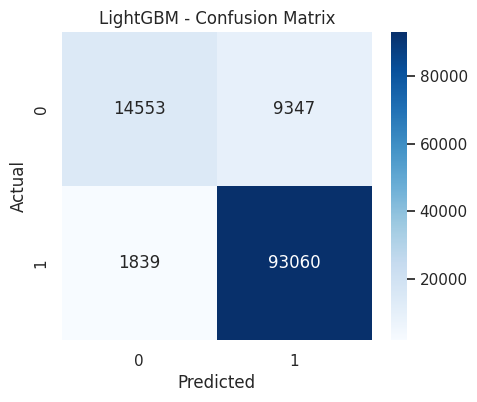

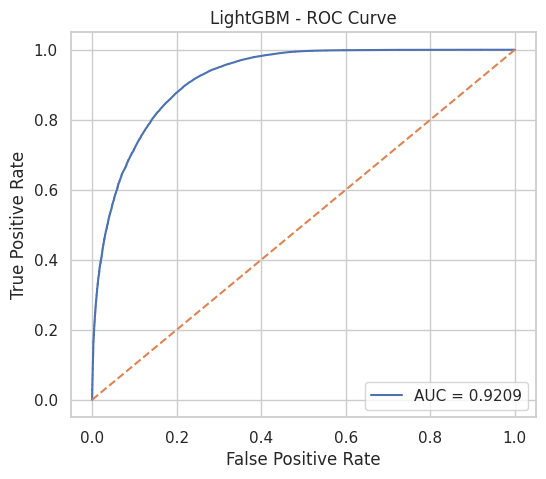

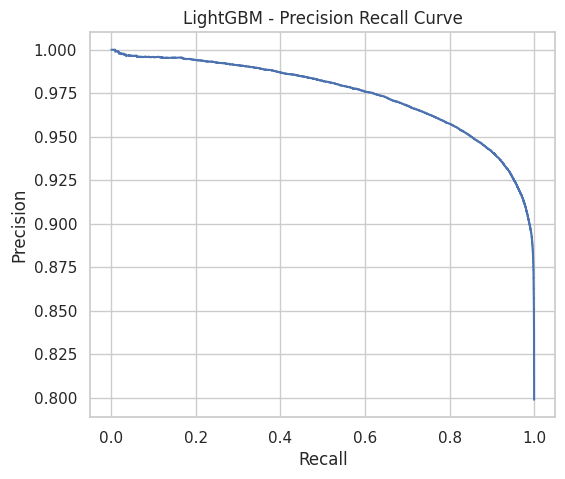


Generating SHAP values for LightGBM...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



SHAP could not be generated for this model:
Only plot_type = 'bar' is supported for multi-output explanations!

===== Training XGBoost Baseline Model =====

===== Evaluation for XGBoost =====
Accuracy: 0.9044
Precision: 0.9075
Recall: 0.9803
F1-score: 0.9425
AUC: 0.9196
KS Statistic: 0.6756
Gini Coefficient: 0.8392


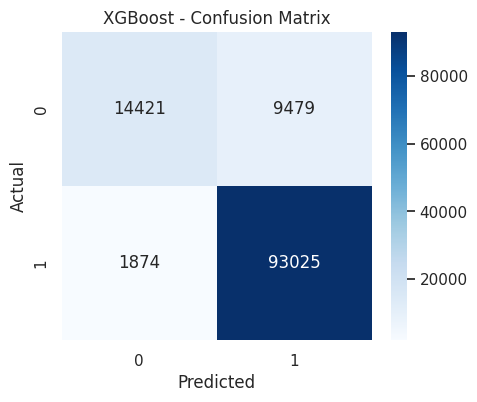

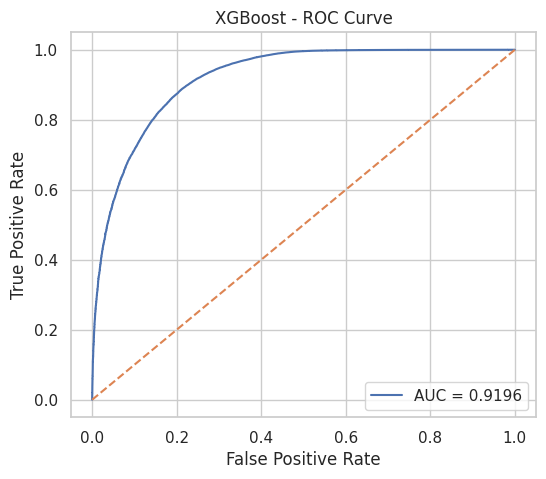

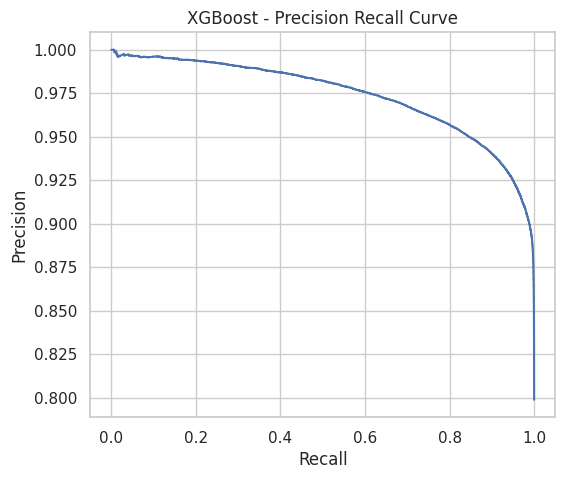


Generating SHAP values for XGBoost...


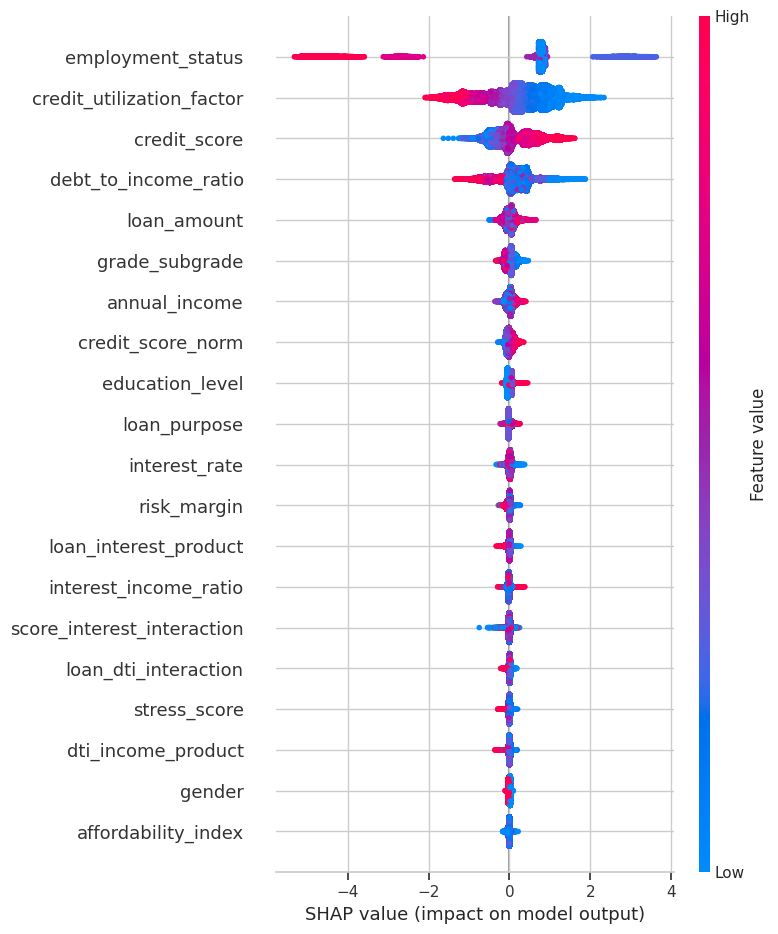


===== Training CatBoost Baseline Model =====

===== Evaluation for CatBoost =====
Accuracy: 0.9048
Precision: 0.9068
Recall: 0.9818
F1-score: 0.9428
AUC: 0.9184
KS Statistic: 0.6736
Gini Coefficient: 0.8368


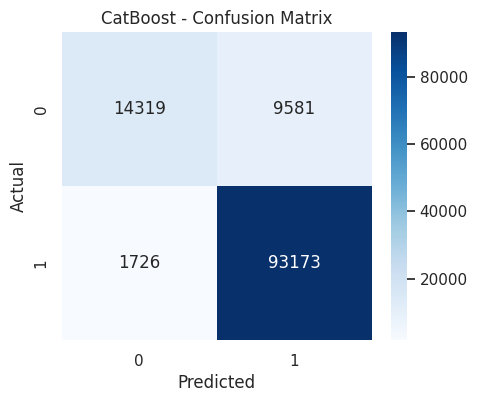

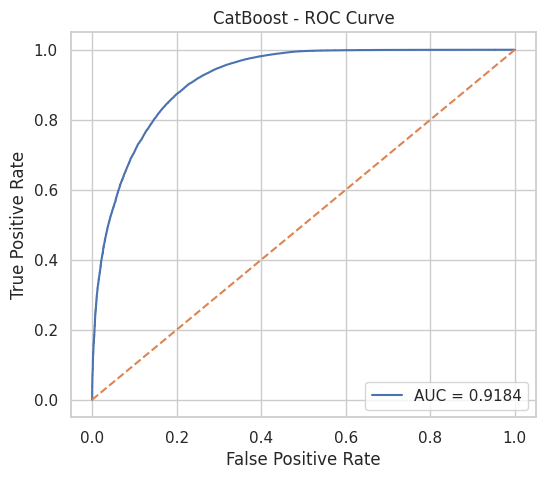

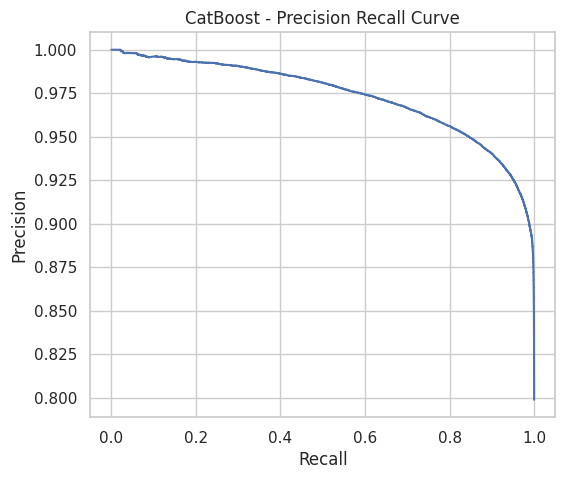


Generating SHAP values for CatBoost...


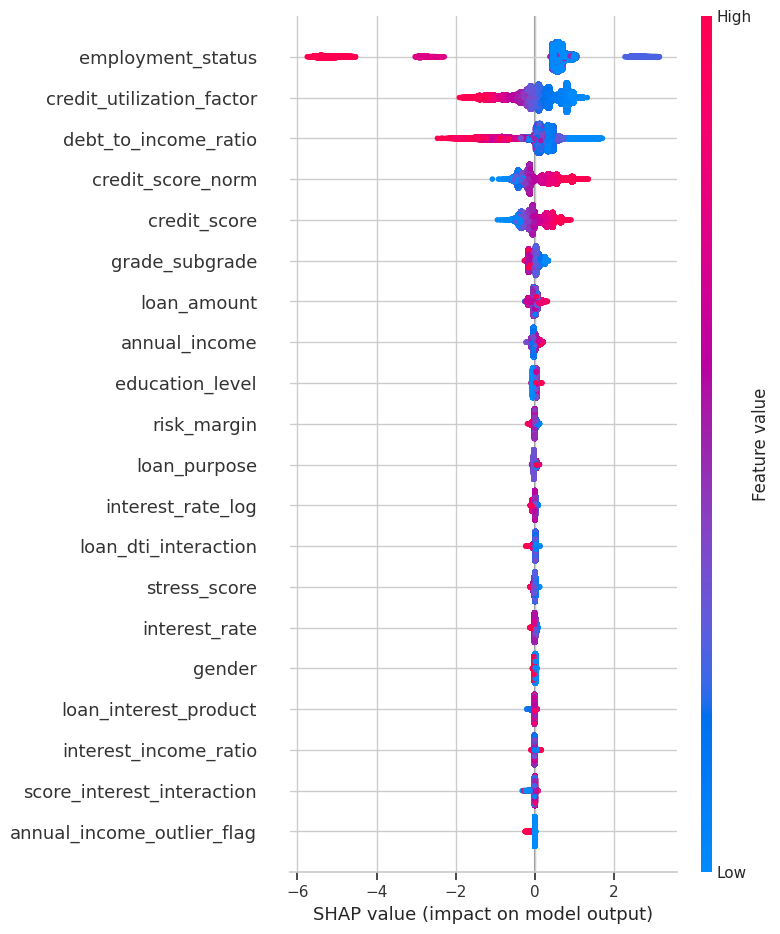

In [40]:
results = []

for model_name, model in baseline_models.items():
    print(f"\n===== Training {model_name} Baseline Model =====")

    model.fit(X_train, y_train)

    metrics = evaluate_model(
        model,
        X_train, y_train,
        X_val, y_val,
        model_name=model_name
    )
    
    results.append(metrics)


### Baseline Model Comparison Table

In [41]:
results_df = pd.DataFrame(results)
results_df.sort_values("AUC", ascending=False)


Model  Accuracy  Precision    Recall        F1       AUC        KS  \
0  LightGBM  0.905841   0.908727  0.980622  0.943306  0.920864  0.678626   
1   XGBoost  0.904435   0.907526  0.980253  0.942488  0.919605  0.675599   
2  CatBoost  0.904822   0.906758  0.981812  0.942794  0.918397  0.673637   

       Gini  
0  0.841729  
1  0.839210  
2  0.836793

## Optuna Tuning

### Optuna Tuning for LightGBM

In [42]:


def objective_lgbm(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 5),
        "verbosity": -1,
        "seed": 42
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data   = lgb.Dataset(X_val,   label=y_val)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)      # replaces verbose_eval
        ]
    )

    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)


study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgbm, n_trials=30)

best_lgb_params = study_lgb.best_params
best_lgb_params["objective"] = "binary"
best_lgb_params["metric"]     = "auc"
best_lgb_params["boosting_type"] = "gbdt"
best_lgb_params["verbosity"] = -1
best_lgb_params["seed"] = 42

print("Best LightGBM Params:", best_lgb_params)


[I 2025-12-04 00:02:29,593] A new study created in memory with name: no-name-dd585a94-0fda-4729-9ade-8d6e1cf1f416


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1415]	valid_0's auc: 0.921464


[I 2025-12-04 00:04:08,071] Trial 0 finished with value: 0.9214638558033578 and parameters: {'learning_rate': 0.01400480634558049, 'num_leaves': 93, 'feature_fraction': 0.8052016676592371, 'bagging_fraction': 0.917615556606623, 'bagging_freq': 4, 'lambda_l1': 0.4634785781134998, 'lambda_l2': 2.9631241796599723}. Best is trial 0 with value: 0.9214638558033578.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[499]	valid_0's auc: 0.921258


[I 2025-12-04 00:04:48,407] Trial 1 finished with value: 0.9212576431732464 and parameters: {'learning_rate': 0.035844857052155295, 'num_leaves': 108, 'feature_fraction': 0.9021971738974667, 'bagging_fraction': 0.8595195075019535, 'bagging_freq': 5, 'lambda_l1': 2.779878852686301, 'lambda_l2': 1.1914867642149363}. Best is trial 0 with value: 0.9214638558033578.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	valid_0's auc: 0.921696


[I 2025-12-04 00:05:34,657] Trial 2 finished with value: 0.9216955952421735 and parameters: {'learning_rate': 0.04057827900691189, 'num_leaves': 93, 'feature_fraction': 0.6708123931390322, 'bagging_fraction': 0.9567173593919956, 'bagging_freq': 9, 'lambda_l1': 3.564391659926358, 'lambda_l2': 2.5265805802290497}. Best is trial 2 with value: 0.9216955952421735.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1481]	valid_0's auc: 0.921284


[I 2025-12-04 00:07:08,598] Trial 3 finished with value: 0.92128415892148 and parameters: {'learning_rate': 0.018587318079507354, 'num_leaves': 68, 'feature_fraction': 0.9455825011131122, 'bagging_fraction': 0.6765045667586468, 'bagging_freq': 6, 'lambda_l1': 3.9727479376101913, 'lambda_l2': 4.43457751065982}. Best is trial 2 with value: 0.9216955952421735.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1380]	valid_0's auc: 0.921645


[I 2025-12-04 00:08:09,160] Trial 4 finished with value: 0.9216451535944777 and parameters: {'learning_rate': 0.03412739286921006, 'num_leaves': 26, 'feature_fraction': 0.8649103745604678, 'bagging_fraction': 0.7581168756973989, 'bagging_freq': 10, 'lambda_l1': 3.710263011873569, 'lambda_l2': 1.7133795784245005}. Best is trial 2 with value: 0.9216955952421735.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[550]	valid_0's auc: 0.921106


[I 2025-12-04 00:08:35,066] Trial 5 finished with value: 0.9211060285586159 and parameters: {'learning_rate': 0.07650868249975137, 'num_leaves': 27, 'feature_fraction': 0.9276953399027545, 'bagging_fraction': 0.6002612929168627, 'bagging_freq': 7, 'lambda_l1': 2.448439900910838, 'lambda_l2': 3.125392039096253}. Best is trial 2 with value: 0.9216955952421735.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[928]	valid_0's auc: 0.921973


[I 2025-12-04 00:09:24,792] Trial 6 finished with value: 0.9219733091261394 and parameters: {'learning_rate': 0.044517928880815946, 'num_leaves': 35, 'feature_fraction': 0.7164213004059391, 'bagging_fraction': 0.9024010143052845, 'bagging_freq': 2, 'lambda_l1': 3.5560895725941757, 'lambda_l2': 2.550350654516911}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.920374


[I 2025-12-04 00:09:41,145] Trial 7 finished with value: 0.9203741626034391 and parameters: {'learning_rate': 0.09414278163782523, 'num_leaves': 87, 'feature_fraction': 0.6065331656337914, 'bagging_fraction': 0.6423175909939333, 'bagging_freq': 1, 'lambda_l1': 2.0572221417143117, 'lambda_l2': 0.02674472770684444}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's auc: 0.921371


[I 2025-12-04 00:10:10,567] Trial 8 finished with value: 0.9213708919604066 and parameters: {'learning_rate': 0.06137596444521275, 'num_leaves': 66, 'feature_fraction': 0.6400973776547777, 'bagging_fraction': 0.771694177263101, 'bagging_freq': 9, 'lambda_l1': 4.05987471391972, 'lambda_l2': 3.6549393581973098}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's auc: 0.920831


[I 2025-12-04 00:10:29,251] Trial 9 finished with value: 0.920831263857223 and parameters: {'learning_rate': 0.08158685931187085, 'num_leaves': 81, 'feature_fraction': 0.8857054644485458, 'bagging_fraction': 0.6566883336200412, 'bagging_freq': 10, 'lambda_l1': 3.7173869212005206, 'lambda_l2': 4.762856177972272}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	valid_0's auc: 0.921856


[I 2025-12-04 00:11:07,742] Trial 10 finished with value: 0.9218560591681241 and parameters: {'learning_rate': 0.0541832508326642, 'num_leaves': 48, 'feature_fraction': 0.7261689105355333, 'bagging_fraction': 0.8614611433025448, 'bagging_freq': 1, 'lambda_l1': 4.955135672566277, 'lambda_l2': 1.289717921538927}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[632]	valid_0's auc: 0.921885


[I 2025-12-04 00:11:43,183] Trial 11 finished with value: 0.921884880384391 and parameters: {'learning_rate': 0.05606067663961889, 'num_leaves': 46, 'feature_fraction': 0.7433592883018447, 'bagging_fraction': 0.8589998478112515, 'bagging_freq': 1, 'lambda_l1': 4.881710676522135, 'lambda_l2': 1.4372015112999423}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	valid_0's auc: 0.921921


[I 2025-12-04 00:12:24,235] Trial 12 finished with value: 0.9219212590738948 and parameters: {'learning_rate': 0.051961057341415054, 'num_leaves': 46, 'feature_fraction': 0.7478620824144292, 'bagging_fraction': 0.9949795769587898, 'bagging_freq': 3, 'lambda_l1': 4.749985725861512, 'lambda_l2': 2.0270335135106095}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[929]	valid_0's auc: 0.921801


[I 2025-12-04 00:13:14,785] Trial 13 finished with value: 0.9218013897267832 and parameters: {'learning_rate': 0.049960672245038175, 'num_leaves': 46, 'feature_fraction': 0.7784816094005537, 'bagging_fraction': 0.9971616774525469, 'bagging_freq': 3, 'lambda_l1': 2.9528134019632293, 'lambda_l2': 2.3817954007017663}. Best is trial 6 with value: 0.9219733091261394.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[847]	valid_0's auc: 0.92198


[I 2025-12-04 00:13:51,718] Trial 14 finished with value: 0.9219799235134857 and parameters: {'learning_rate': 0.07009847249366583, 'num_leaves': 20, 'feature_fraction': 0.7004967334578092, 'bagging_fraction': 0.9289825175330046, 'bagging_freq': 3, 'lambda_l1': 1.518595501215714, 'lambda_l2': 0.23743120548951735}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1100]	valid_0's auc: 0.921685


[I 2025-12-04 00:14:35,500] Trial 15 finished with value: 0.9216847429204739 and parameters: {'learning_rate': 0.06946654108596875, 'num_leaves': 17, 'feature_fraction': 0.6852543720443478, 'bagging_fraction': 0.9065521056854879, 'bagging_freq': 3, 'lambda_l1': 1.106011358647907, 'lambda_l2': 0.32324381187002843}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's auc: 0.921493


[I 2025-12-04 00:14:59,022] Trial 16 finished with value: 0.9214925081547829 and parameters: {'learning_rate': 0.09766065596981598, 'num_leaves': 34, 'feature_fraction': 0.9995212962459805, 'bagging_fraction': 0.9119002902670241, 'bagging_freq': 2, 'lambda_l1': 1.5208500609850701, 'lambda_l2': 3.904783072792187}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1983]	valid_0's auc: 0.921239


[I 2025-12-04 00:16:12,055] Trial 17 finished with value: 0.9212388868306189 and parameters: {'learning_rate': 0.027489470007420948, 'num_leaves': 16, 'feature_fraction': 0.83385695946872, 'bagging_fraction': 0.818983707081402, 'bagging_freq': 5, 'lambda_l1': 0.19083194920508717, 'lambda_l2': 0.6735668940873833}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[307]	valid_0's auc: 0.921236


[I 2025-12-04 00:16:37,530] Trial 18 finished with value: 0.9212358102278393 and parameters: {'learning_rate': 0.06684230310241517, 'num_leaves': 125, 'feature_fraction': 0.6912510354695061, 'bagging_fraction': 0.9490762842574136, 'bagging_freq': 4, 'lambda_l1': 1.6420593092651, 'lambda_l2': 0.7258654173655164}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[606]	valid_0's auc: 0.921676


[I 2025-12-04 00:17:07,894] Trial 19 finished with value: 0.9216756171646218 and parameters: {'learning_rate': 0.08453212621778387, 'num_leaves': 34, 'feature_fraction': 0.6388792740999777, 'bagging_fraction': 0.8206100948539385, 'bagging_freq': 2, 'lambda_l1': 0.6981861123448959, 'lambda_l2': 3.0297704410365274}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's auc: 0.921458


[I 2025-12-04 00:17:49,375] Trial 20 finished with value: 0.9214579790423301 and parameters: {'learning_rate': 0.04436018507316258, 'num_leaves': 57, 'feature_fraction': 0.7855669134757062, 'bagging_fraction': 0.7265277339905599, 'bagging_freq': 2, 'lambda_l1': 3.1609855241914957, 'lambda_l2': 2.2133957129943522}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[897]	valid_0's auc: 0.921864


[I 2025-12-04 00:18:38,433] Trial 21 finished with value: 0.9218640936955611 and parameters: {'learning_rate': 0.04729534881925017, 'num_leaves': 37, 'feature_fraction': 0.7341173028424705, 'bagging_fraction': 0.9949643906385056, 'bagging_freq': 3, 'lambda_l1': 4.424063940386896, 'lambda_l2': 1.8762354676910484}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[578]	valid_0's auc: 0.921836


[I 2025-12-04 00:19:14,501] Trial 22 finished with value: 0.9218364981823219 and parameters: {'learning_rate': 0.062051293054017916, 'num_leaves': 56, 'feature_fraction': 0.7150159338562022, 'bagging_fraction': 0.96078615750292, 'bagging_freq': 4, 'lambda_l1': 4.401652126594599, 'lambda_l2': 3.4998159850951893}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.921865


[I 2025-12-04 00:20:39,774] Trial 23 finished with value: 0.9218653961152532 and parameters: {'learning_rate': 0.02696829906033195, 'num_leaves': 25, 'feature_fraction': 0.7700611513365585, 'bagging_fraction': 0.8872228009044827, 'bagging_freq': 3, 'lambda_l1': 2.2466252634621298, 'lambda_l2': 2.014729081381457}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's auc: 0.921693


[I 2025-12-04 00:21:13,385] Trial 24 finished with value: 0.9216927183672612 and parameters: {'learning_rate': 0.07274495918078265, 'num_leaves': 40, 'feature_fraction': 0.8183520334154827, 'bagging_fraction': 0.9378806177966792, 'bagging_freq': 6, 'lambda_l1': 3.362208982024123, 'lambda_l2': 2.6789438778160655}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[630]	valid_0's auc: 0.921853


[I 2025-12-04 00:21:53,780] Trial 25 finished with value: 0.921852549160281 and parameters: {'learning_rate': 0.05837864350327783, 'num_leaves': 56, 'feature_fraction': 0.759113476954406, 'bagging_fraction': 0.9818488345827489, 'bagging_freq': 2, 'lambda_l1': 4.48940528641866, 'lambda_l2': 0.8239007659546194}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[909]	valid_0's auc: 0.921707


[I 2025-12-04 00:22:32,183] Trial 26 finished with value: 0.9217066093743089 and parameters: {'learning_rate': 0.08646416228895523, 'num_leaves': 23, 'feature_fraction': 0.7039081523423095, 'bagging_fraction': 0.8820825933455675, 'bagging_freq': 4, 'lambda_l1': 1.898920854430002, 'lambda_l2': 1.6976579595226056}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[822]	valid_0's auc: 0.921929


[I 2025-12-04 00:23:13,040] Trial 27 finished with value: 0.9219285533296113 and parameters: {'learning_rate': 0.05232323010331053, 'num_leaves': 31, 'feature_fraction': 0.6602683008188753, 'bagging_fraction': 0.9318491970792461, 'bagging_freq': 7, 'lambda_l1': 2.677372809129385, 'lambda_l2': 4.129389035639582}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's auc: 0.921921


[I 2025-12-04 00:23:48,971] Trial 28 finished with value: 0.9219205276201815 and parameters: {'learning_rate': 0.06513117240656606, 'num_leaves': 31, 'feature_fraction': 0.6530430120346652, 'bagging_fraction': 0.9287799383209194, 'bagging_freq': 7, 'lambda_l1': 2.584223123476032, 'lambda_l2': 4.2177782446670875}. Best is trial 14 with value: 0.9219799235134857.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.920587


[I 2025-12-04 00:25:10,793] Trial 29 finished with value: 0.920587462266093 and parameters: {'learning_rate': 0.014565717508808751, 'num_leaves': 16, 'feature_fraction': 0.6075061588630165, 'bagging_fraction': 0.8321898456984175, 'bagging_freq': 7, 'lambda_l1': 1.1914083276325114, 'lambda_l2': 3.35571332826379}. Best is trial 14 with value: 0.9219799235134857.


Best LightGBM Params: {'learning_rate': 0.07009847249366583, 'num_leaves': 20, 'feature_fraction': 0.7004967334578092, 'bagging_fraction': 0.9289825175330046, 'bagging_freq': 3, 'lambda_l1': 1.518595501215714, 'lambda_l2': 0.23743120548951735, 'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42}


###  Optuna Tuning for XGBClassifier

In [43]:


def objective_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "tree_method": "hist",          # fast, CPU friendly
        "eval_metric": "auc",
        "random_state": 42,
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)

    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30)

best_xgb_params = study_xgb.best_params
best_xgb_params["tree_method"] = "hist"
best_xgb_params["eval_metric"] = "auc"
best_xgb_params["random_state"] = 42
best_xgb_params["use_label_encoder"] = False

print("Best XGBoost Params:", best_xgb_params)


[I 2025-12-04 00:25:11,176] A new study created in memory with name: no-name-79b4f392-3dd5-467d-98b6-1aaa5862bf11
[I 2025-12-04 00:25:18,757] Trial 0 finished with value: 0.9179765296387999 and parameters: {'learning_rate': 0.06430886787741016, 'max_depth': 11, 'subsample': 0.6975299814974721, 'colsample_bytree': 0.6750923237794304, 'gamma': 2.0936681865672373, 'min_child_weight': 9}. Best is trial 0 with value: 0.9179765296387999.
[I 2025-12-04 00:25:22,874] Trial 1 finished with value: 0.9115801988293124 and parameters: {'learning_rate': 0.03673086146511221, 'max_depth': 4, 'subsample': 0.7116998297505045, 'colsample_bytree': 0.6219531272326528, 'gamma': 0.6794507561437807, 'min_child_weight': 8}. Best is trial 0 with value: 0.9179765296387999.
[I 2025-12-04 00:25:26,694] Trial 2 finished with value: 0.9149906844365387 and parameters: {'learning_rate': 0.09137873655613374, 'max_depth': 4, 'subsample': 0.7695624491705899, 'colsample_bytree': 0.9222980796454315, 'gamma': 0.355413090475

Best XGBoost Params: {'learning_rate': 0.0965376842446646, 'max_depth': 9, 'subsample': 0.7347250365726568, 'colsample_bytree': 0.8471963612024938, 'gamma': 4.54887681701876, 'min_child_weight': 4, 'tree_method': 'hist', 'eval_metric': 'auc', 'random_state': 42, 'use_label_encoder': False}


###  Optuna Tuning for CatBoostClassifier

In [44]:


def objective_cat(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "iterations": 1200,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": False,
        "random_seed": 42,
        "task_type": "CPU"   # change to "GPU" if available
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)


study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=30)

best_cat_params = study_cat.best_params
best_cat_params.update({
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "verbose": False,
    "random_seed": 42,
    "task_type": "CPU"
})

print("Best CatBoost Params:", best_cat_params)


[I 2025-12-04 00:28:13,074] A new study created in memory with name: no-name-7bdd8a9f-a3f4-4845-aaac-672f33e4f287
[I 2025-12-04 00:29:18,390] Trial 0 finished with value: 0.9214521891386751 and parameters: {'learning_rate': 0.08311952597133006, 'depth': 5, 'l2_leaf_reg': 4.129092349451293}. Best is trial 0 with value: 0.9214521891386751.
[I 2025-12-04 00:30:37,171] Trial 1 finished with value: 0.9192645733334374 and parameters: {'learning_rate': 0.02543713348702299, 'depth': 7, 'l2_leaf_reg': 2.0516384311673903}. Best is trial 0 with value: 0.9214521891386751.
[I 2025-12-04 00:31:37,514] Trial 2 finished with value: 0.9179003336778088 and parameters: {'learning_rate': 0.02681729712527759, 'depth': 4, 'l2_leaf_reg': 1.028061388127178}. Best is trial 0 with value: 0.9214521891386751.
[I 2025-12-04 00:32:56,882] Trial 3 finished with value: 0.9213725008058555 and parameters: {'learning_rate': 0.0814880478359526, 'depth': 7, 'l2_leaf_reg': 3.013635327767683}. Best is trial 0 with value: 0.

Best CatBoost Params: {'learning_rate': 0.09362971587034483, 'depth': 5, 'l2_leaf_reg': 7.1923601814709155, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'verbose': False, 'random_seed': 42, 'task_type': 'CPU'}


In [45]:
# Final LightGBM params
lgb_params_final = {
    **best_lgb_params,
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "n_estimators": 3000,
    "random_state": 42
}

best_lgb_model = lgb.LGBMClassifier(**lgb_params_final)
best_lgb_model.fit(X_train, y_train)


LGBMClassifier(bagging_fraction=0.9289825175330046, bagging_freq=3,
               feature_fraction=0.7004967334578092, lambda_l1=1.518595501215714,
               lambda_l2=0.23743120548951735, learning_rate=0.07009847249366583,
               metric='auc', n_estimators=3000, num_leaves=20,
               objective='binary', random_state=42, seed=42, verbosity=-1)

In [46]:
xgb_params_final = {
    **best_xgb_params,
    "eval_metric": "auc",
    "tree_method": "hist",
    "random_state": 42,
    "use_label_encoder": False
}

best_xgb_model = XGBClassifier(**xgb_params_final)
best_xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8471963612024938, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=4.54887681701876,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0965376842446646,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [47]:
cat_params_final = {
    **best_cat_params,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "verbose": False,
    "random_seed": 42,
    "task_type": "CPU"     # change to GPU if available
}

best_cat_model = CatBoostClassifier(**cat_params_final)
best_cat_model.fit(X_train, y_train)


## Evaluate All Tuned Models


================ LIGHTGBM (Tuned) ================

===== Evaluation for LightGBM (Tuned) =====
Accuracy: 0.9056
Precision: 0.9109
Recall: 0.9774
F1-score: 0.9430
AUC: 0.9213
KS Statistic: 0.6795
Gini Coefficient: 0.8427


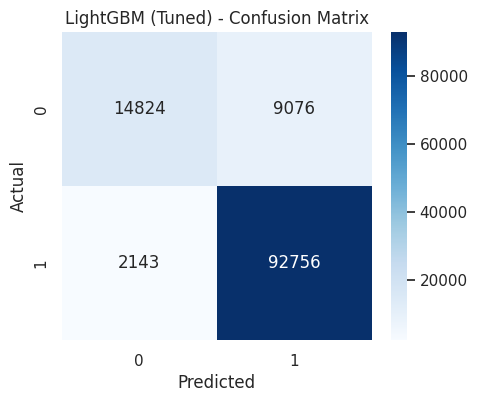

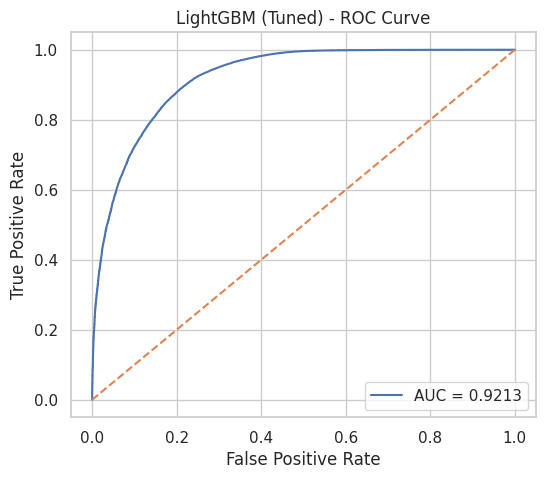

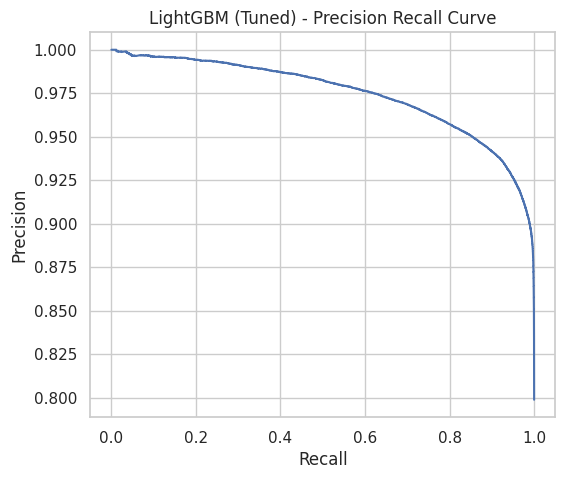


Generating SHAP values for LightGBM (Tuned)...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



SHAP could not be generated for this model:
Only plot_type = 'bar' is supported for multi-output explanations!

================ XGBOOST (Tuned) ================

===== Evaluation for XGBoost (Tuned) =====
Accuracy: 0.9036
Precision: 0.9066
Recall: 0.9803
F1-score: 0.9420
AUC: 0.9186
KS Statistic: 0.6737
Gini Coefficient: 0.8372


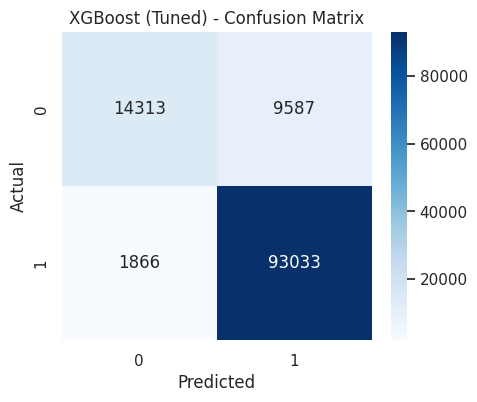

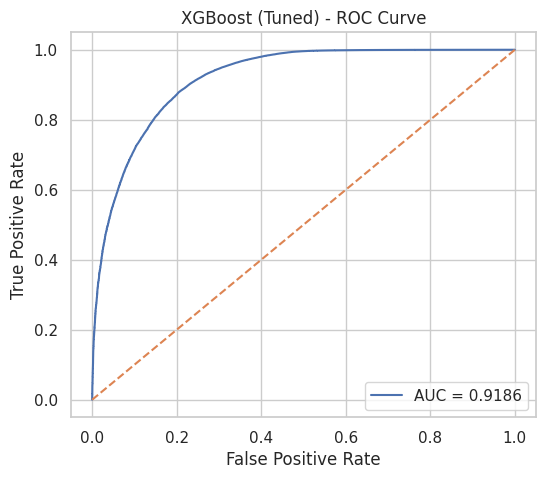

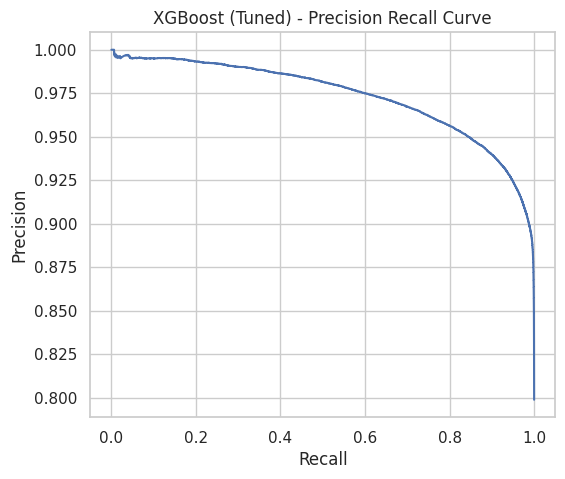


Generating SHAP values for XGBoost (Tuned)...


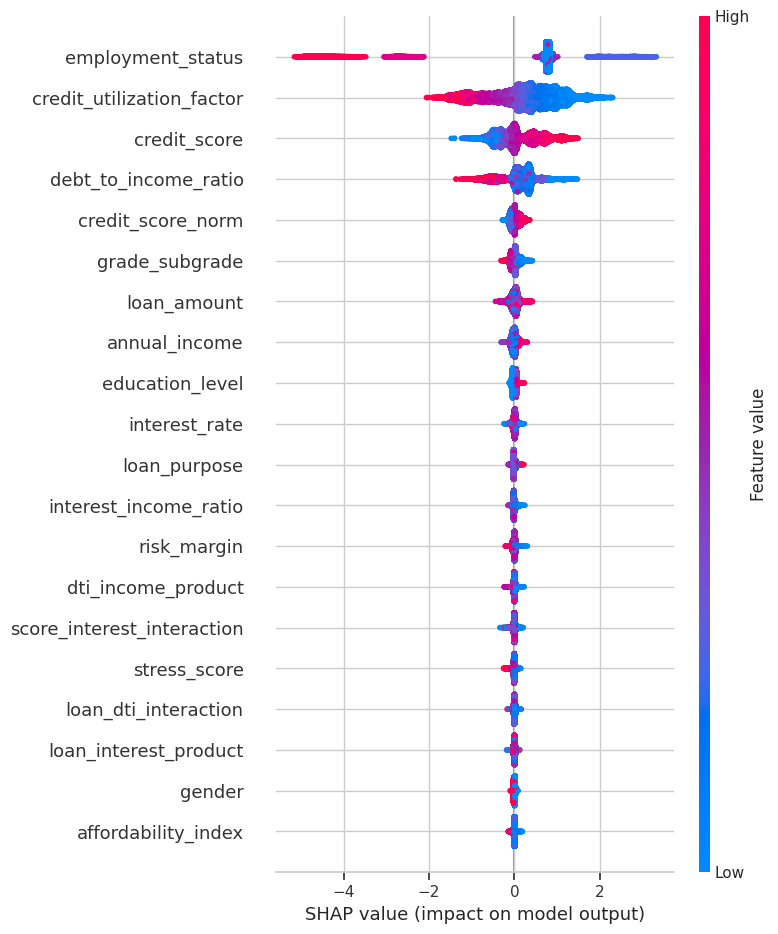


================ CATBOOST (Tuned) ================

===== Evaluation for CatBoost (Tuned) =====
Accuracy: 0.9062
Precision: 0.9099
Recall: 0.9795
F1-score: 0.9434
AUC: 0.9214
KS Statistic: 0.6806
Gini Coefficient: 0.8428


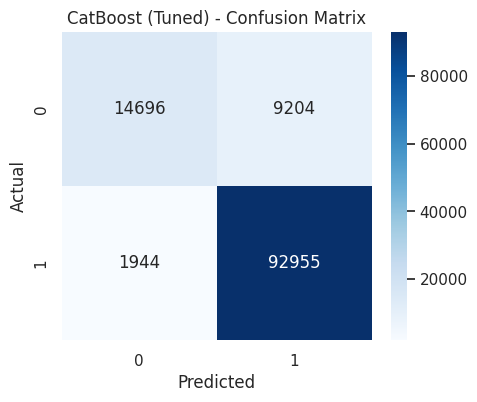

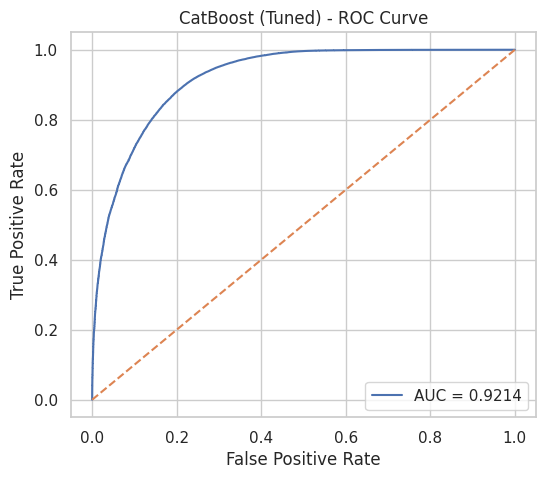

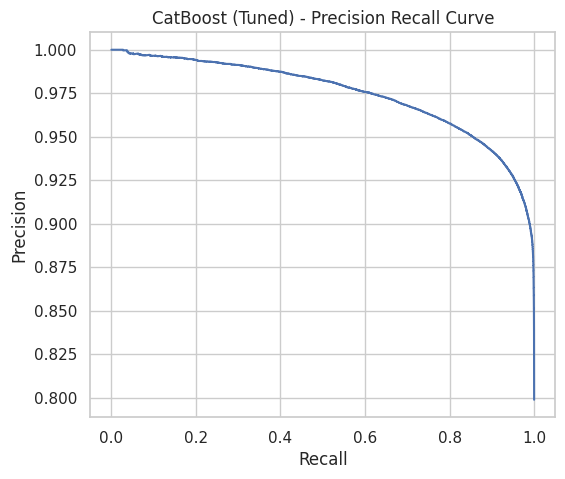


Generating SHAP values for CatBoost (Tuned)...


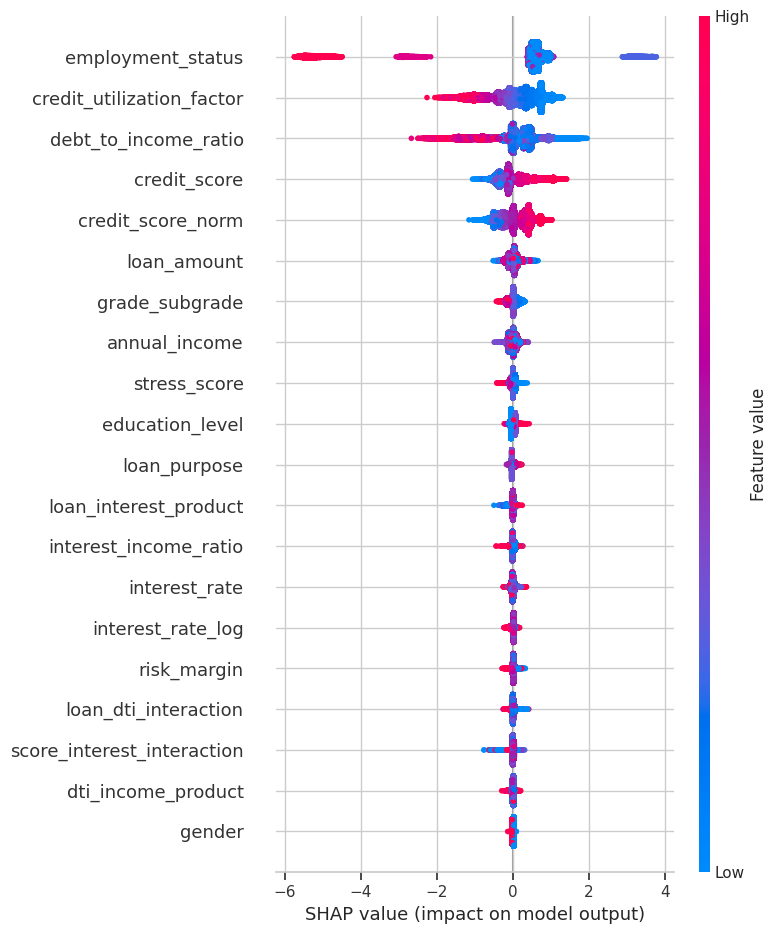


============== MODEL COMPARISON TABLE ==============

              Model  Accuracy  Precision    Recall        F1       AUC  \
2  CatBoost (Tuned)  0.906161   0.909905  0.979515  0.943428  0.921405   
0  LightGBM (Tuned)  0.905563   0.910873  0.977418  0.942973  0.921344   
1   XGBoost (Tuned)  0.903593   0.906578  0.980337  0.942016  0.918603   

         KS      Gini  
2  0.680592  0.842811  
0  0.679485  0.842689  
1  0.673713  0.837205  


In [48]:


all_results = []

# LightGBM
print("\n================ LIGHTGBM (Tuned) ================")
results_lgb = evaluate_model(
    best_lgb_model,
    X_train, y_train,
    X_val, y_val,
    model_name="LightGBM (Tuned)"
)
all_results.append(results_lgb)


# XGBoost
print("\n================ XGBOOST (Tuned) ================")
results_xgb = evaluate_model(
    best_xgb_model,
    X_train, y_train,
    X_val, y_val,
    model_name="XGBoost (Tuned)"
)
all_results.append(results_xgb)


# CatBoost
print("\n================ CATBOOST (Tuned) ================")
results_cat = evaluate_model(
    best_cat_model,
    X_train, y_train,
    X_val, y_val,
    model_name="CatBoost (Tuned)"
)
all_results.append(results_cat)


# Convert to dataframe for comparison
results_table = pd.DataFrame(all_results)
results_table = results_table.sort_values("AUC", ascending=False)

print("\n============== MODEL COMPARISON TABLE ==============\n")
print(results_table)


## Select the Best Model

In [49]:
# Sort by AUC first, then KS, then Gini, then F1
results_table_sorted = (
    results_table
    .sort_values(["AUC", "KS", "Gini", "F1"], ascending=False)
    .reset_index(drop=True)
)

print("\n================ BEST MODEL (Auto-Selected) ================\n")
print(results_table_sorted.iloc[0])

best_model_name = results_table_sorted.iloc[0]["Model"]
print(f"\nBest model selected: {best_model_name}")



================ BEST MODEL (Auto-Selected) ================

Model        CatBoost (Tuned)
Accuracy             0.906161
Precision            0.909905
Recall               0.979515
F1                   0.943428
AUC                  0.921405
KS                   0.680592
Gini                 0.842811
Name: 0, dtype: object

Best model selected: CatBoost (Tuned)


In [50]:
model_map = {
    "LightGBM (Tuned)": best_lgb_model,
    "XGBoost (Tuned)": best_xgb_model,
    "CatBoost (Tuned)": best_cat_model
}

best_model = model_map[best_model_name]

## Train Best Model on Full Data 

In [51]:

print(f"Retraining best model on full data: {best_model_name}")

if best_model_name == "LightGBM (Tuned)":
    final_model = lgb.LGBMClassifier(**lgb_params_final)
    final_model.fit(X, y)

elif best_model_name == "XGBoost (Tuned)":
    final_model = XGBClassifier(**xgb_params_final)
    final_model.fit(X, y)

elif best_model_name == "CatBoost (Tuned)":
    final_model = CatBoostClassifier(**cat_params_final)
    final_model.fit(X, y)

else:
    raise ValueError(f"Unknown best_model_name: {best_model_name}")


Retraining best model on full data: CatBoost (Tuned)


# Kaggle Submission

In [52]:


# Predict probabilities for the positive class (loan_paid_back = 1)
test_pred_prob = final_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": final_test["id"],
    "loan_paid_back": test_pred_prob
})



In [53]:
# Ensure only required columns
submission = submission[["id", "loan_paid_back"]]

# Round to 6 decimal places
submission["loan_paid_back"] = submission["loan_paid_back"].round(4)





In [54]:

submission["loan_paid_back"] = submission["loan_paid_back"].astype(float)

In [55]:

# Now save normally (index=False)
submission.to_csv("submission.csv", index=False)

In [56]:
# Check file size

print("File size (MB):", os.path.getsize("submission.csv") / (1024*1024))

File size (MB): 3.3723983764648438


In [57]:
submission.shape

(254569, 2)

In [58]:


os.listdir("/kaggle/working")


['submission.csv', 'catboost_info', '__notebook__.ipynb']